# FormuLens: Screening Notebook (NoMD; TSV -> Models -> External Ranking)

Stage-1 deliverables: SMILES QC, name->SMILES join, 3 split modes, EBM+GBDT training, calibration/uncertainty, explanations, and external screening outputs (no batch MD job generation in this version).

## Label convention

- **NP**: nanoparticle formation observed (positive)
- **No NP**: no nanoparticle formation observed (negative)

> 内部仍保留 `y_np∈{0,1}` 便于建模，但所有图表/表格统一用 `No NP / NP` 展示。


In [1]:
# 0) Install dependencies (auto)
# This cell installs missing *optional* packages so the notebook can run end-to-end.
# Safe to re-run: it only installs when missing.

import importlib
import subprocess
import sys


def _is_importable(name: str) -> bool:
    try:
        importlib.import_module(name)
        return True
    except Exception:
        return False


def _pip_install(*pkgs: str) -> None:
    cmd = [sys.executable, "-m", "pip", "install", "-q", *pkgs]
    print("[deps]", " ".join(cmd))
    subprocess.check_call(cmd)
    importlib.invalidate_caches()


# Core requirements
for mod in ["numpy", "pandas", "sklearn", "matplotlib"]:
    if not _is_importable(mod):
        raise RuntimeError(f"Missing required dependency: {mod}")

# RDKit is best installed via conda; do not pip-install automatically.
if not _is_importable("rdkit"):
    raise RuntimeError("RDKit is required. Install via conda: `conda install -c rdkit rdkit`")

# Optional but recommended (enables EBM/SHAP/network figures, styled tables, and better label placement)
want = {
    "interpret": "interpret",      # EBM
    "lightgbm": "lightgbm",        # LightGBM (GBDT)
    "xgboost": "xgboost",          # XGBoost (GBDT)
    "catboost": "catboost",        # CatBoost (meta-model candidate)
    "ipywidgets": "ipywidgets",    # interactive dropdown threshold picker
    "shap": "shap",                # SHAP explainability
    "networkx": "networkx",        # network plot
    "jinja2": "jinja2",            # pandas Styler / to_latex
    "adjustText": "adjustText",    # smart label placement in plots
    "plotly": "plotly",
    "kaleido": "kaleido",
    "torch": "torch",
}
missing = [pip_name for mod, pip_name in want.items() if not _is_importable(mod)]
if missing:
    _pip_install(*missing)

# Final sanity checks
if not _is_importable("interpret"):
    raise RuntimeError("Failed to import `interpret` after installation.")

print("[deps] OK")


[deps] OK


In [2]:
# 1) Init
from pathlib import Path
import json
import pickle
import sys

import numpy as np
import pandas as pd

import warnings

# Silence noisy RDKit console logs (keeps notebook output clean).
try:
    from rdkit import RDLogger  # type: ignore

    RDLogger.DisableLog("rdApp.*")
except Exception:
    pass

# Silence a few harmless sklearn warnings during plotting/training.
warnings.filterwarnings(
    "ignore",
    message=r"X does not have valid feature names, but .* was fitted with feature names",
)


def find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / "data" / "screening_data.tsv").exists():
            return p
    raise FileNotFoundError("Could not locate repo root (data/screening_data.tsv)")


REPO = find_repo_root(Path.cwd())
if str(REPO) not in sys.path:
    sys.path.insert(0, str(REPO))

import formulens_pipeline as cap
CFG = cap.load_config(str(REPO / "config.json"))
CFG["paths"]["data_dir"] = str(REPO / "data")
CFG["paths"]["results_dir"] = str(REPO / "results")
CFG["paths"]["runs_dir"] = str(REPO / "runs")
CFG["paths"]["models_dir"] = str(REPO / "results" / "models")
CFG["paths"]["cache_dir"] = str(REPO / "results" / "cache")
CFG["paths"]["global_explanations_dir"] = str(REPO / "results" / "global_explanations")
PATHS = cap.ensure_project_dirs(CFG)

np.random.seed(int(CFG["random_seed"]))
REPO, PATHS

(PosixPath('/media/xuchengjie/E7562A2674DB25F7/SRRSH/Sirt7/12.27'),
 {'data_dir': PosixPath('/media/xuchengjie/E7562A2674DB25F7/SRRSH/Sirt7/12.27/data'),
  'results_dir': PosixPath('/media/xuchengjie/E7562A2674DB25F7/SRRSH/Sirt7/12.27/results'),
  'runs_dir': PosixPath('/media/xuchengjie/E7562A2674DB25F7/SRRSH/Sirt7/12.27/runs'),
  'models_dir': PosixPath('/media/xuchengjie/E7562A2674DB25F7/SRRSH/Sirt7/12.27/results/models'),
  'cache_dir': PosixPath('/media/xuchengjie/E7562A2674DB25F7/SRRSH/Sirt7/12.27/results/cache'),
  'global_explanations_dir': PosixPath('/media/xuchengjie/E7562A2674DB25F7/SRRSH/Sirt7/12.27/results/global_explanations')})

In [3]:
# 16) Plotting + export utilities (publication style)
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

# Human-friendly labels for NP formation (avoid 0/1 in figures)
NP_LABELS = {0: "No NP", 1: "NP"}
NP_ORDER = [NP_LABELS[0], NP_LABELS[1]]

from matplotlib.colors import BoundaryNorm, ListedColormap

# Discrete colormap for binary NP formation
NP_CMAP = ListedColormap(["#440154", "#FDE725"])
NP_NORM = BoundaryNorm([-0.5, 0.5, 1.5], NP_CMAP.N)

try:
    from IPython import get_ipython
    from IPython.display import Image, display
except Exception:
    get_ipython = None
    Image = None
    display = None


def _in_notebook() -> bool:
    if get_ipython is None:
        return False
    try:
        ip = get_ipython()
    except Exception:
        return False
    if ip is None:
        return False
    return ip.__class__.__name__ == "ZMQInteractiveShell"


results_dir = globals().get("results_dir", CFG["paths"]["results_dir"])

FIG_DIR = Path(results_dir) / "figures"
TAB_DIR = Path(results_dir) / "tables"
FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)


def show_image(path: Path, *, width: int | None = None):
    # Display a saved image inside a Jupyter notebook.
    if not _in_notebook() or display is None or Image is None:
        return
    try:
        display(Image(filename=str(path), width=width))
    except Exception:
        pass


def setup_style():
    # Matplotlib defaults tuned for print + safer saves (no label clipping)
    mpl.rcParams.update(
        {
            "figure.dpi": 120,
            "savefig.dpi": 350,
            "savefig.bbox": "tight",
            "savefig.pad_inches": 0.15,
            "font.size": 11,
            "axes.titlesize": 12,
            "axes.labelsize": 11,
            "xtick.labelsize": 10,
            "ytick.labelsize": 10,
            "legend.fontsize": 10,
            "axes.spines.top": False,
            "axes.spines.right": False,
            "axes.grid": True,
            "grid.alpha": 0.25,
            "axes.linewidth": 1.0,
            "lines.linewidth": 2.0,
            "lines.markersize": 6,
        }
    )
    try:
        import seaborn as sns

        sns.set_theme(style="whitegrid", context="paper")
        sns.set_palette("deep")
        return sns
    except Exception:
        return None


SNS = setup_style()


def savefig(fig, stem: str, *, show: bool = True, width: int | None = None):
    # Save (png/pdf/svg) and display the png inline by default.
    stem = stem.replace(" ", "_")
    png = FIG_DIR / f"{stem}.png"
    pdf = FIG_DIR / f"{stem}.pdf"
    svg = FIG_DIR / f"{stem}.svg"

    fig.savefig(png, bbox_inches="tight")
    try:
        fig.savefig(pdf, bbox_inches="tight")
    except Exception:
        pass
    try:
        fig.savefig(svg, bbox_inches="tight")
    except Exception:
        pass

    if show:
        show_image(png, width=width)

    plt.close(fig)
    return png


def export_table(df: pd.DataFrame, stem: str, *, index: bool = False):
    stem = stem.replace(" ", "_")
    csv_path = TAB_DIR / f"{stem}.csv"
    html_path = TAB_DIR / f"{stem}.html"
    tex_path = TAB_DIR / f"{stem}.tex"
    df.to_csv(csv_path, index=index)
    try:
        df.to_html(html_path, index=index)
    except Exception:
        pass
    try:
        df.to_latex(str(tex_path), index=index, escape=False, booktabs=True)
    except Exception:
        pass
    return csv_path


FIG_DIR, TAB_DIR


(PosixPath('/media/xuchengjie/E7562A2674DB25F7/SRRSH/Sirt7/12.27/results/figures'),
 PosixPath('/media/xuchengjie/E7562A2674DB25F7/SRRSH/Sirt7/12.27/results/tables'))

## Publication-ready figures & tables

The cells below generate a figure/table bundle under `results/figures/` and `results/tables/` (PNG + PDF where possible).


In [4]:
# 2) Load TSVs + schema mapping
DATA = Path(CFG["paths"]["data_dir"])

screen_raw = cap.read_tsv_auto(str(DATA / "screening_data.tsv"))
extra_path = DATA / "screening_data_extra.tsv"
extra_raw = cap.read_tsv_auto(str(extra_path)) if extra_path.exists() else None

if extra_raw is not None:
    print(f"[labels] Found extra labels: {extra_path} ({extra_raw.shape[0]} rows)")


drugs_raw = cap.read_tsv_auto(str(DATA / "selected_drugs_smiles.tsv"))
excs_raw = cap.read_tsv_auto(str(DATA / "selected_excipients_smiles.tsv"))
drugbank_raw = cap.read_tsv_auto(str(DATA / "drugbank5_approved_names_smiles.tsv"))
gras_raw = cap.read_tsv_auto(str(DATA / "gras_iig.tsv"))
selfagg_raw = cap.read_tsv_auto(str(DATA / "drugbank_selfaggs_smiles.tsv"))
pair_comp_raw = cap.read_tsv_auto(str(DATA / "pair_composition.tsv"))

screen = cap.standardize_screening_schema(screen_raw)
if extra_raw is not None:
    extra = cap.standardize_screening_schema(extra_raw)
    before = int(screen.shape[0])
    screen = pd.concat([screen, extra], ignore_index=True)
    screen = screen.drop_duplicates(subset=["drug_name", "excipient_name"], keep="last").reset_index(drop=True)
    print(f"[labels] Merged: {before} + {int(extra.shape[0])} -> {int(screen.shape[0])} rows (extra overrides base on duplicates)")

drugs = cap.standardize_name_smiles_schema(drugs_raw, id_prefix="D")
excs = cap.standardize_name_smiles_schema(excs_raw, id_prefix="E")

drugbank = pd.DataFrame(
    {
        "name": drugbank_raw["NAME"] if "NAME" in drugbank_raw.columns else drugbank_raw.iloc[:, 2],
        "smiles": drugbank_raw["SMILES"] if "SMILES" in drugbank_raw.columns else drugbank_raw.iloc[:, 1],
        "source": "drugbank5",
    }
)
gras = pd.DataFrame(
    {
        "name": gras_raw["NAME"] if "NAME" in gras_raw.columns else gras_raw.iloc[:, 0],
        "smiles": gras_raw["SMILES"] if "SMILES" in gras_raw.columns else (gras_raw.iloc[:, 2] if gras_raw.shape[1] >= 3 else None),
        "type": gras_raw["TYPE"] if "TYPE" in gras_raw.columns else (gras_raw.iloc[:, 1] if gras_raw.shape[1] >= 2 else None),
        "source": "gras_iig",
    }
)
selfagg = pd.DataFrame(
    {
        "name": selfagg_raw["NAME"] if "NAME" in selfagg_raw.columns else selfagg_raw.iloc[:, 0],
        "smiles": selfagg_raw["SMILES"] if "SMILES" in selfagg_raw.columns else selfagg_raw.iloc[:, 1],
        "selfagg_prior": 1,
    }
)

# pair_composition.tsv: tolerate headerless format
pc_cols_upper = [str(c).upper() for c in pair_comp_raw.columns]
if "DRUG" in pc_cols_upper and "EXCIPIENT" in pc_cols_upper:
    pair_comp = pd.DataFrame(
        {
            "drug_name": pair_comp_raw[pair_comp_raw.columns[pc_cols_upper.index("DRUG")]],
            "excipient_name": pair_comp_raw[pair_comp_raw.columns[pc_cols_upper.index("EXCIPIENT")]],
            "use_for_sim": 1,
        }
    )
else:
    pair_comp = pd.DataFrame(
        {
            "drug_name": pair_comp_raw.iloc[:, 0],
            "excipient_name": pair_comp_raw.iloc[:, 1],
            "use_for_sim": 1,
        }
    )

screen.head()


drug_name excipient_name  y_np  y_size_reduction  y_radius_nm
0  Sorafenib       caffeine     0               NaN          NaN
1  Sorafenib  succinic_acid     0               NaN          NaN
2  Sorafenib  octyl_gallate     0               NaN          NaN
3  Sorafenib  DL-malic_acid     0               NaN          NaN
4  Sorafenib    adipic_acid     0               NaN          NaN

In [5]:
# 3) SMILES standardize (RDKit) + QC logs
results_dir = CFG["paths"]["results_dir"]

drugs = cap.standardize_smiles_table(drugs, dataset="selected_drugs", results_dir=results_dir)
excs = cap.standardize_smiles_table(excs, dataset="selected_excipients", results_dir=results_dir)
drugbank = cap.standardize_smiles_table(drugbank, dataset="drugbank5", results_dir=results_dir)
gras = cap.standardize_smiles_table(gras, dataset="gras_iig", results_dir=results_dir)
selfagg = cap.standardize_smiles_table(selfagg, dataset="drugbank_selfaggs", results_dir=results_dir)

drugs.dropna(subset=["smiles_std"]).head()


name                                             smiles mol_id  \
0     Sorafenib  CNC(=O)C1=NC=CC(OC2=CC=C(NC(=O)NC3=CC(=C(Cl)C=...  D0000   
1  Lumefantrine  CCCCN(CCCC)CC(O)C1=C2C(=CC(Cl)=C1)\C(=C/C1=CC=...  D0001   
2    Atovaquone  OC1=C([C@H]2CC[C@@H](CC2)C2=CC=C(Cl)C=C2)C(=O)...  D0002   
3    Nelfinavir  [H][C@@]12CCCC[C@]1([H])CN(C[C@@H](O)[C@H](CSC...  D0003   
4     Gefitinib  COC1=C(OCCCN2CCOCC2)C=C2C(NC3=CC(Cl)=C(F)C=C3)...  D0004   

                                          smiles_std  
0  CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)...  
1  CCCCN(CCCC)CC(O)c1cc(Cl)cc2c1-c1ccc(Cl)cc1/C2=...  
2  O=C1C(O)=C([C@H]2CC[C@H](c3ccc(Cl)cc3)CC2)C(=O...  
3  Cc1c(O)cccc1C(=O)N[C@@H](CSc1ccccc1)[C@H](O)CN...  
4     COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1

In [6]:
# 4) Build training pairs (screening join)
pairs, join_fail = cap.resolve_name_to_smiles(screen, drugs, excs)
join_fail.to_csv(Path(results_dir) / "name_join_failures.csv", index=False)

# QC: size_reduction range filter
qc_sr = CFG.get("qc", {}).get("size_reduction", {})
SR_MIN = float(qc_sr.get("min", 0.0))
SR_MAX = float(qc_sr.get("max", 1.0))

pairs["y_size_reduction_raw"] = pairs["y_size_reduction"]
sr = pairs["y_size_reduction_raw"].to_numpy(dtype=float)
sr_has = np.isfinite(sr)
sr_in_range = sr_has & (sr >= SR_MIN) & (sr <= SR_MAX)
sr_dropped = sr_has & ~sr_in_range
pairs.loc[sr_dropped, "y_size_reduction"] = np.nan

if int(sr_dropped.sum()) > 0:
    dropped_sr_df = pairs.loc[sr_dropped, ["drug_name", "excipient_name", "y_np", "y_size_reduction_raw"]].copy()
    dropped_sr_df = dropped_sr_df.sort_values("y_size_reduction_raw", ascending=False)
    export_table(dropped_sr_df, "size_reduction_qc_dropped")

# QC: drop low-quality / out-of-scope radius labels (cell-entry range) + robust filters
qc_r = CFG.get("qc", {}).get("radius_nm", {})
R_MIN = float(qc_r.get("min", 20.0))
R_MAX = float(qc_r.get("max", 250.0))
radius_mad_z = float(qc_r.get("mad_z", 0.0) or 0.0)

# Optional group-wise MAD filtering (helps remove inconsistent labels)
GROUP_MIN_N = int(qc_r.get("group_mad_min_n", 5) or 5)
GROUP_MAD_Z_EXC = float(qc_r.get("group_mad_z_excipient", 0.0) or 0.0)
GROUP_MAD_Z_DRUG = float(qc_r.get("group_mad_z_drug", 0.0) or 0.0)

pairs["y_radius_nm_raw"] = pairs["y_radius_nm"]
r = pairs["y_radius_nm_raw"].to_numpy(dtype=float)
has_label = np.isfinite(r)

keep = has_label.copy()
keep &= (r >= R_MIN) & (r <= R_MAX)

qc_reason = np.full((len(pairs),), "", dtype=object)
qc_reason[has_label & ~((r >= R_MIN) & (r <= R_MAX))] = "out_of_range"

# Global MAD-z filter in log1p-space
if radius_mad_z > 0 and int(keep.sum()) > 5:
    logy = np.log1p(r[keep])
    med = float(np.median(logy))
    mad = float(np.median(np.abs(logy - med)))
    if mad > 0:
        z = np.abs((np.log1p(r) - med) / (1.4826 * mad))
        bad = keep & (z > radius_mad_z)
        keep[bad] = False
        qc_reason[bad] = "global_mad_z"


def _apply_group_mad_filter(group_col: str, zthr: float, reason: str) -> None:
    if zthr <= 0:
        return
    sub = pairs.loc[keep, [group_col]].copy()
    for _, idxs in sub.groupby(group_col).groups.items():
        idxs = np.asarray(list(idxs), dtype=int)
        if int(idxs.size) < int(GROUP_MIN_N):
            continue
        vals = np.log1p(r[idxs])
        med = float(np.median(vals))
        mad = float(np.median(np.abs(vals - med)))
        if mad <= 0:
            continue
        z = np.abs((vals - med) / (1.4826 * mad))
        bad_local = z > float(zthr)
        if bool(bad_local.any()):
            bad_idxs = idxs[bad_local]
            keep[bad_idxs] = False
            qc_reason[bad_idxs] = reason


_apply_group_mad_filter("drug_name", GROUP_MAD_Z_DRUG, "drug_group_mad_z")
_apply_group_mad_filter("excipient_name", GROUP_MAD_Z_EXC, "excipient_group_mad_z")

# Re-run global MAD-z after group filtering (stabilizes QC; removes a few remaining inconsistent labels)
if radius_mad_z > 0 and int(keep.sum()) > 5:
    logy2 = np.log1p(r[keep])
    med2 = float(np.median(logy2))
    mad2 = float(np.median(np.abs(logy2 - med2)))
    if mad2 > 0:
        z2 = np.abs((np.log1p(r) - med2) / (1.4826 * mad2))
        bad2 = keep & (z2 > radius_mad_z)
        if bool(bad2.any()):
            keep[bad2] = False
            qc_reason[bad2] = "global_mad_z_post_group"

dropped = has_label & ~keep
pairs.loc[dropped, "y_radius_nm"] = np.nan

print("pairs:", pairs.shape, "join_fail:", join_fail.shape)
print(
    f"[qc] size_reduction kept {int(np.isfinite(pairs['y_size_reduction']).sum())} / {int(sr_has.sum())} "
    f"(range {SR_MIN:g}-{SR_MAX:g})"
)
print(
    f"[qc] radius_nm kept {int(np.isfinite(pairs['y_radius_nm']).sum())} / {int(has_label.sum())} "
    f"(range {R_MIN:.0f}-{R_MAX:.0f} nm; mad_z={radius_mad_z:g}; group_exc={GROUP_MAD_Z_EXC:g})"
)

if int(dropped.sum()) > 0:
    dropped_df = pairs.loc[
        dropped,
        ["drug_name", "excipient_name", "y_np", "y_size_reduction", "y_radius_nm_raw"],
    ].copy()
    dropped_df["qc_reason"] = qc_reason[dropped_df.index.to_numpy()]
    dropped_df = dropped_df.sort_values("y_radius_nm_raw", ascending=False)
    export_table(dropped_df, "radius_qc_dropped")

pairs_preview = pairs[["drug_name", "excipient_name", "y_np", "y_size_reduction", "y_radius_nm"]].copy()
pairs_preview.insert(2, "np_formation", pairs_preview["y_np"].map(NP_LABELS))
pairs_preview = pairs_preview.drop(columns=["y_np"])
pairs_preview.head()



pairs: (1440, 14) join_fail: (0, 11)
[qc] size_reduction kept 94 / 94 (range 0-1)
[qc] radius_nm kept 64 / 94 (range 50-200 nm; mad_z=2.5; group_exc=2)


drug_name excipient_name np_formation  y_size_reduction  y_radius_nm
0  Sorafenib       caffeine        No NP               NaN          NaN
1  Sorafenib  succinic_acid        No NP               NaN          NaN
2  Sorafenib  octyl_gallate        No NP               NaN          NaN
3  Sorafenib  DL-malic_acid        No NP               NaN          NaN
4  Sorafenib    adipic_acid        No NP               NaN          NaN

In [7]:
# 17) Dataset summary tables
from IPython.display import display

try:
    import jinja2  # noqa: F401

    _HAS_JINJA2 = True
except Exception:
    _HAS_JINJA2 = False
    print("Jinja2 not installed; skipping pandas Styler tables (will still export CSV/HTML).")

overview = pd.DataFrame(
    {
        "metric": [
            "screen_rows",
            "joined_rows",
            "n_drugs",
            "n_excipients",
            "np_formation_rate",
            "missing_rate(y_radius_nm)",
            "missing_rate(y_size_reduction)",
        ],
        "value": [
            int(screen.shape[0]),
            int(pairs.shape[0]),
            int(pairs["drug_name"].nunique()),
            int(pairs["excipient_name"].nunique()),
            float(pairs["y_np"].mean()),
            float(pairs["y_radius_nm"].isna().mean()),
            float(pairs["y_size_reduction"].isna().mean()),
        ],
    }
)
export_table(overview, "dataset_overview")

if _HAS_JINJA2:
    display(
        overview.style.set_caption("Dataset overview")
        .format({"value": "{:.3f}"})
        .hide(axis="index")
    )
else:
    display(overview)

by_drug = (
    pairs.groupby("drug_name")["y_np"]
    .agg([("n", "count"), ("n_pos", "sum"), ("pos_rate", "mean")])
    .sort_values(["n_pos", "pos_rate"], ascending=False)
    .reset_index()
)
by_exc = (
    pairs.groupby("excipient_name")["y_np"]
    .agg([("n", "count"), ("n_pos", "sum"), ("pos_rate", "mean")])
    .sort_values(["n_pos", "pos_rate"], ascending=False)
    .reset_index()
)

export_table(by_drug, "positives_by_drug")
export_table(by_exc, "positives_by_excipient")

if _HAS_JINJA2:
    display(
        by_drug.head(10)
        .style.set_caption("Top drugs by #positives")
        .format({"pos_rate": "{:.2%}"})
        .hide(axis="index")
    )
    display(
        by_exc.head(15)
        .style.set_caption("Top excipients by #positives")
        .format({"pos_rate": "{:.2%}"})
        .hide(axis="index")
    )
else:
    display(by_drug.head(10))
    display(by_exc.head(15))


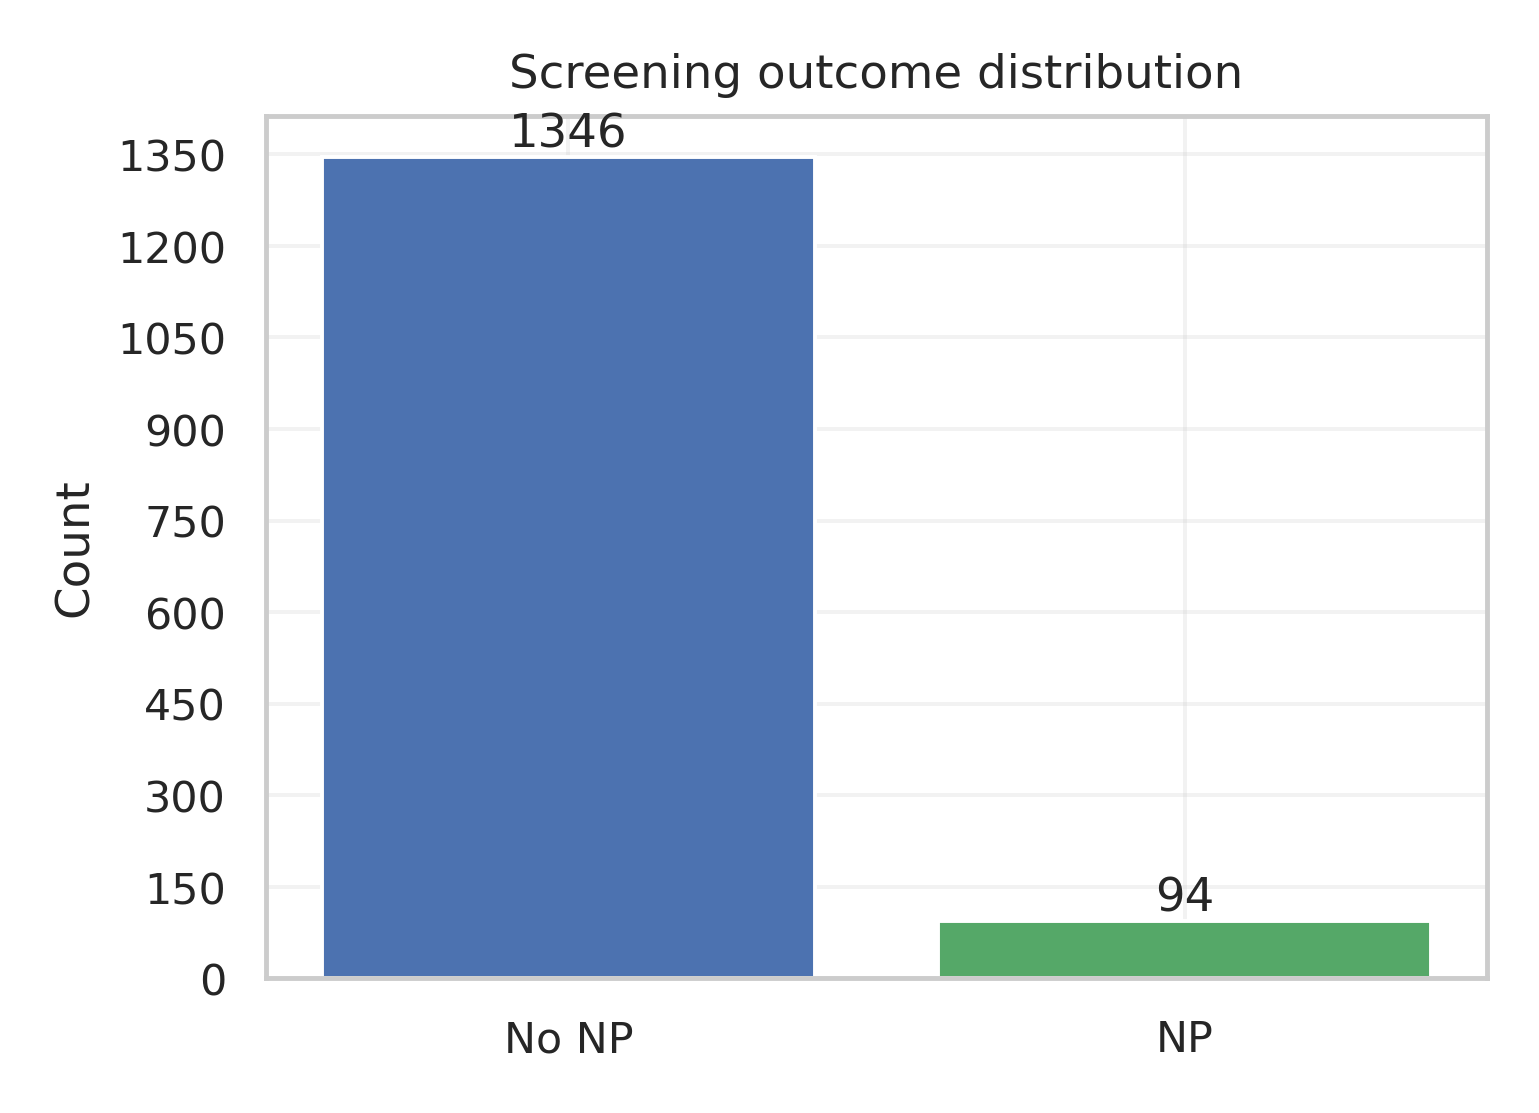

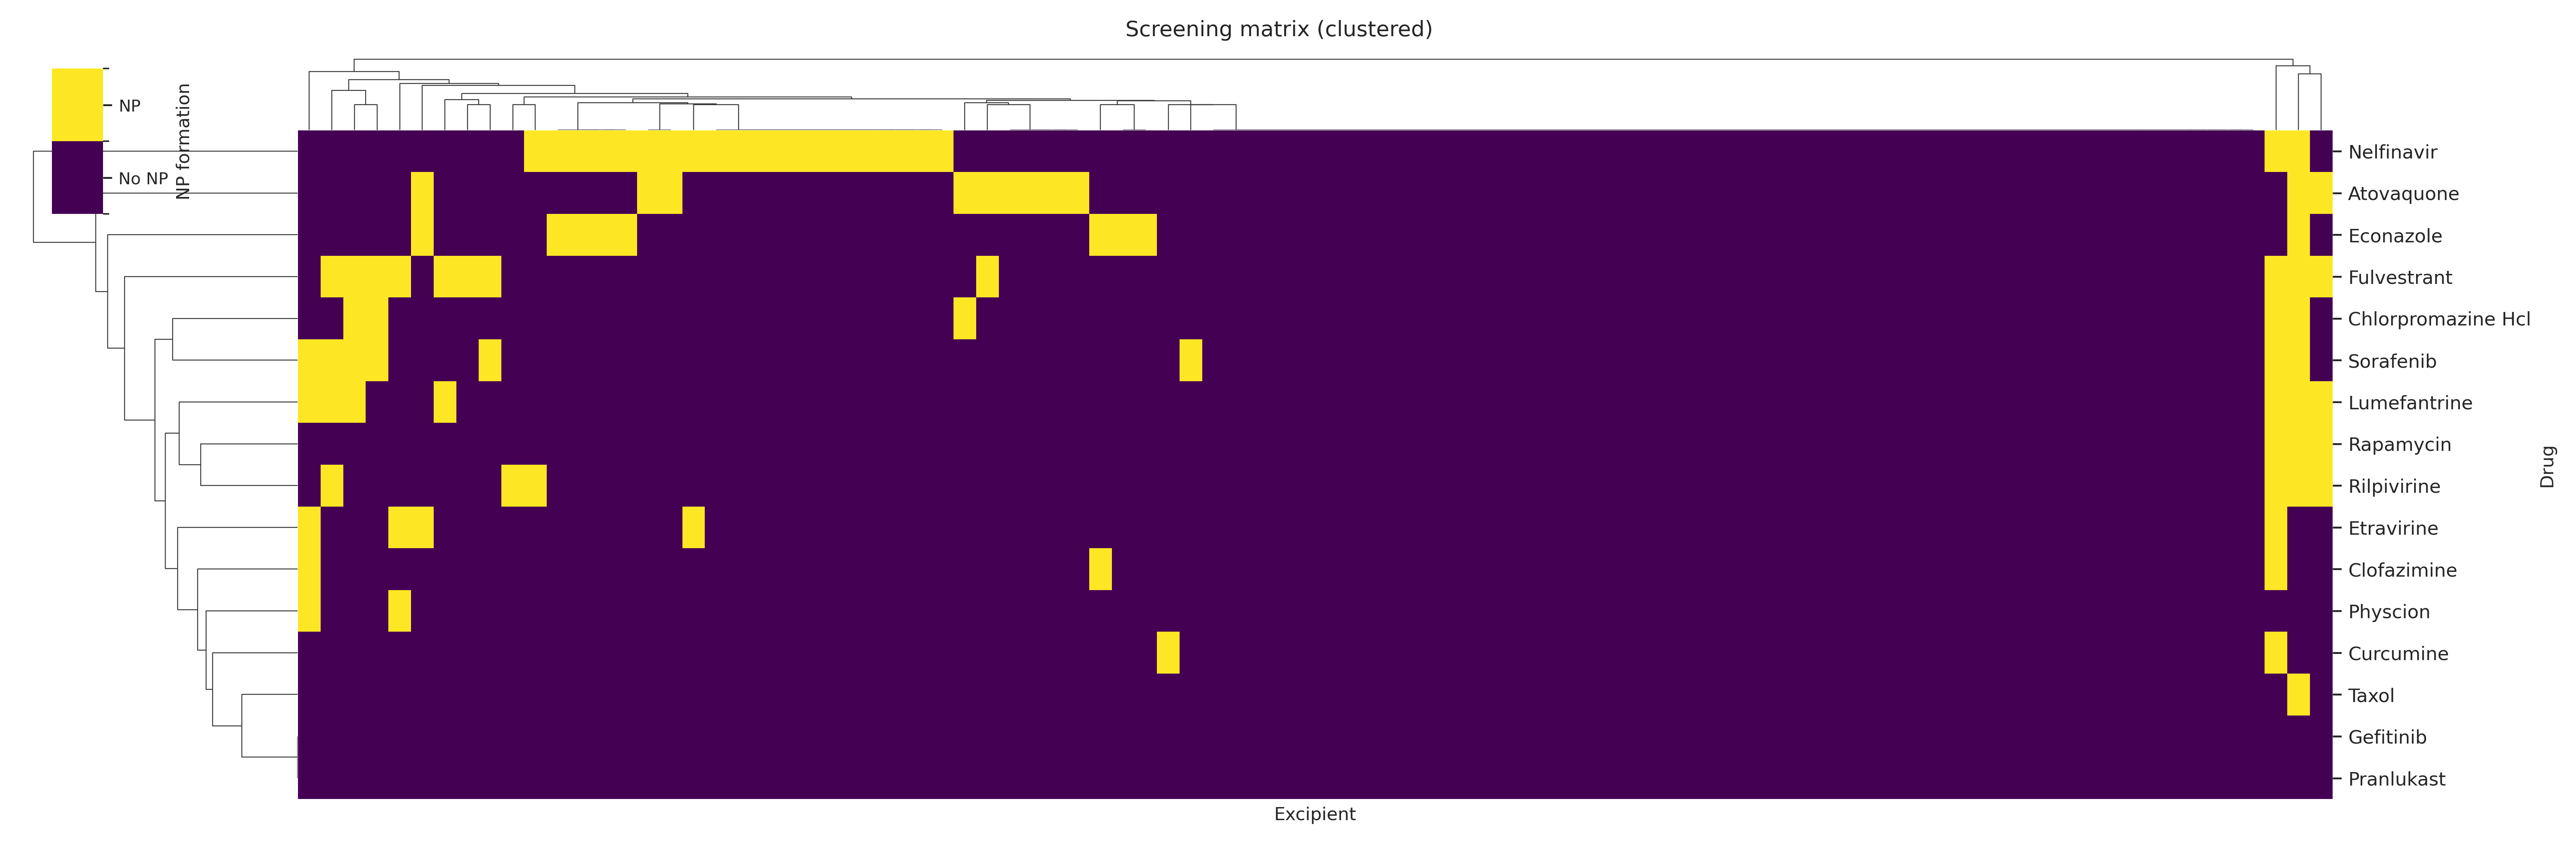

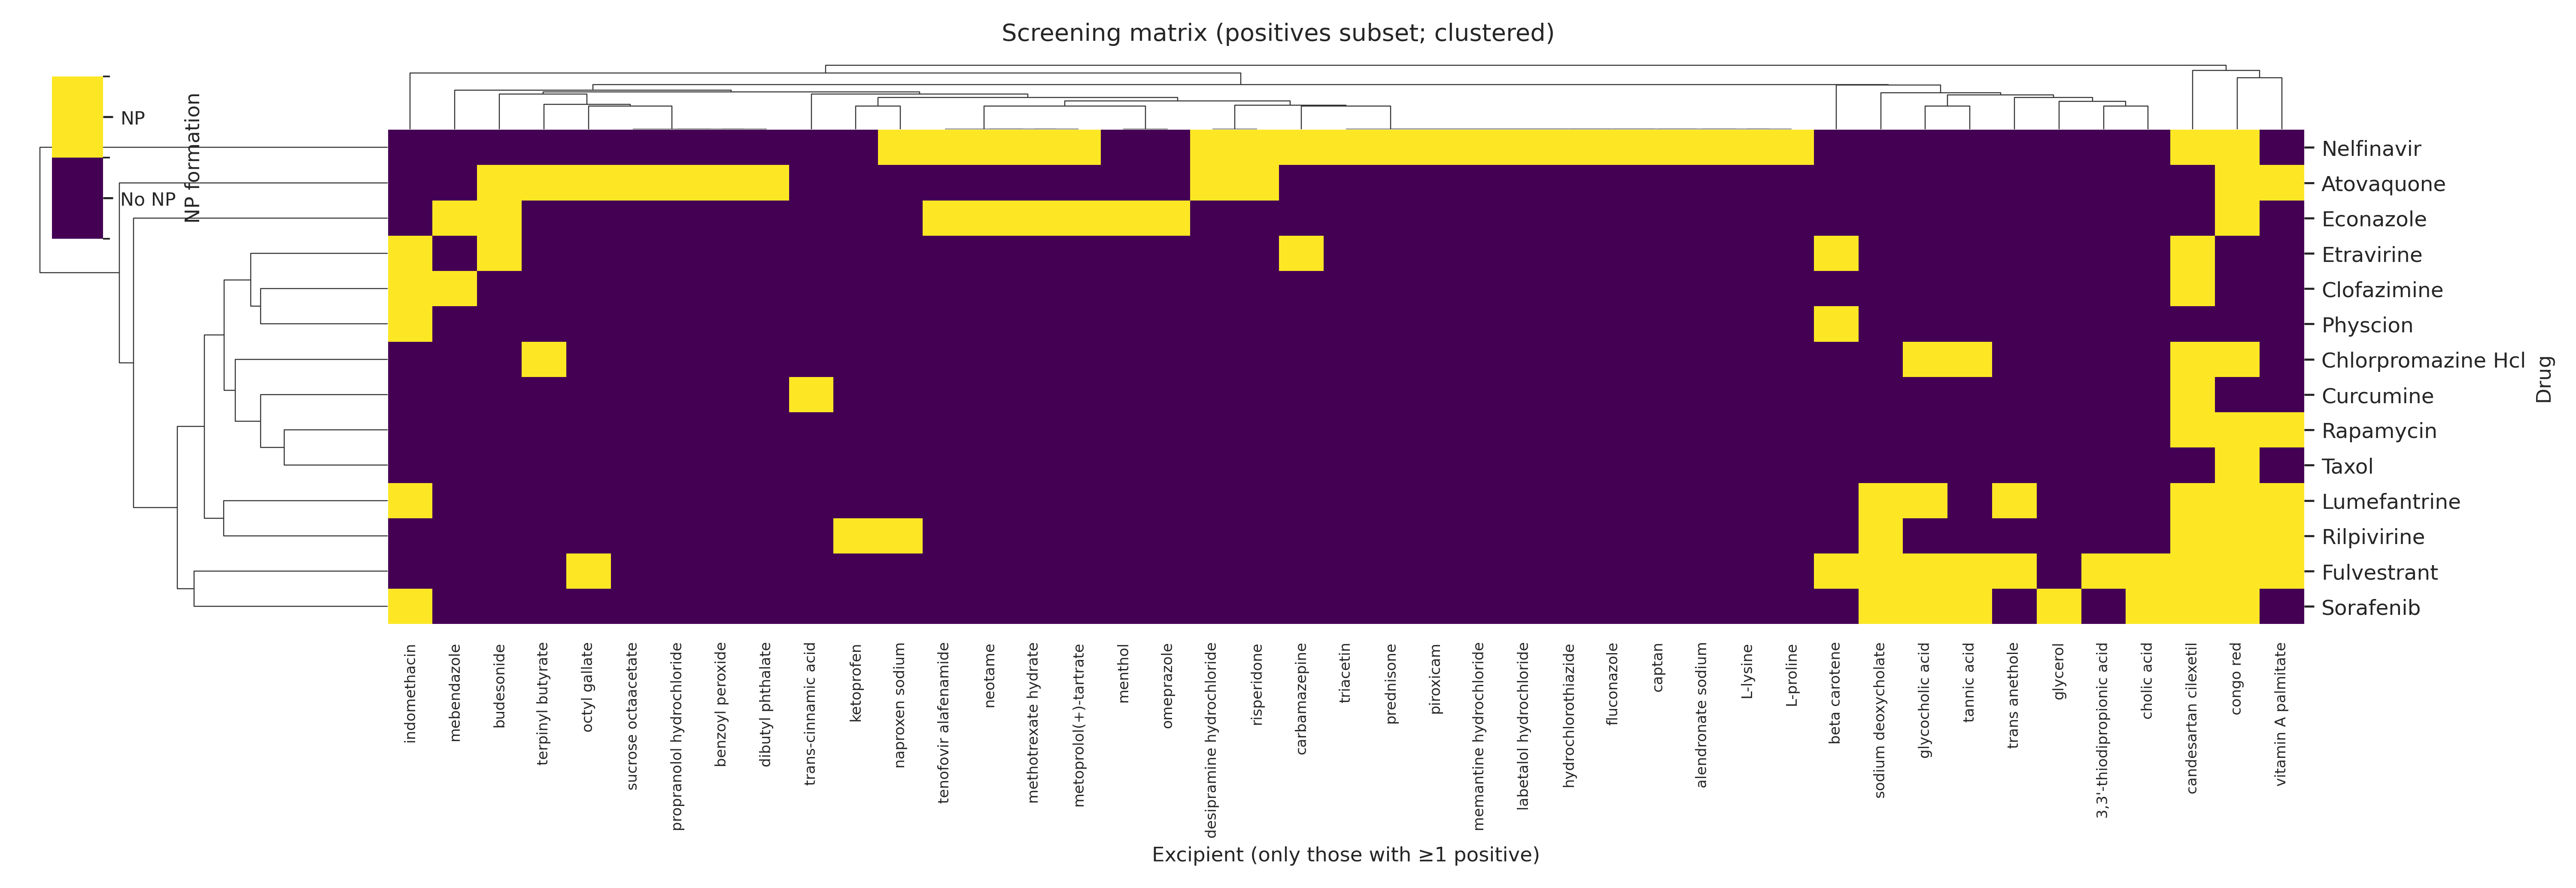

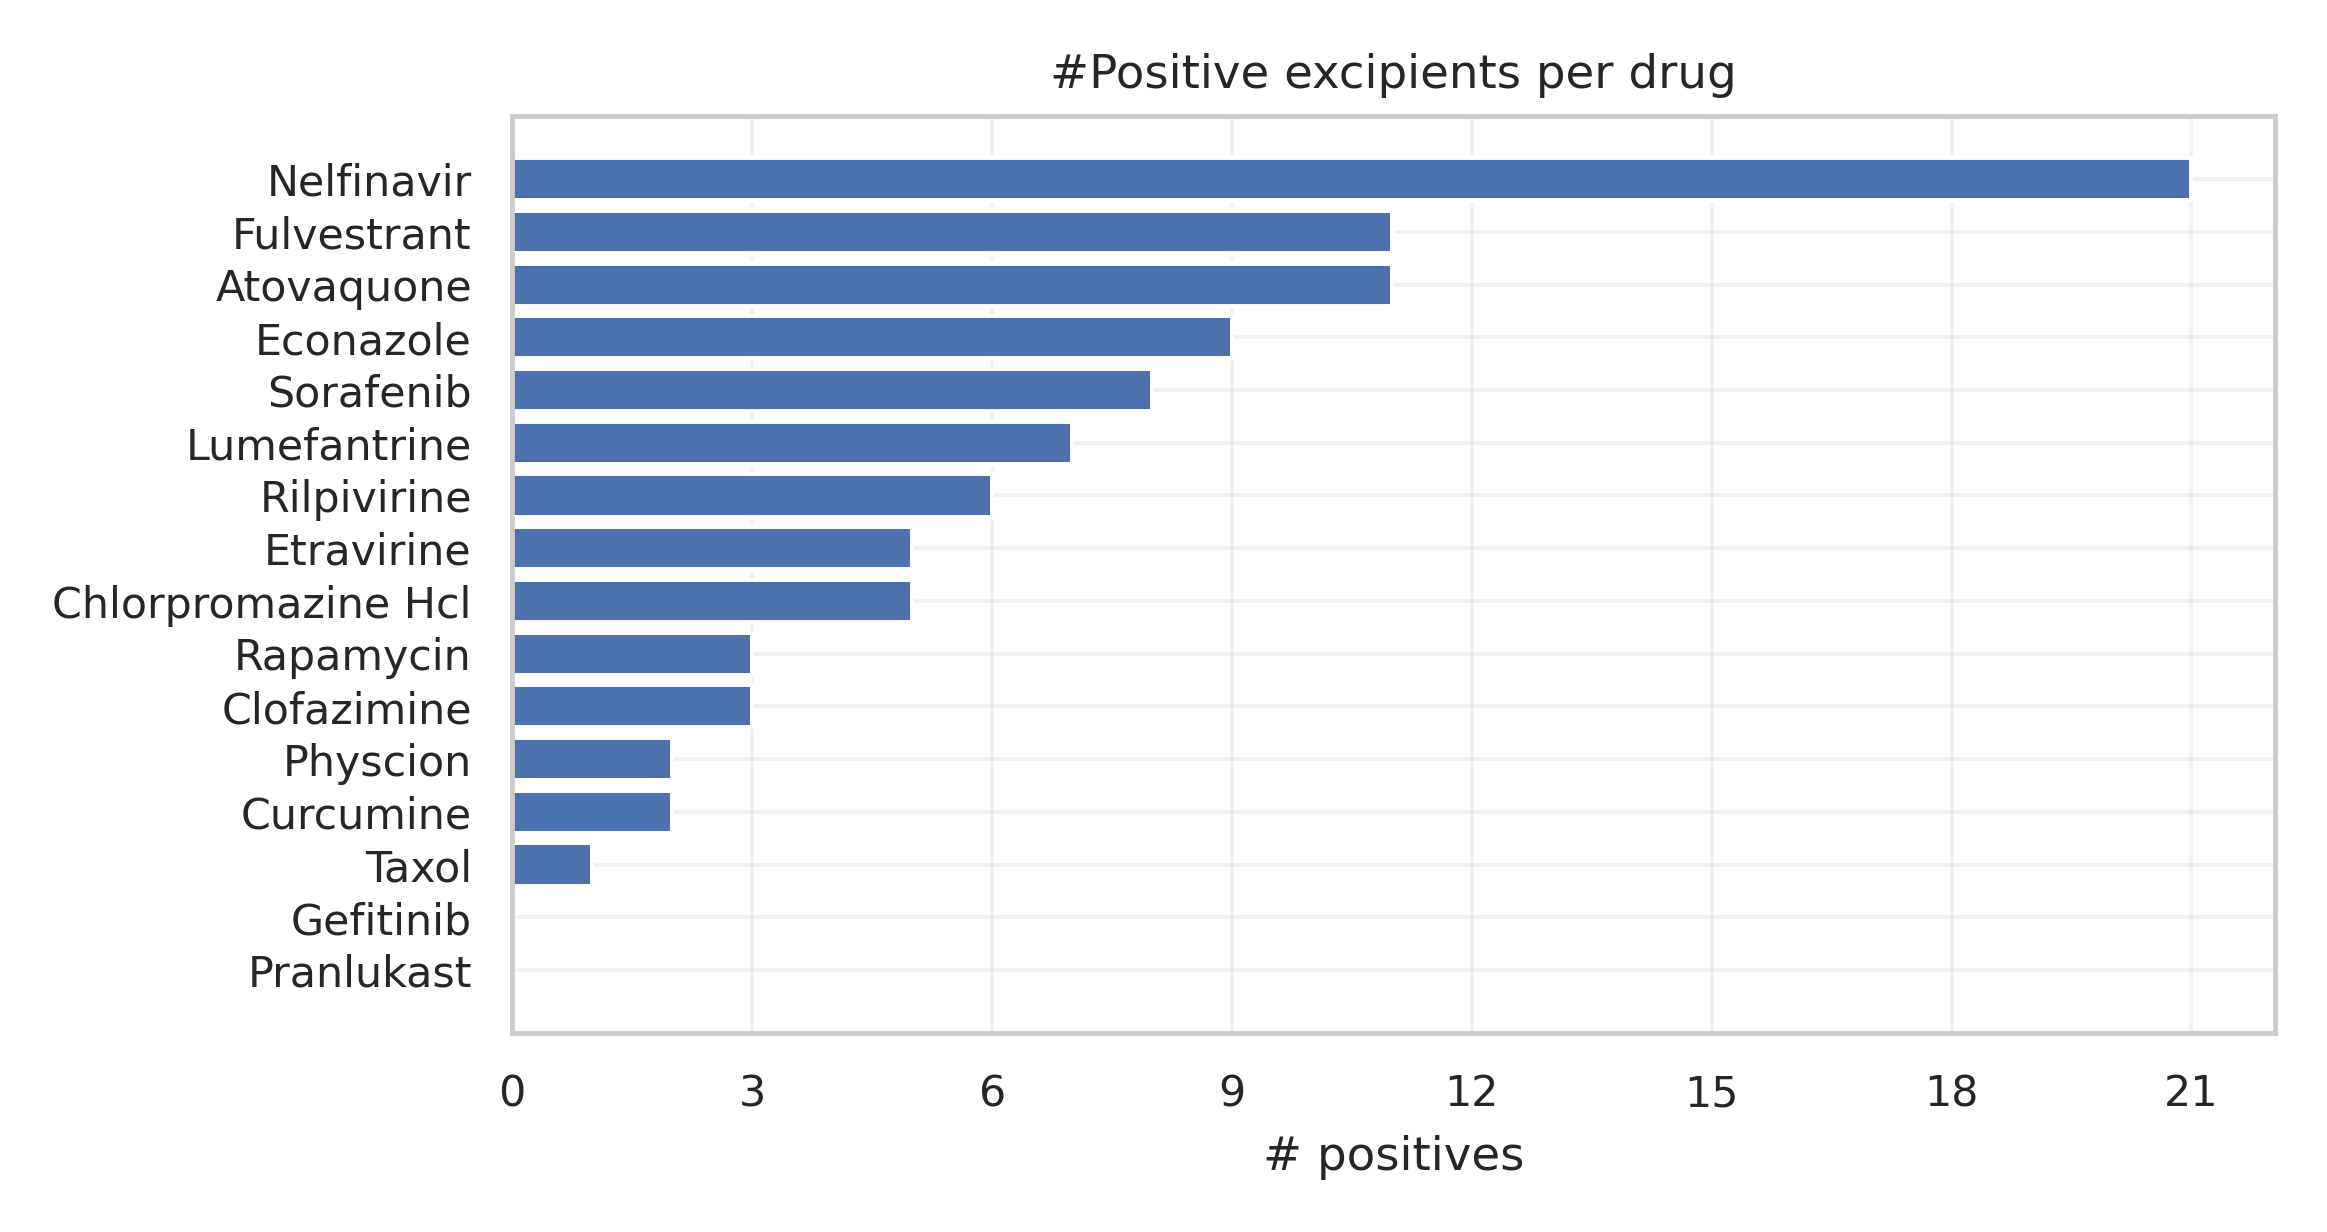

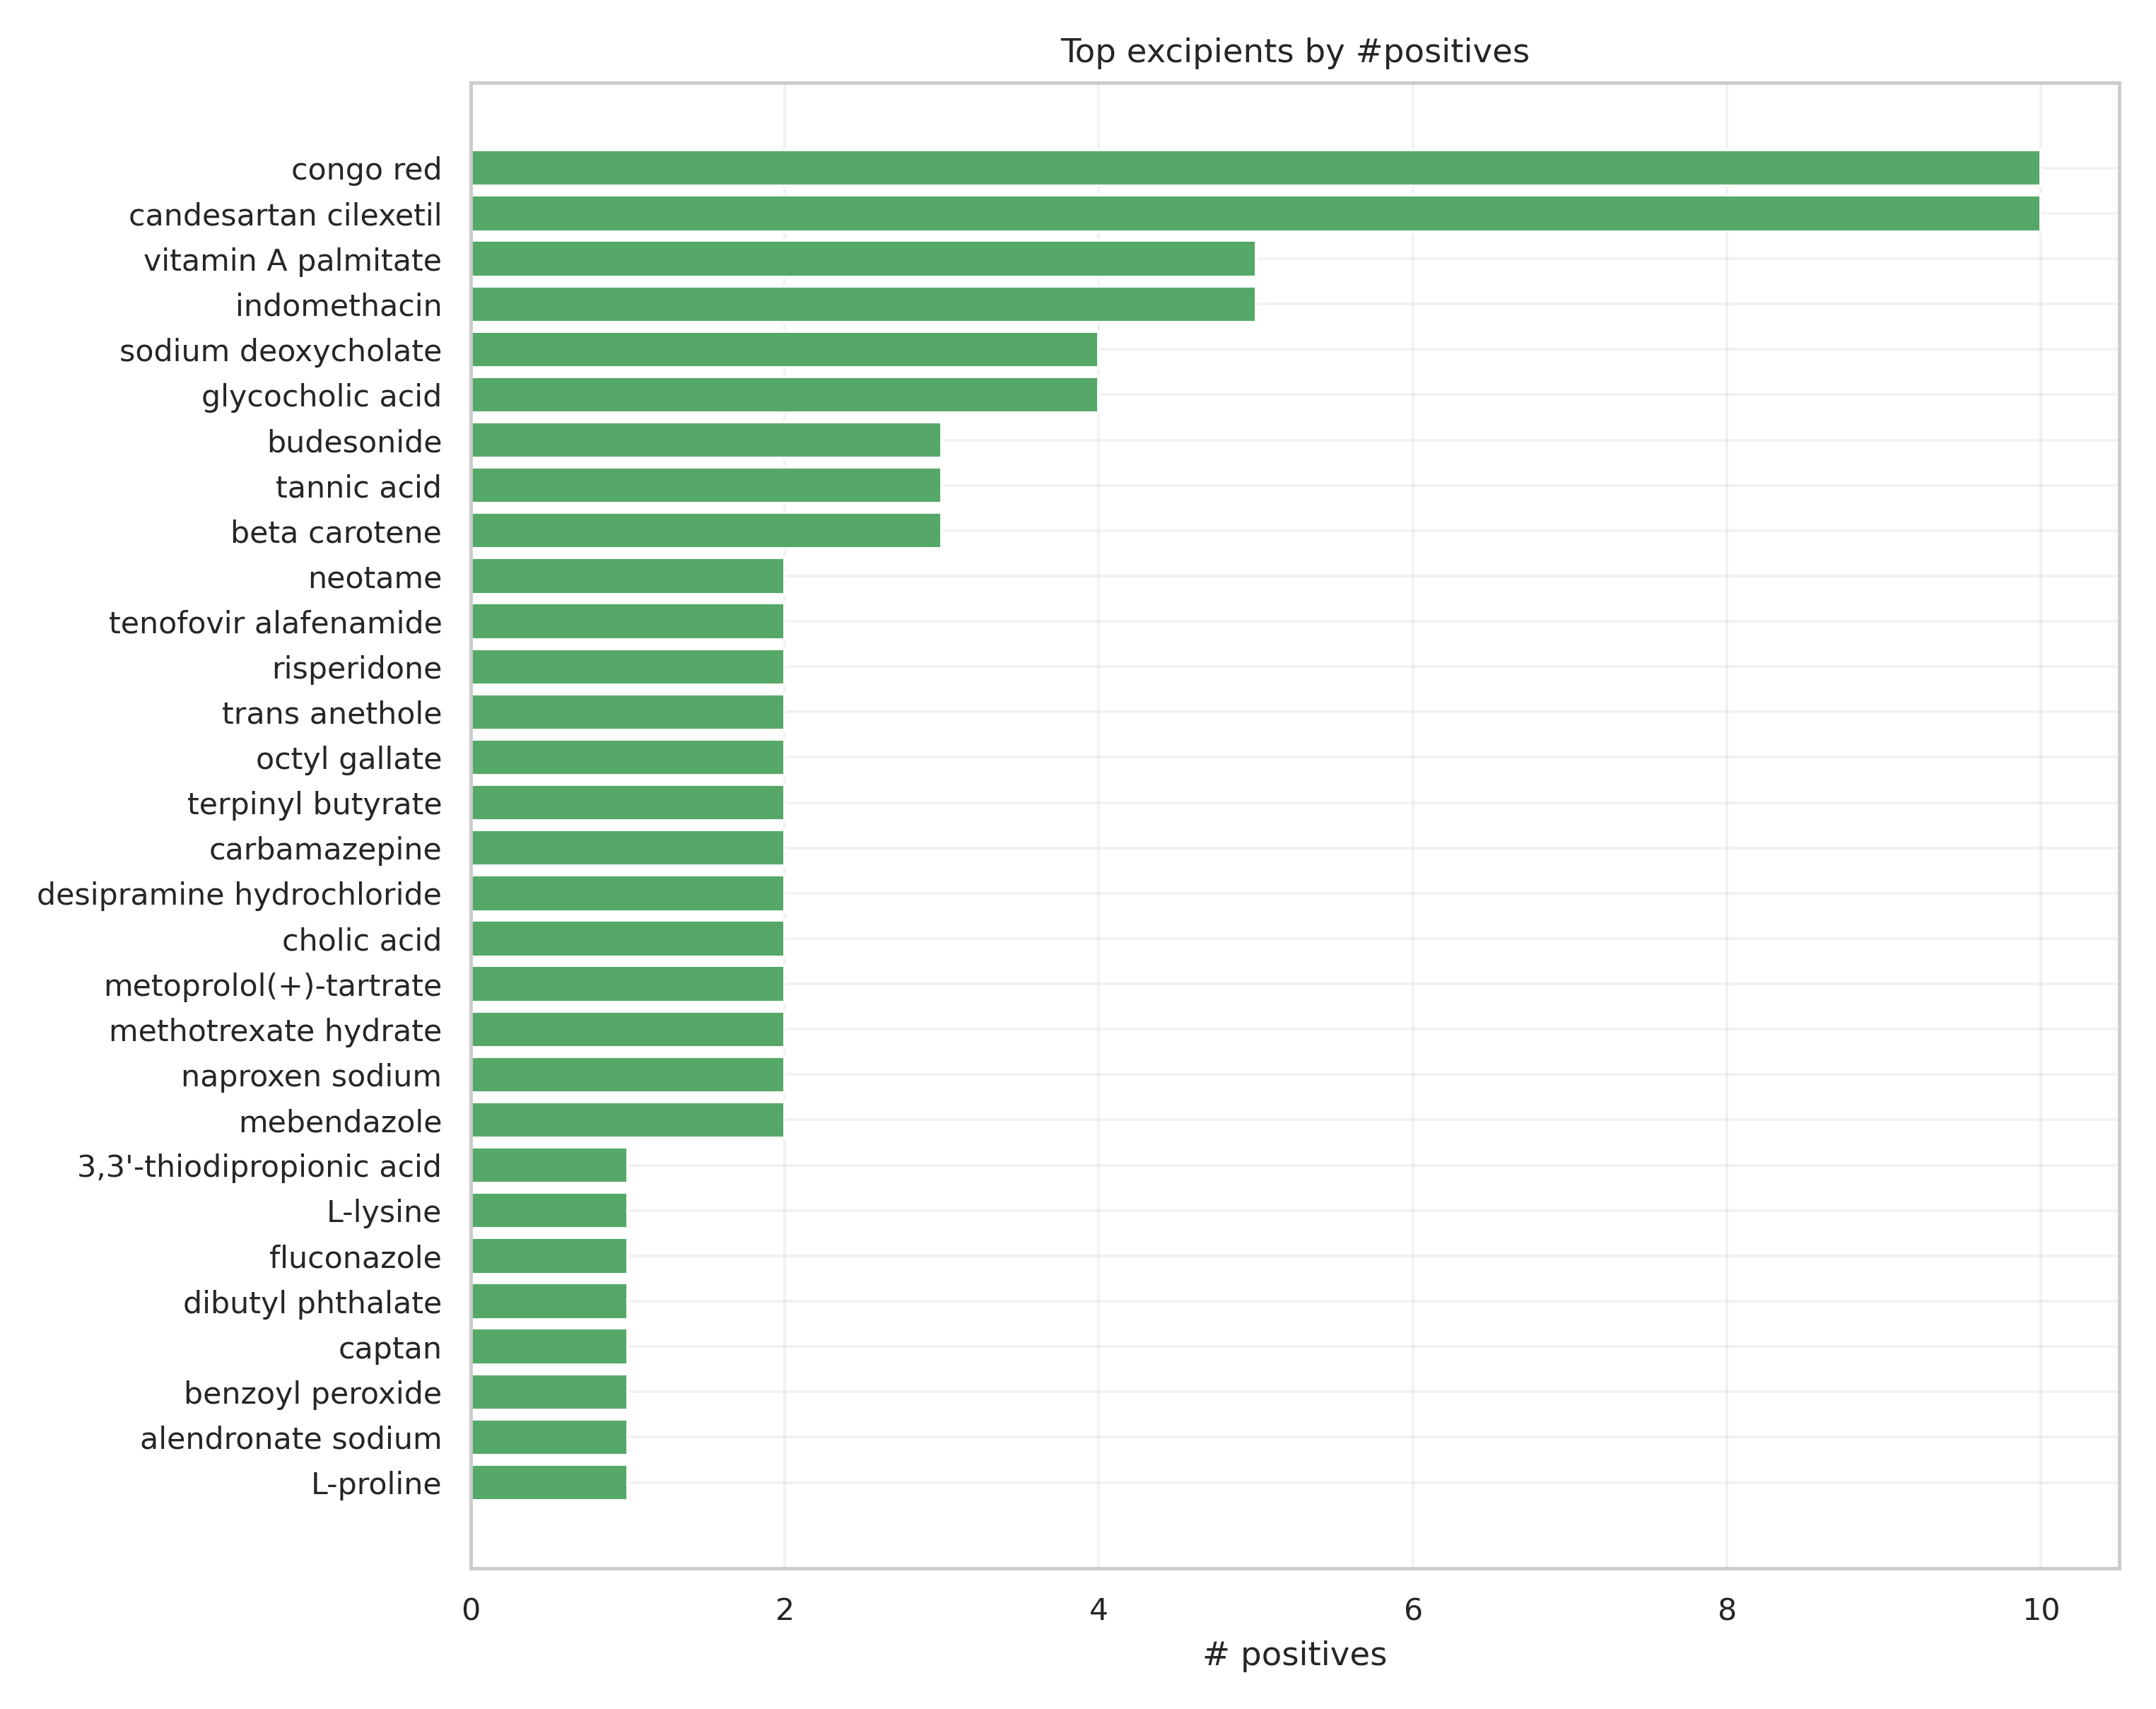

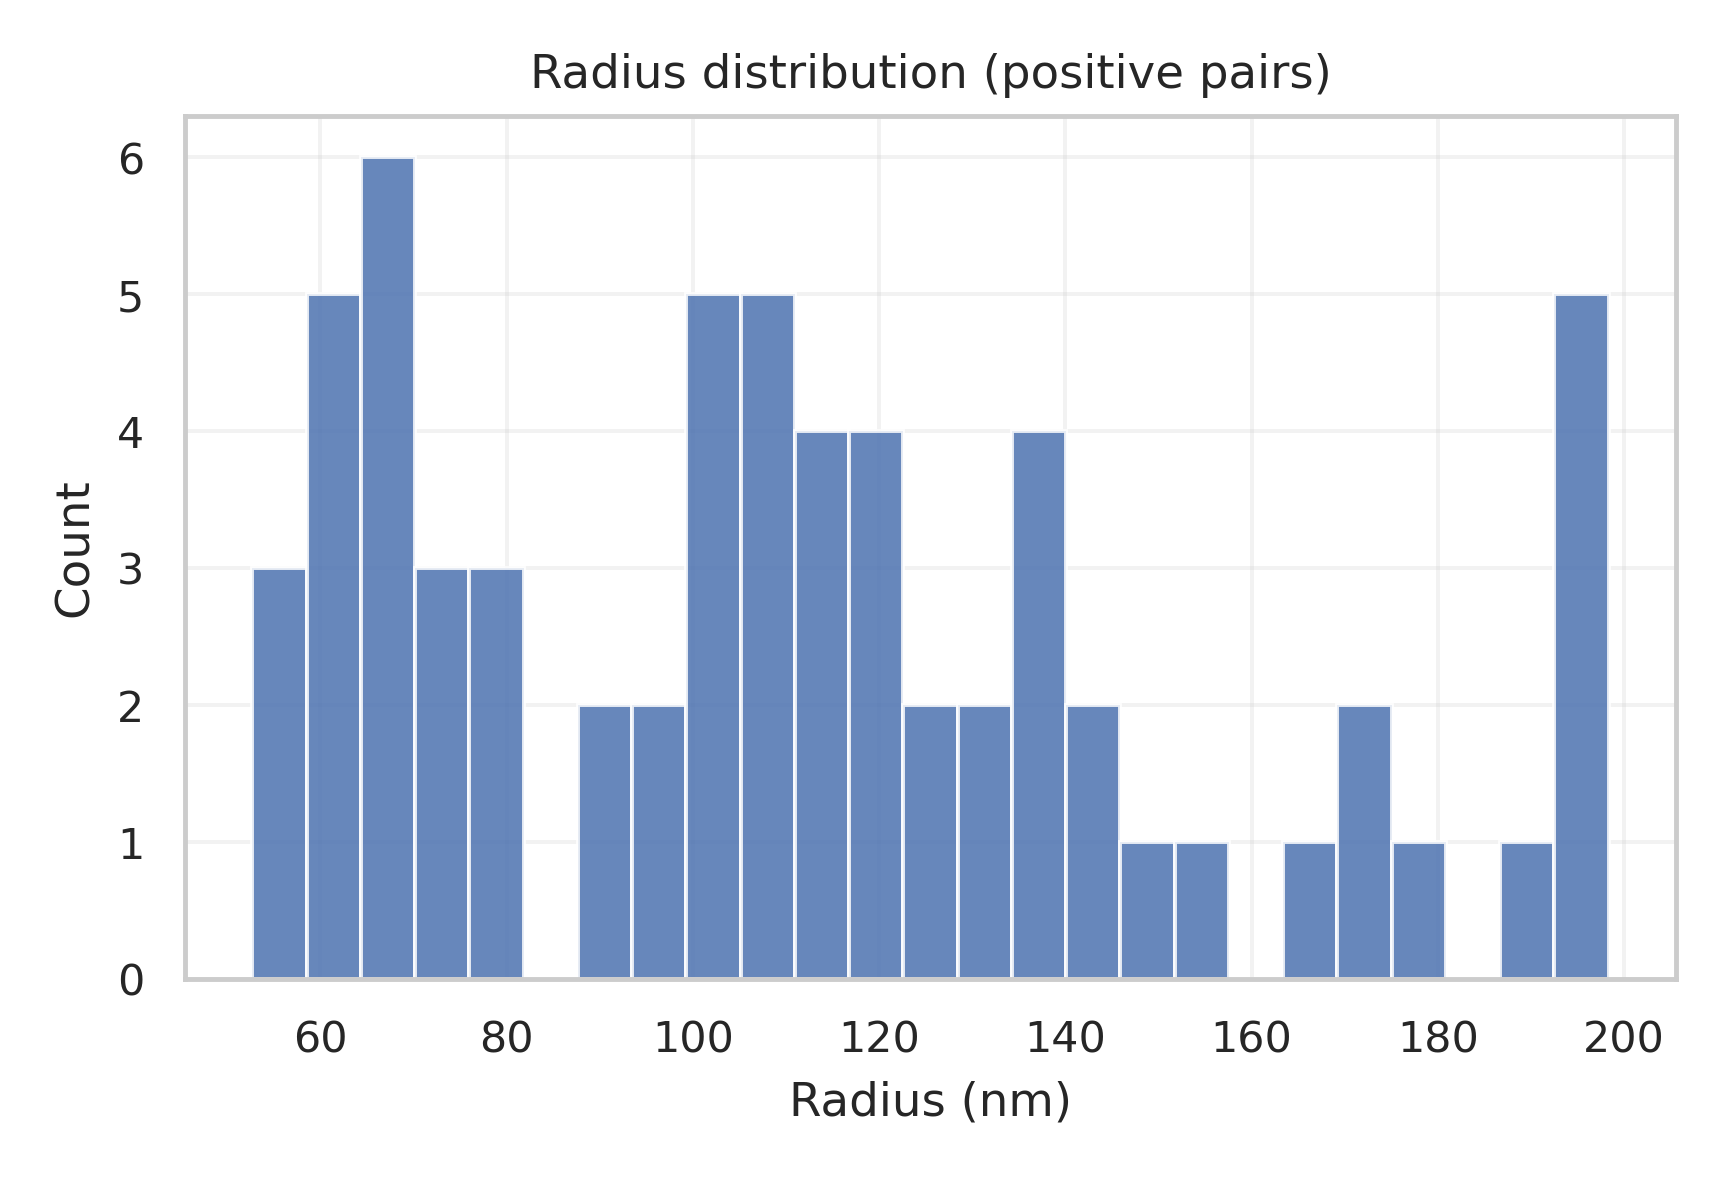

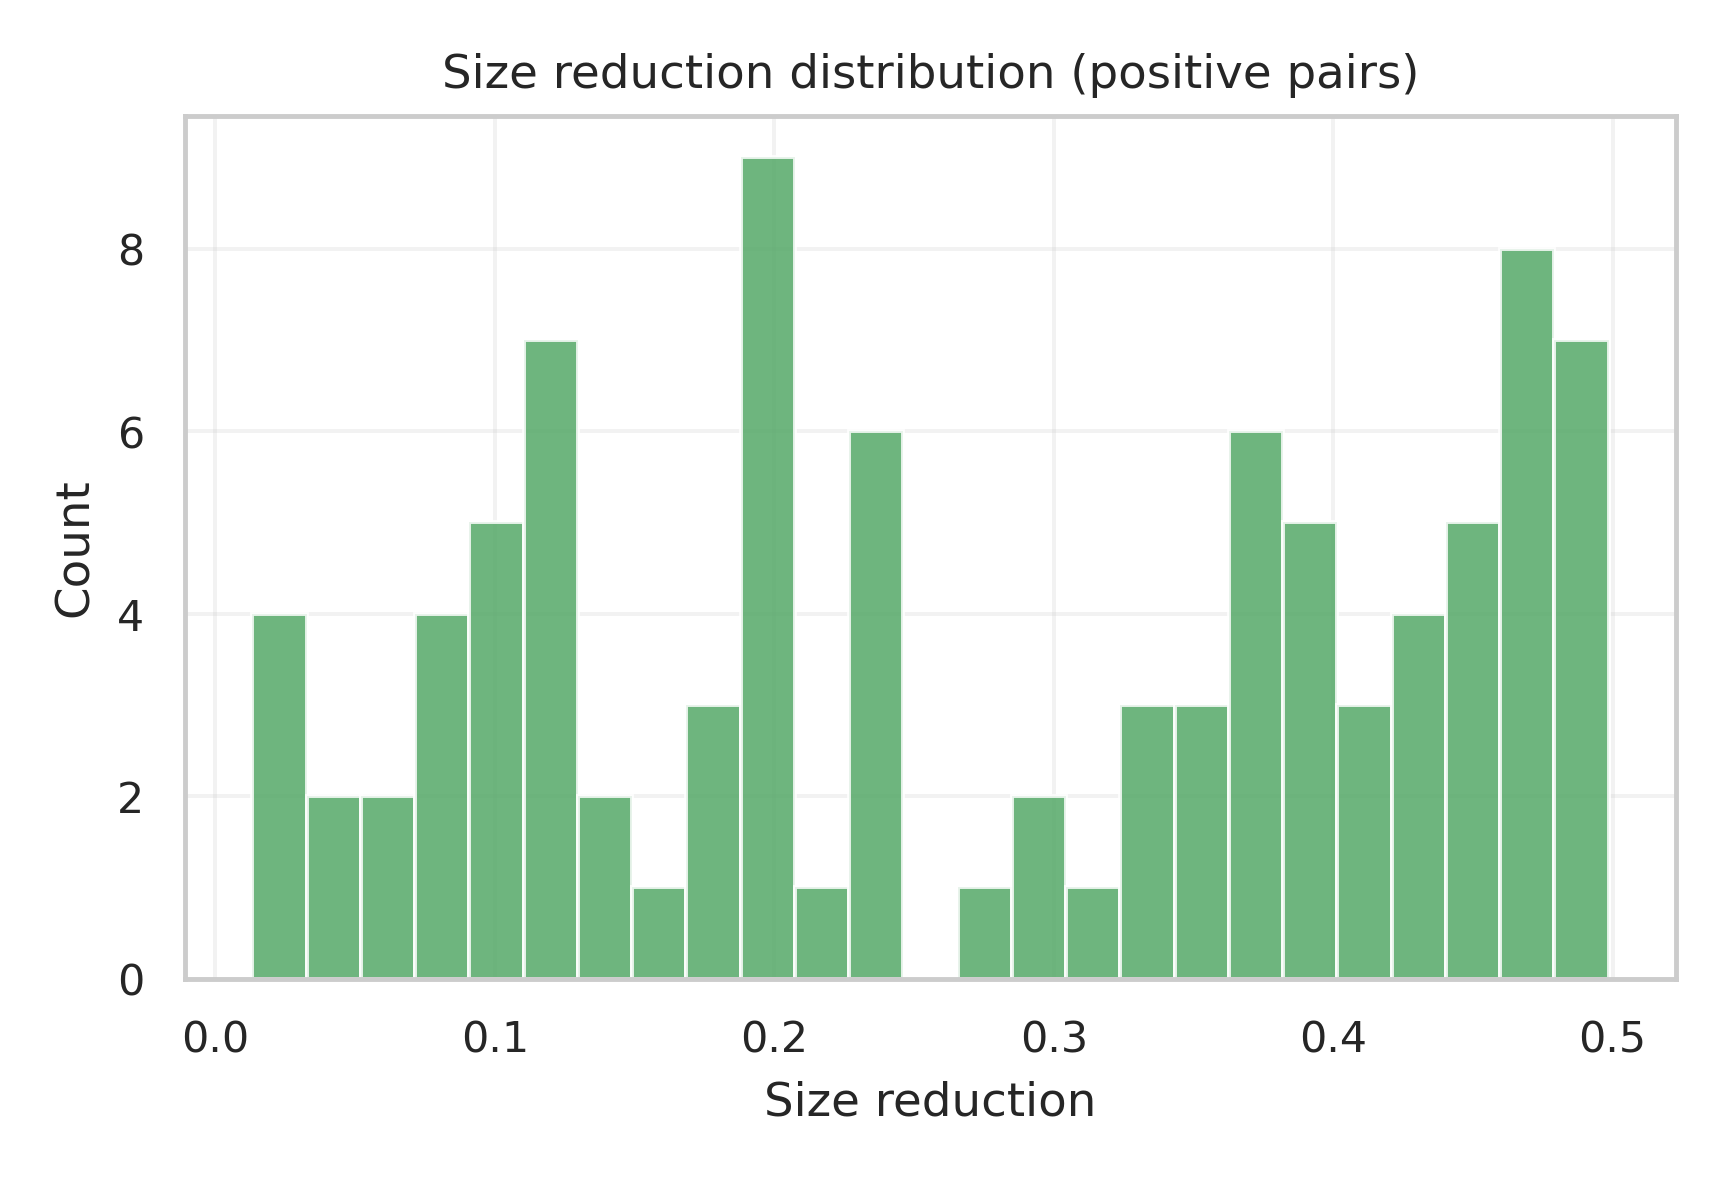

In [8]:
# 18) EDA figures (publication-friendly)
from matplotlib.ticker import MaxNLocator

# 18.1 Label distribution
fig, ax = plt.subplots(figsize=(4.5, 3.2))
counts = pairs["y_np"].value_counts().sort_index()
ax.bar([NP_LABELS[0], NP_LABELS[1]], [counts.get(0, 0), counts.get(1, 0)], color=["#4C72B0", "#55A868"])
ax.set_title("Screening outcome distribution")
ax.set_ylabel("Count")
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
for i, v in enumerate([counts.get(0, 0), counts.get(1, 0)]):
    ax.text(i, v, f"{int(v)}", ha="center", va="bottom")
savefig(fig, "eda_label_distribution")

# 18.2 Screening matrix heatmap (full)
mat = pairs.pivot_table(index="drug_name", columns="excipient_name", values="y_np", aggfunc="max")

if SNS is not None:
    cg = SNS.clustermap(
        mat.fillna(0).astype(float),
        cmap=NP_CMAP,
        norm=NP_NORM,
        figsize=(19, 6),
        cbar_kws={"label": "NP formation", "ticks": [0, 1]},
        xticklabels=False,
        yticklabels=True,
        dendrogram_ratio=(0.12, 0.10),
        cbar_pos=(0.02, 0.78, 0.02, 0.18),
    )
    cg.fig.suptitle("Screening matrix (clustered)", y=1.02)
    try:
        cg.cax.set_yticks([0, 1])
        cg.cax.set_yticklabels(NP_ORDER)
    except Exception:
        pass

    cg.ax_heatmap.set_xlabel("Excipient")
    cg.ax_heatmap.set_ylabel("Drug")
    cg.ax_heatmap.yaxis.tick_right()
    cg.ax_heatmap.yaxis.set_label_position("right")
    cg.ax_heatmap.tick_params(axis="y", labelsize=10)

    # Beautify drug labels
    cg.ax_heatmap.set_yticklabels([t.get_text().replace("_", " ") for t in cg.ax_heatmap.get_yticklabels()])

    out_png = FIG_DIR / "eda_screening_matrix_clustered.png"
    cg.fig.savefig(out_png, dpi=350, bbox_inches="tight")
    try:
        cg.fig.savefig(FIG_DIR / "eda_screening_matrix_clustered.pdf", bbox_inches="tight")
    except Exception:
        pass
    show_image(out_png, width=1600)
    plt.close(cg.fig)
else:
    fig, ax = plt.subplots(figsize=(14, 4.8))
    im = ax.imshow(mat.fillna(0).to_numpy(), aspect="auto", cmap=NP_CMAP, norm=NP_NORM)
    ax.set_title("Screening matrix")
    ax.set_ylabel("Drug")
    ax.set_xlabel("Excipient")
    ax.set_yticks(np.arange(mat.shape[0]))
    ax.set_yticklabels([str(x).replace("_", " ") for x in mat.index])
    ax.set_xticks([])
    cbar = fig.colorbar(im, ax=ax, ticks=[0, 1])
    cbar.ax.set_yticklabels(NP_ORDER)
    cbar.set_label("NP formation")
    savefig(fig, "eda_screening_matrix")

# 18.2b Positives-only matrix (smaller, with readable excipient labels)
pos_edges = pairs[pairs["y_np"] == 1][["drug_name", "excipient_name"]].drop_duplicates()
pos_drugs = sorted(pos_edges["drug_name"].unique())
pos_excs = sorted(pos_edges["excipient_name"].unique())
mat_pos = mat.loc[pos_drugs, pos_excs].fillna(0).astype(float)

if SNS is not None:
    cg2 = SNS.clustermap(
        mat_pos,
        cmap=NP_CMAP,
        norm=NP_NORM,
        figsize=(17, 6),
        cbar_kws={"label": "NP formation", "ticks": [0, 1]},
        xticklabels=True,
        yticklabels=True,
        dendrogram_ratio=(0.16, 0.12),
        cbar_pos=(0.02, 0.78, 0.02, 0.18),
    )
    cg2.fig.suptitle("Screening matrix (positives subset; clustered)", y=1.02)
    try:
        cg2.cax.set_yticks([0, 1])
        cg2.cax.set_yticklabels(NP_ORDER)
    except Exception:
        pass

    cg2.ax_heatmap.set_xlabel("Excipient (only those with ≥1 positive)")
    cg2.ax_heatmap.set_ylabel("Drug")
    cg2.ax_heatmap.yaxis.tick_right()
    cg2.ax_heatmap.yaxis.set_label_position("right")

    cg2.ax_heatmap.set_xticklabels(
        [t.get_text().replace("_", " ") for t in cg2.ax_heatmap.get_xticklabels()],
        rotation=90,
        fontsize=7,
    )
    cg2.ax_heatmap.set_yticklabels([t.get_text().replace("_", " ") for t in cg2.ax_heatmap.get_yticklabels()], fontsize=10)

    out_png = FIG_DIR / "eda_screening_matrix_positiveonly_clustered.png"
    cg2.fig.savefig(out_png, dpi=350, bbox_inches="tight")
    try:
        cg2.fig.savefig(FIG_DIR / "eda_screening_matrix_positiveonly_clustered.pdf", bbox_inches="tight")
    except Exception:
        pass
    show_image(out_png, width=1600)
    plt.close(cg2.fig)
else:
    fig, ax = plt.subplots(figsize=(13.5, 4.8))
    im = ax.imshow(mat_pos.to_numpy(), aspect="auto", cmap=NP_CMAP, norm=NP_NORM)
    ax.set_title("Screening matrix (positives subset)")
    ax.set_ylabel("Drug")
    ax.set_xlabel("Excipient")
    ax.set_yticks(np.arange(mat_pos.shape[0]))
    ax.set_yticklabels([str(x).replace("_", " ") for x in mat_pos.index])
    ax.set_xticks(np.arange(mat_pos.shape[1]))
    ax.set_xticklabels([str(x).replace("_", " ") for x in mat_pos.columns], rotation=90, fontsize=7)
    cbar = fig.colorbar(im, ax=ax, ticks=[0, 1])
    cbar.ax.set_yticklabels(NP_ORDER)
    cbar.set_label("NP formation")
    savefig(fig, "eda_screening_matrix_positiveonly")

# 18.3 Positives per drug
fig, ax = plt.subplots(figsize=(6.5, 3.4))
tmp = by_drug.sort_values("n_pos", ascending=True)
ax.barh([str(x).replace("_", " ") for x in tmp["drug_name"]], tmp["n_pos"], color="#4C72B0")
ax.set_title("#Positive excipients per drug")
ax.set_xlabel("# positives")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
savefig(fig, "eda_positives_by_drug")

# 18.4 Positives per excipient (Top 30)
fig, ax = plt.subplots(figsize=(8.6, 7.8))
tmp = by_exc.head(30).sort_values("n_pos", ascending=True)
ax.barh([str(x).replace("_", " ") for x in tmp["excipient_name"]], tmp["n_pos"], color="#55A868")
ax.set_title("Top excipients by #positives")
ax.set_xlabel("# positives")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
savefig(fig, "eda_top_excipients_by_positives", width=1400)

# 18.5 Continuous label distributions (where available)
pos = pairs[pairs["y_np"] == 1].copy()
if pos["y_radius_nm"].notna().any():
    fig, ax = plt.subplots(figsize=(5.5, 3.2))
    vals = pos["y_radius_nm"].dropna().astype(float)
    ax.hist(vals, bins=25, color="#4C72B0", alpha=0.85)
    ax.set_title("Radius distribution (positive pairs)")
    ax.set_xlabel("Radius (nm)")
    ax.set_ylabel("Count")
    savefig(fig, "eda_radius_distribution")

if pos["y_size_reduction"].notna().any():
    fig, ax = plt.subplots(figsize=(5.5, 3.2))
    vals = pos["y_size_reduction"].dropna().astype(float)
    ax.hist(vals, bins=25, color="#55A868", alpha=0.85)
    ax.set_title("Size reduction distribution (positive pairs)")
    ax.set_xlabel("Size reduction")
    ax.set_ylabel("Count")
    savefig(fig, "eda_size_reduction_distribution")


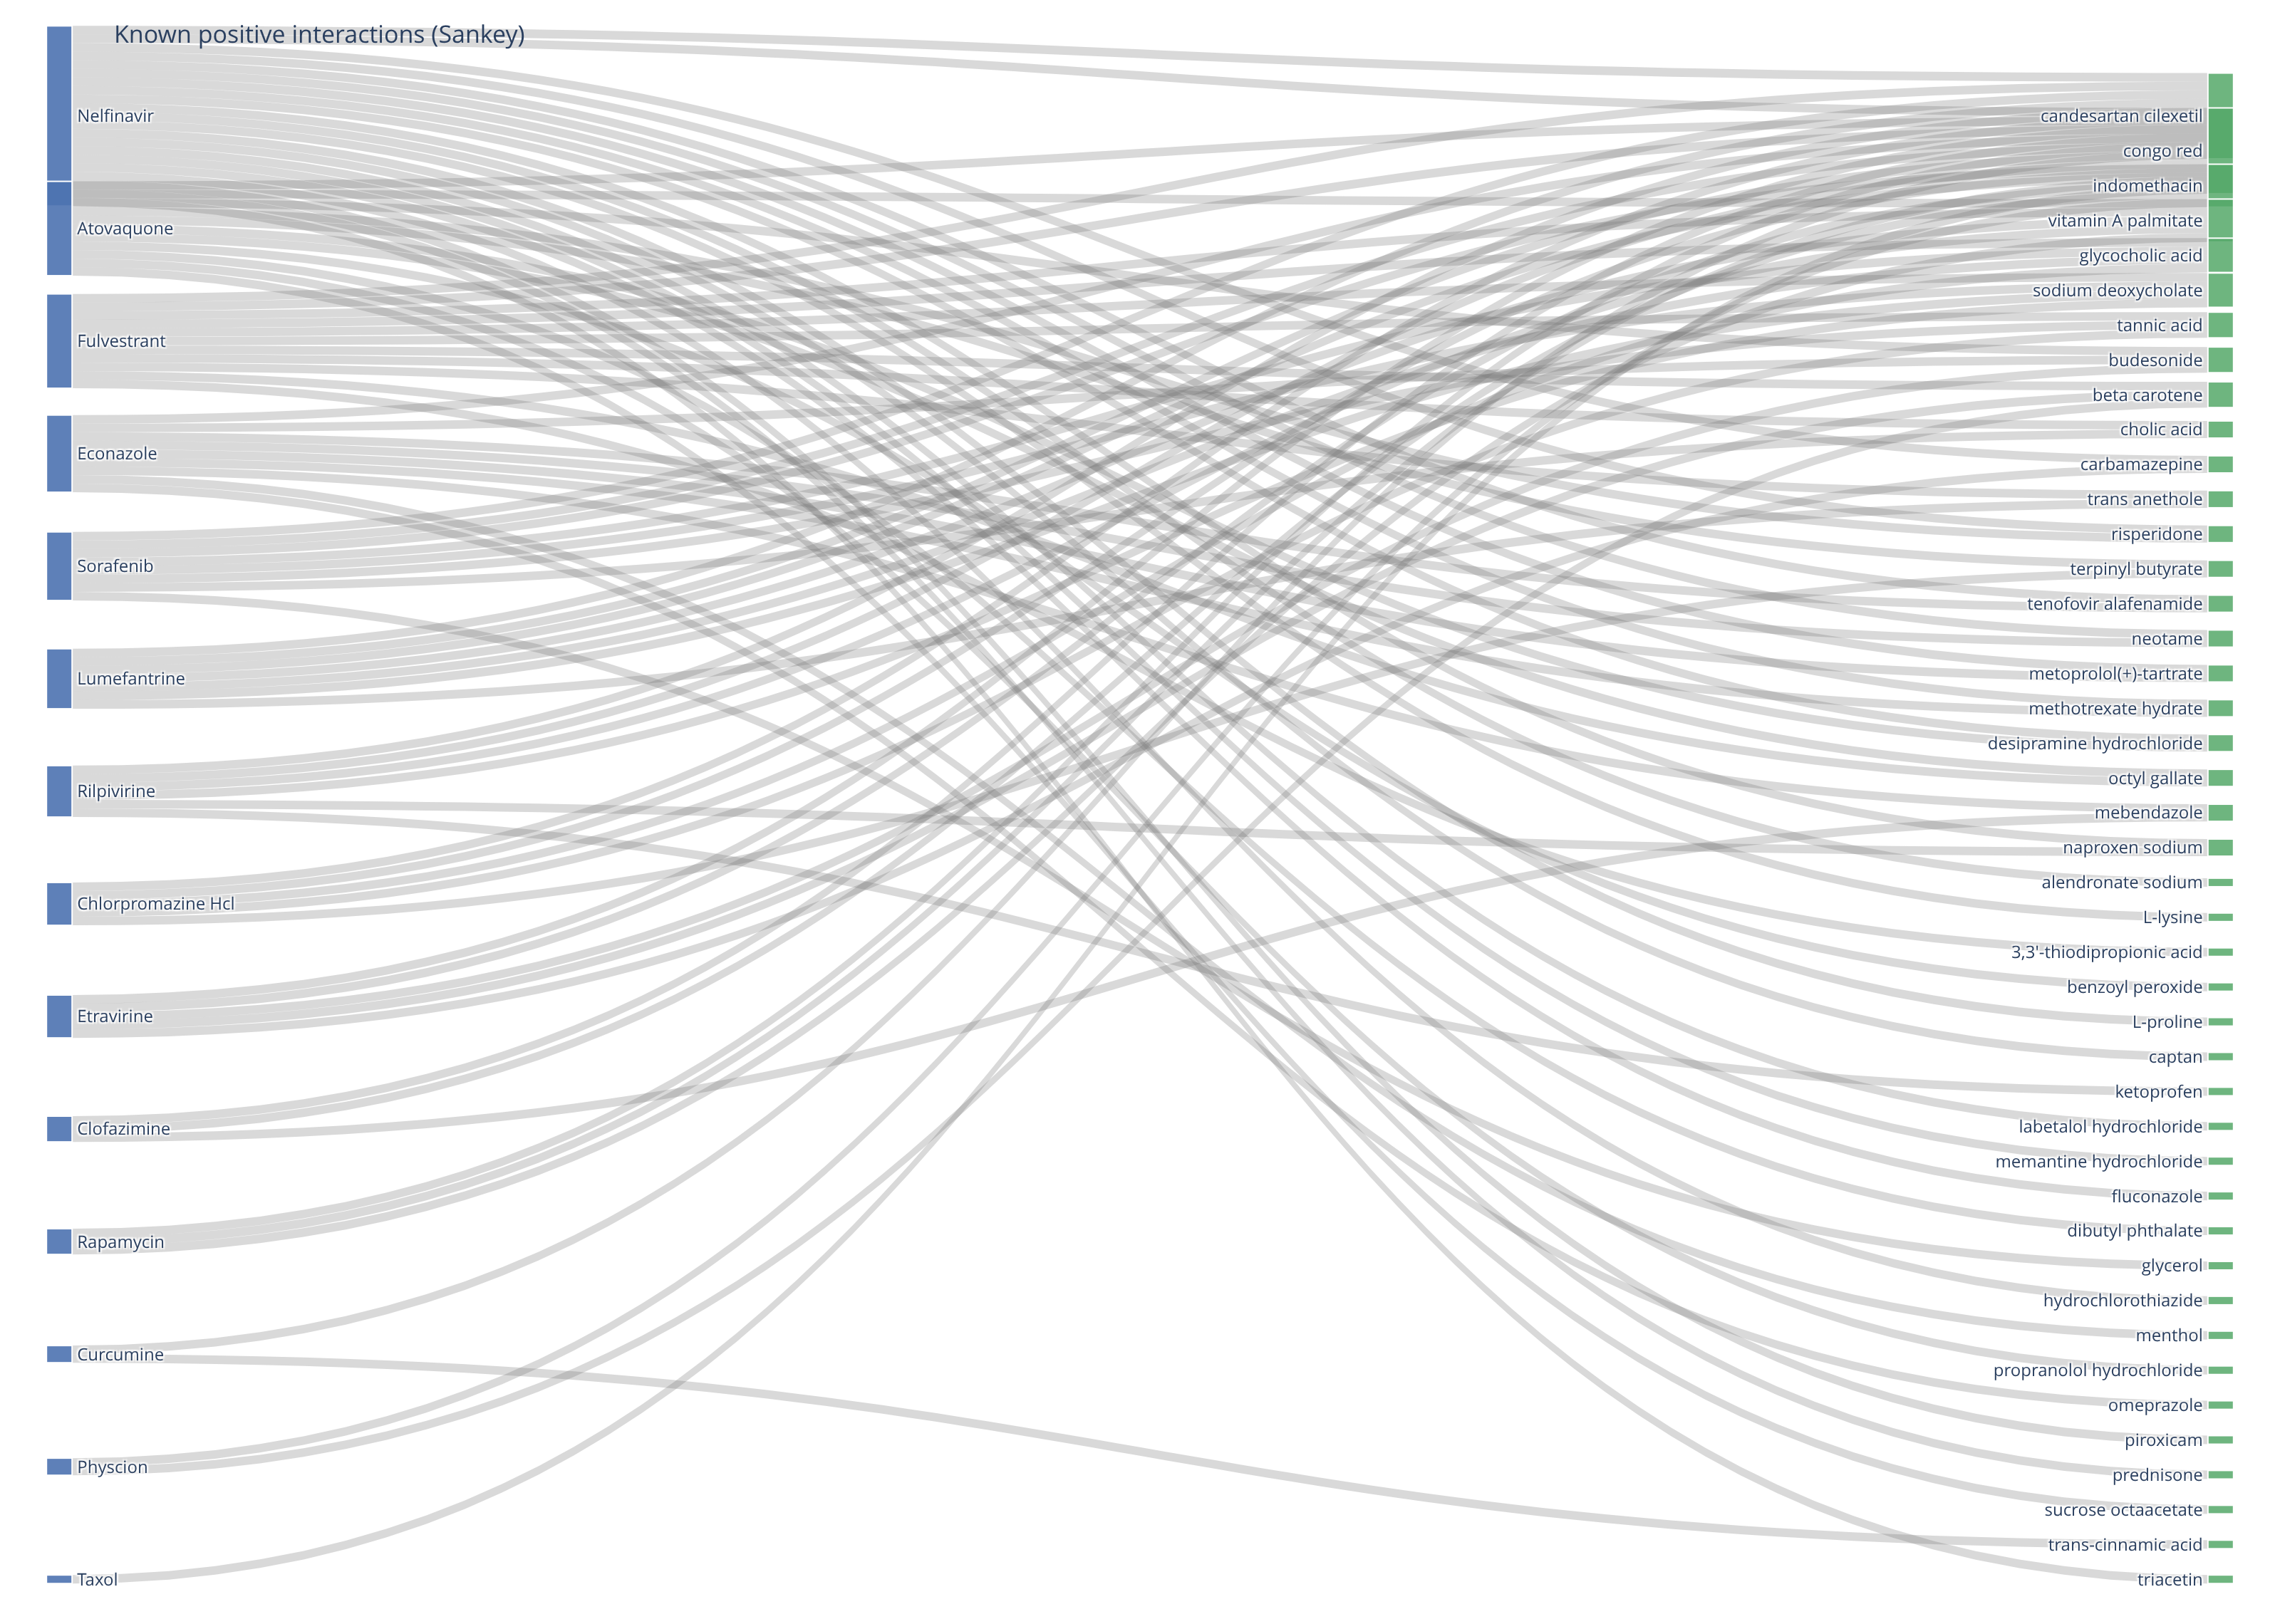

Figures: 37  Tables: 17


(['chemspace_pca_selected.png',
  'chemspace_pca_selected_full_range.png',
  'chemspace_pca_selected_zoomed.png',
  'eda_label_distribution.png',
  'eda_positives_by_drug.png',
  'eda_radius_distribution.png',
  'eda_screening_matrix_clustered.png',
  'eda_screening_matrix_positiveonly_clustered.png',
  'eda_size_reduction_distribution.png',
  'eda_top_excipients_by_positives.png'],
 ['dataset_overview.csv',
  'external_pareto_front.csv',
  'external_ranked_candidates_top500.csv',
  'gromacs_assembly_summary.csv',
  'gromacs_job_manifest.csv',
  'model_cls_threshold_sweep.csv',
  'positives_by_drug.csv',
  'positives_by_excipient.csv',
  'radius_meta_feature_set_ranking.csv',
  'radius_meta_model_selection.csv'])

In [9]:
# 24) Known positive interactions (Sankey; fallback to network graph)
# Motivation: the bipartite network can become unreadable (legend overlap / faint edges).
# This Sankey view makes the drug->excipient links explicit and scales better.

import numpy as np

# Unique positive edges (each pair counted once)
edges = pairs[pairs["y_np"] == 1][["drug_name", "excipient_name"]].dropna().drop_duplicates()
edge_counts = (
    edges.groupby(["drug_name", "excipient_name"]).size().reset_index(name="value")
)

# Order nodes by degree (reduces crossings and improves readability)
deg_d = edge_counts.groupby("drug_name")["value"].sum().sort_values(ascending=False)
deg_e = edge_counts.groupby("excipient_name")["value"].sum().sort_values(ascending=False)

drug_nodes = deg_d.index.tolist()
exc_nodes = deg_e.index.tolist()

try:
    import plotly.graph_objects as go
except Exception:
    go = None

if go is not None and edge_counts.shape[0] > 0:
    d_idx = {n: i for i, n in enumerate(drug_nodes)}
    e_idx = {n: i for i, n in enumerate(exc_nodes)}

    sources = [d_idx[r["drug_name"]] for _, r in edge_counts.iterrows()]
    targets = [len(drug_nodes) + e_idx[r["excipient_name"]] for _, r in edge_counts.iterrows()]
    values = edge_counts["value"].astype(int).tolist()

    labels = [str(n).replace("_", " ") for n in drug_nodes] + [
        str(n).replace("_", " ") for n in exc_nodes
    ]
    node_colors = ["rgba(76,114,176,0.90)"] * len(drug_nodes) + ["rgba(85,168,104,0.85)"] * len(exc_nodes)

    def _linspace(n: int):
        if n <= 1:
            return [0.5]
        return np.linspace(0.02, 0.98, n).tolist()

    x = [0.02] * len(drug_nodes) + [0.98] * len(exc_nodes)
    y = _linspace(len(drug_nodes)) + _linspace(len(exc_nodes))

    fig = go.Figure(
        data=[
            go.Sankey(
                arrangement="fixed",
                node=dict(
                    pad=12,
                    thickness=18,
                    line=dict(color="white", width=1),
                    label=labels,
                    color=node_colors,
                    x=x,
                    y=y,
                ),
                link=dict(
                    source=sources,
                    target=targets,
                    value=values,
                    color="rgba(120,120,120,0.28)",
                ),
            )
        ]
    )

    n_total = len(labels)
    fig.update_layout(
        title_text="Known positive interactions (Sankey)",
        font=dict(size=12),
        width=1600,
        height=max(650, 20 * n_total),
        margin=dict(l=10, r=10, t=60, b=10),
    )

    stem = "screening_positive_network_sankey"
    html_path = FIG_DIR / f"{stem}.html"
    png_path = FIG_DIR / f"{stem}.png"
    fig.write_html(str(html_path))

    # Save a static PNG if kaleido is available; otherwise the HTML is still usable.
    try:
        fig.write_image(str(png_path), scale=2)
        show_image(png_path, width=1600)
    except Exception as exc:
        print(f"Plotly PNG export skipped ({type(exc).__name__}: {exc}).")
        print(f"Interactive HTML saved to: {html_path}")

else:
    # Fallback: networkx bipartite plot (make edges more visible + move legend away)
    try:
        import networkx as nx
    except Exception:
        nx = None

    if nx is None:
        print("plotly/networkx not installed; skipping network figure.")
    else:
        G = nx.Graph()
        for d in drug_nodes:
            G.add_node(d, bipartite="drug")
        for e in exc_nodes:
            G.add_node(e, bipartite="excipient")
        for _, r in edge_counts.iterrows():
            G.add_edge(r["drug_name"], r["excipient_name"], weight=int(r["value"]))

        deg = dict(G.degree())

        def _linspace_desc(n: int, lo: float = 0.05, hi: float = 0.95):
            if n <= 1:
                return np.array([(lo + hi) / 2.0])
            return np.linspace(hi, lo, n)

        pos = {n: (0.0, float(yv)) for n, yv in zip(drug_nodes, _linspace_desc(len(drug_nodes)))}
        pos.update({n: (1.0, float(yv)) for n, yv in zip(exc_nodes, _linspace_desc(len(exc_nodes)))})

        fig_h = max(8.5, 0.25 * float(max(len(drug_nodes), len(exc_nodes))))
        fig, ax = plt.subplots(figsize=(16.5, fig_h))

        nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.18, width=0.9, edge_color="0.55")

        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=drug_nodes,
            node_color="#4C72B0",
            node_size=[140 + 48 * deg.get(n, 0) for n in drug_nodes],
            alpha=0.95,
            ax=ax,
            label="drug",
            linewidths=0.7,
            edgecolors="white",
        )
        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=exc_nodes,
            node_color="#55A868",
            node_size=[48 + 16 * deg.get(n, 0) for n in exc_nodes],
            alpha=0.88,
            ax=ax,
            label="excipient",
            linewidths=0.0,
        )

        for n in drug_nodes:
            x0, y0 = pos[n]
            ax.text(
                x0 - 0.03,
                y0,
                str(n).replace("_", " ") ,
                ha="right",
                va="center",
                fontsize=10,
                bbox=dict(boxstyle="round,pad=0.20", fc="white", ec="none", alpha=0.75),
            )

        for n in exc_nodes:
            x0, y0 = pos[n]
            ax.text(
                x0 + 0.03,
                y0,
                str(n).replace("_", " ") ,
                ha="left",
                va="center",
                fontsize=8,
                bbox=dict(boxstyle="round,pad=0.16", fc="white", ec="none", alpha=0.70),
            )

        ax.set_title("Known positive interactions (bipartite graph; fallback)")
        ax.set_xlim(-0.42, 1.62)
        ax.set_ylim(0.0, 1.0)
        ax.set_axis_off()
        ax.legend(loc="upper left", bbox_to_anchor=(0.0, 1.02), frameon=True)

        savefig(fig, "screening_positive_network", width=1600)

# Manifest
figs = sorted([p.name for p in FIG_DIR.glob("*.png")])
tabs = sorted([p.name for p in TAB_DIR.glob("*.csv")])
print(f"Figures: {len(figs)}  Tables: {len(tabs)}")
figs[:10], tabs[:10]


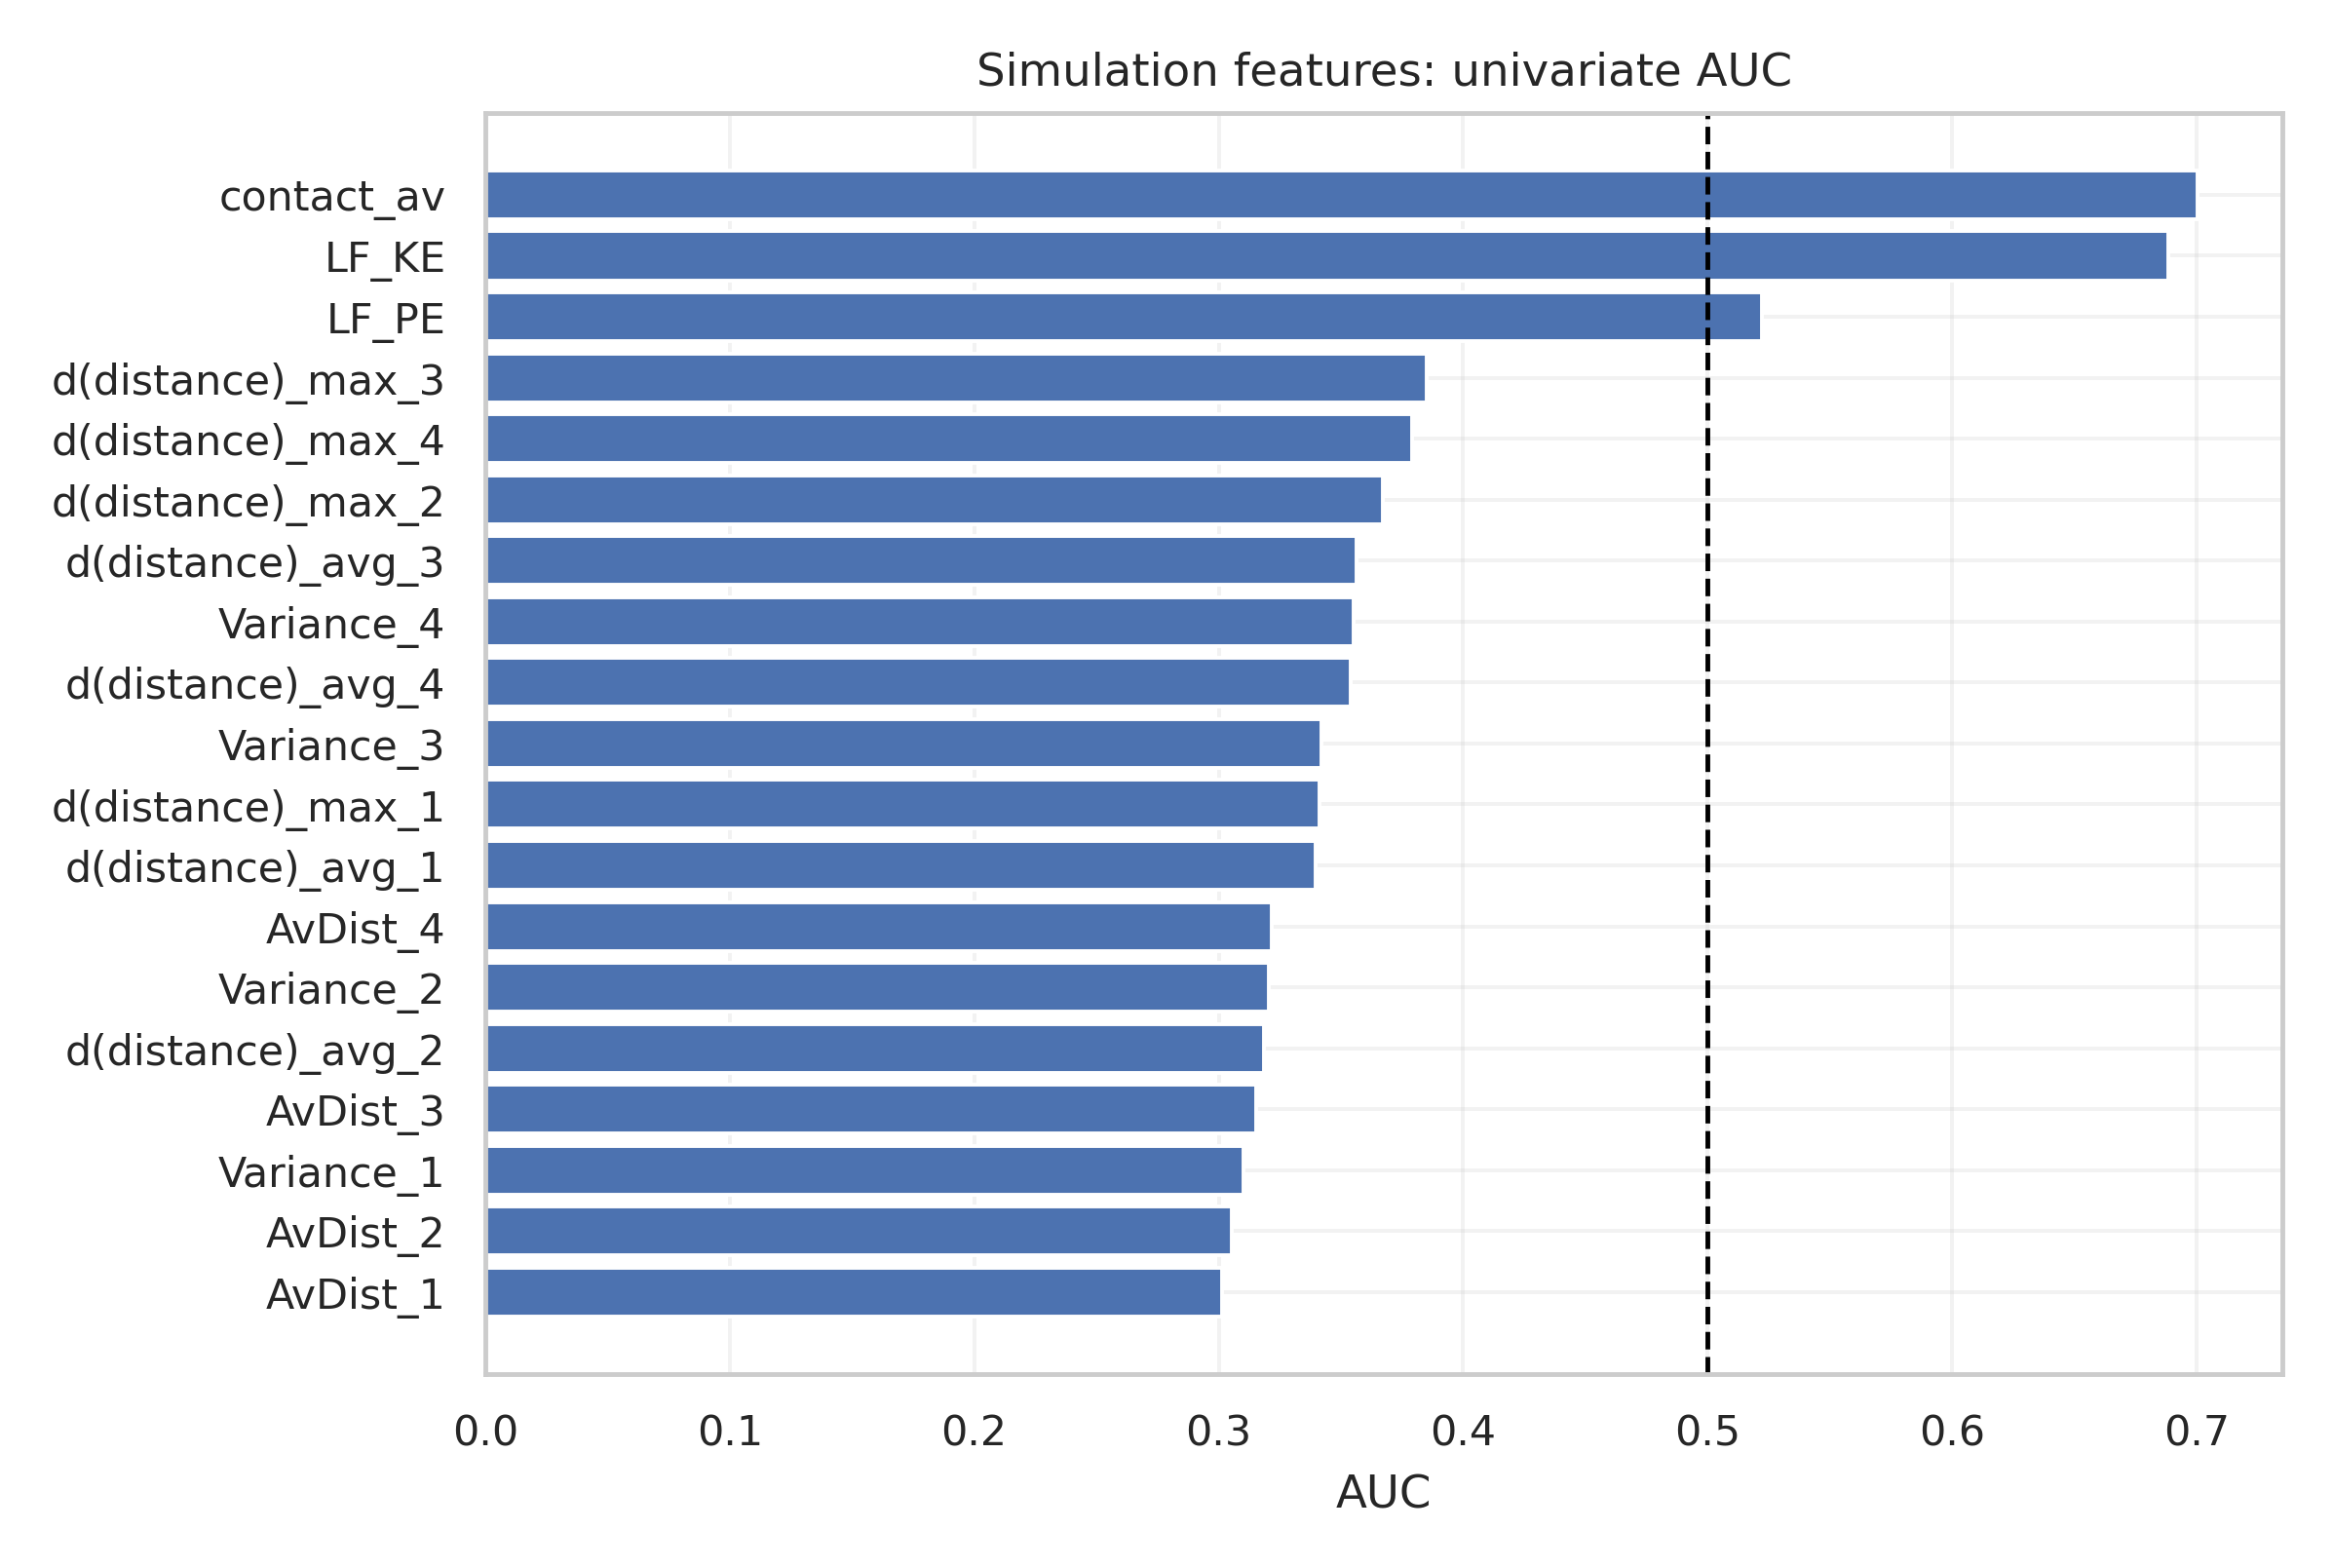

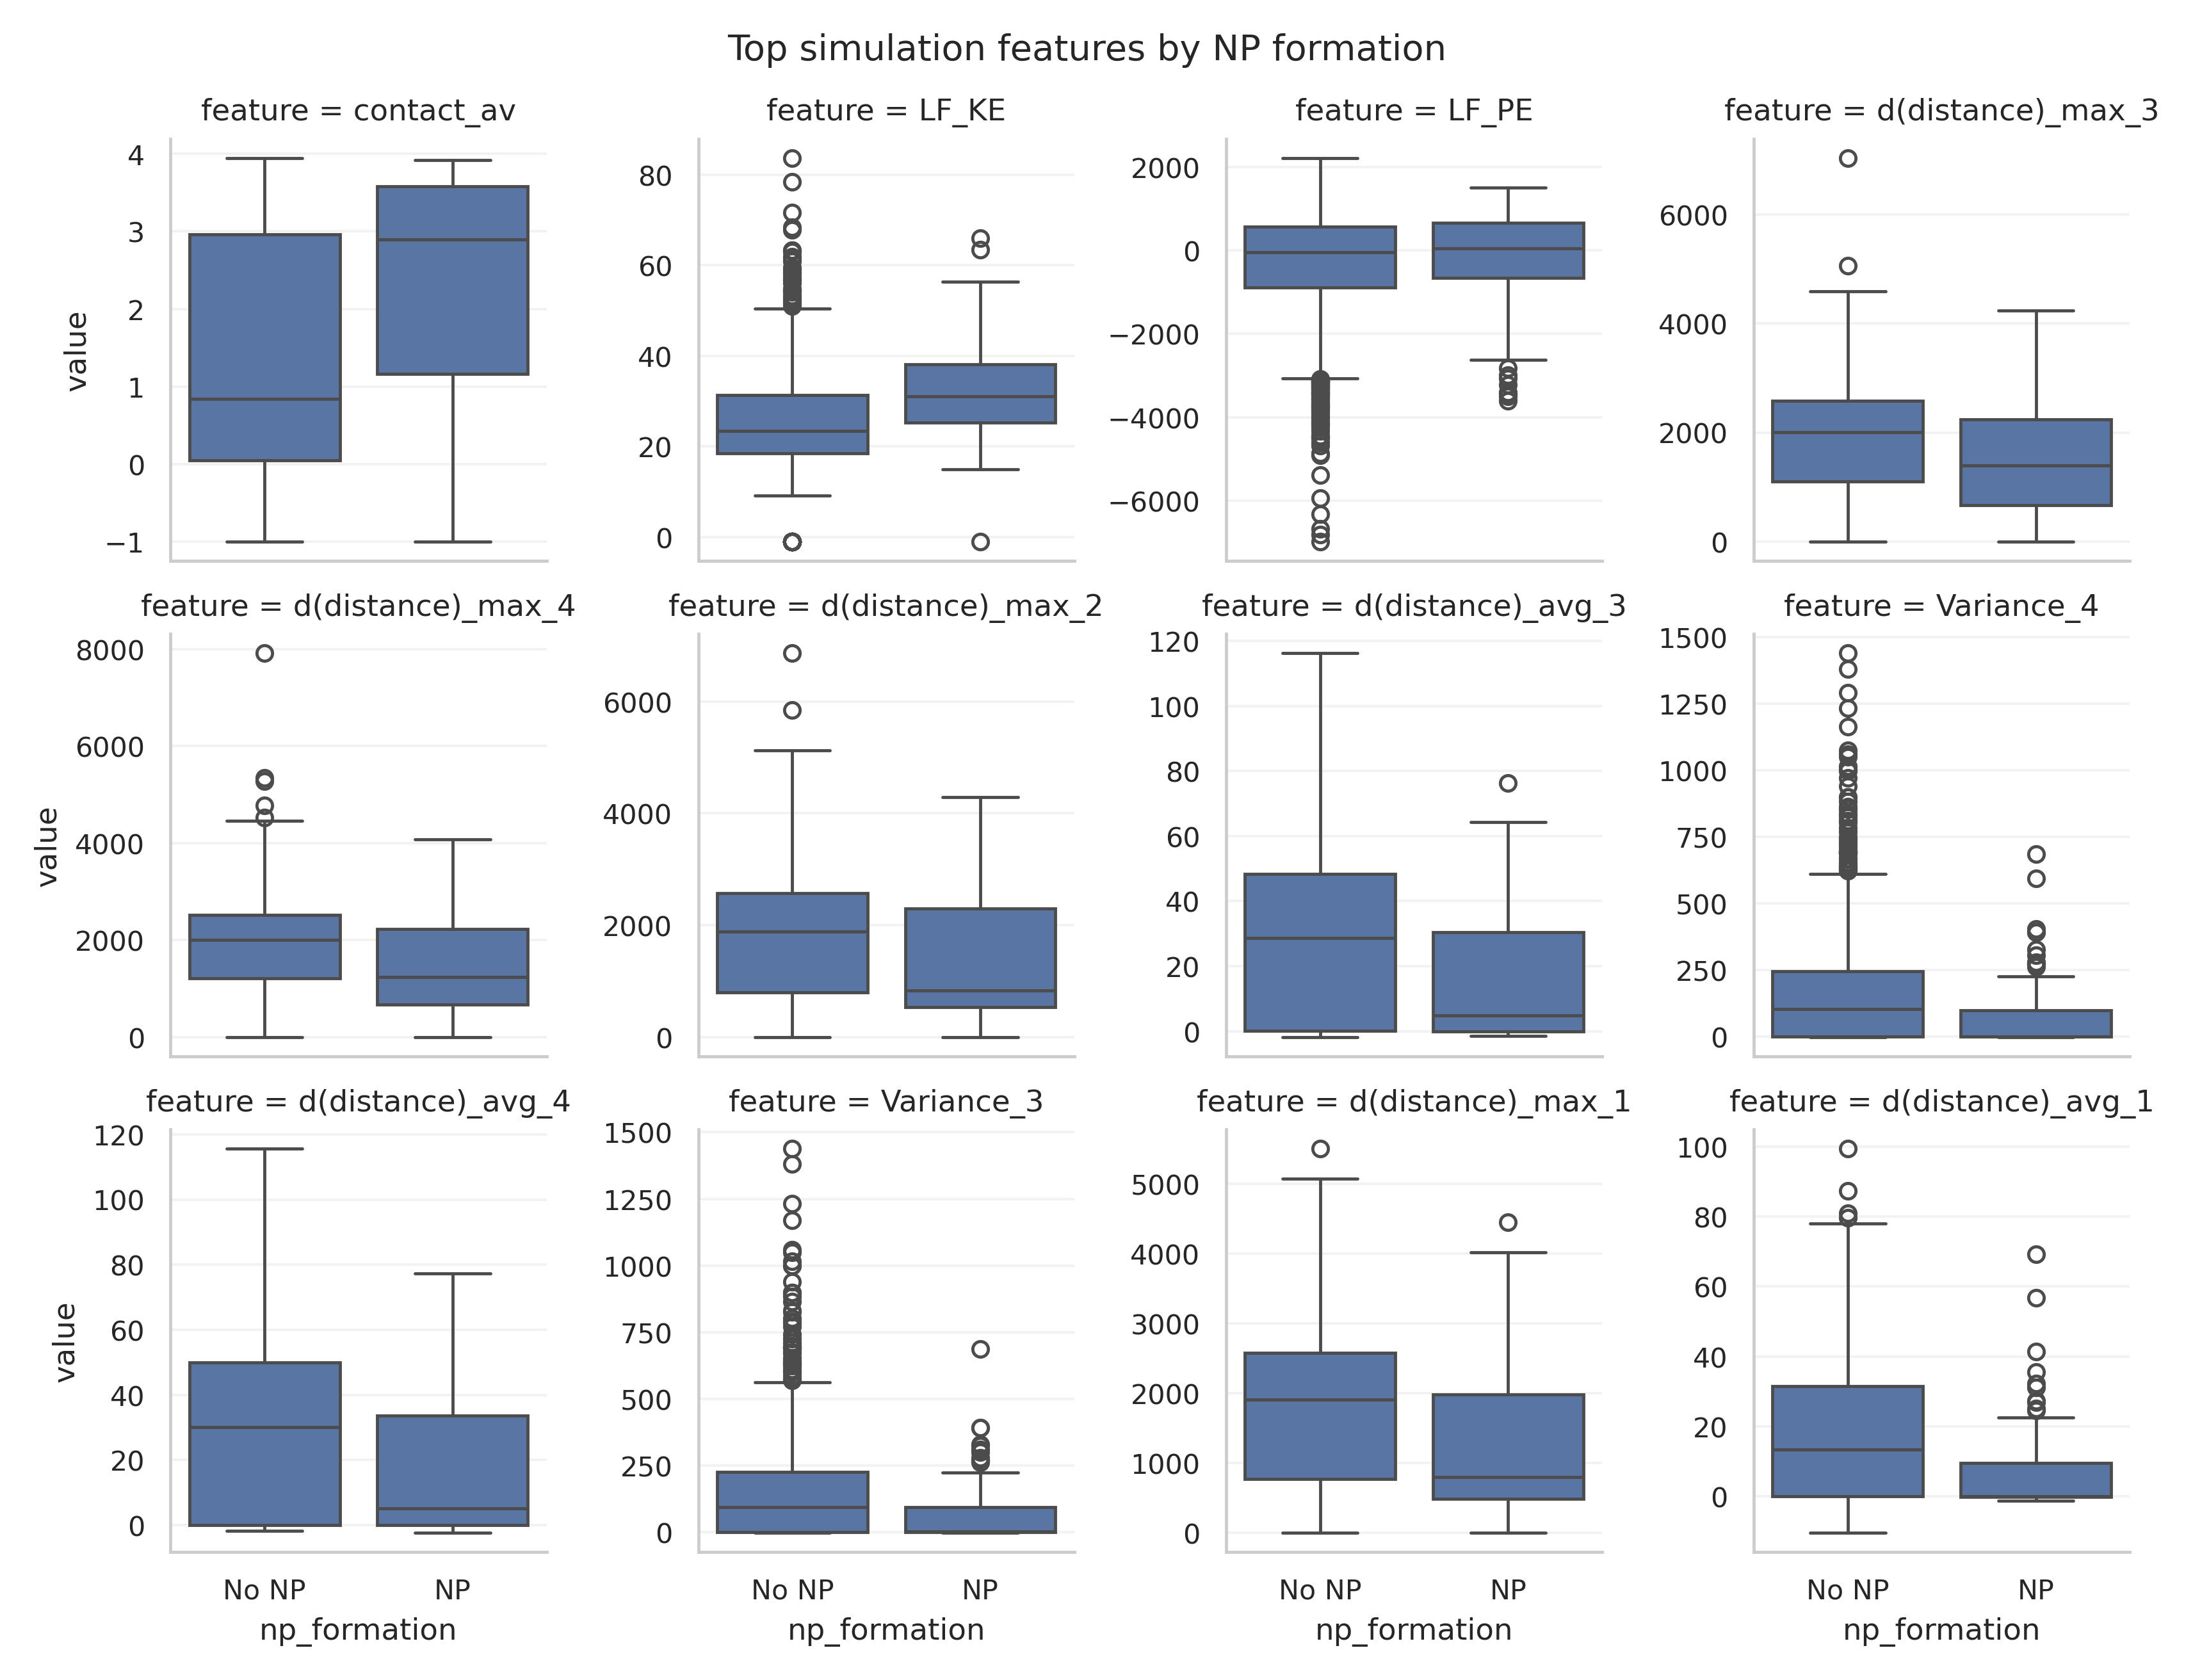

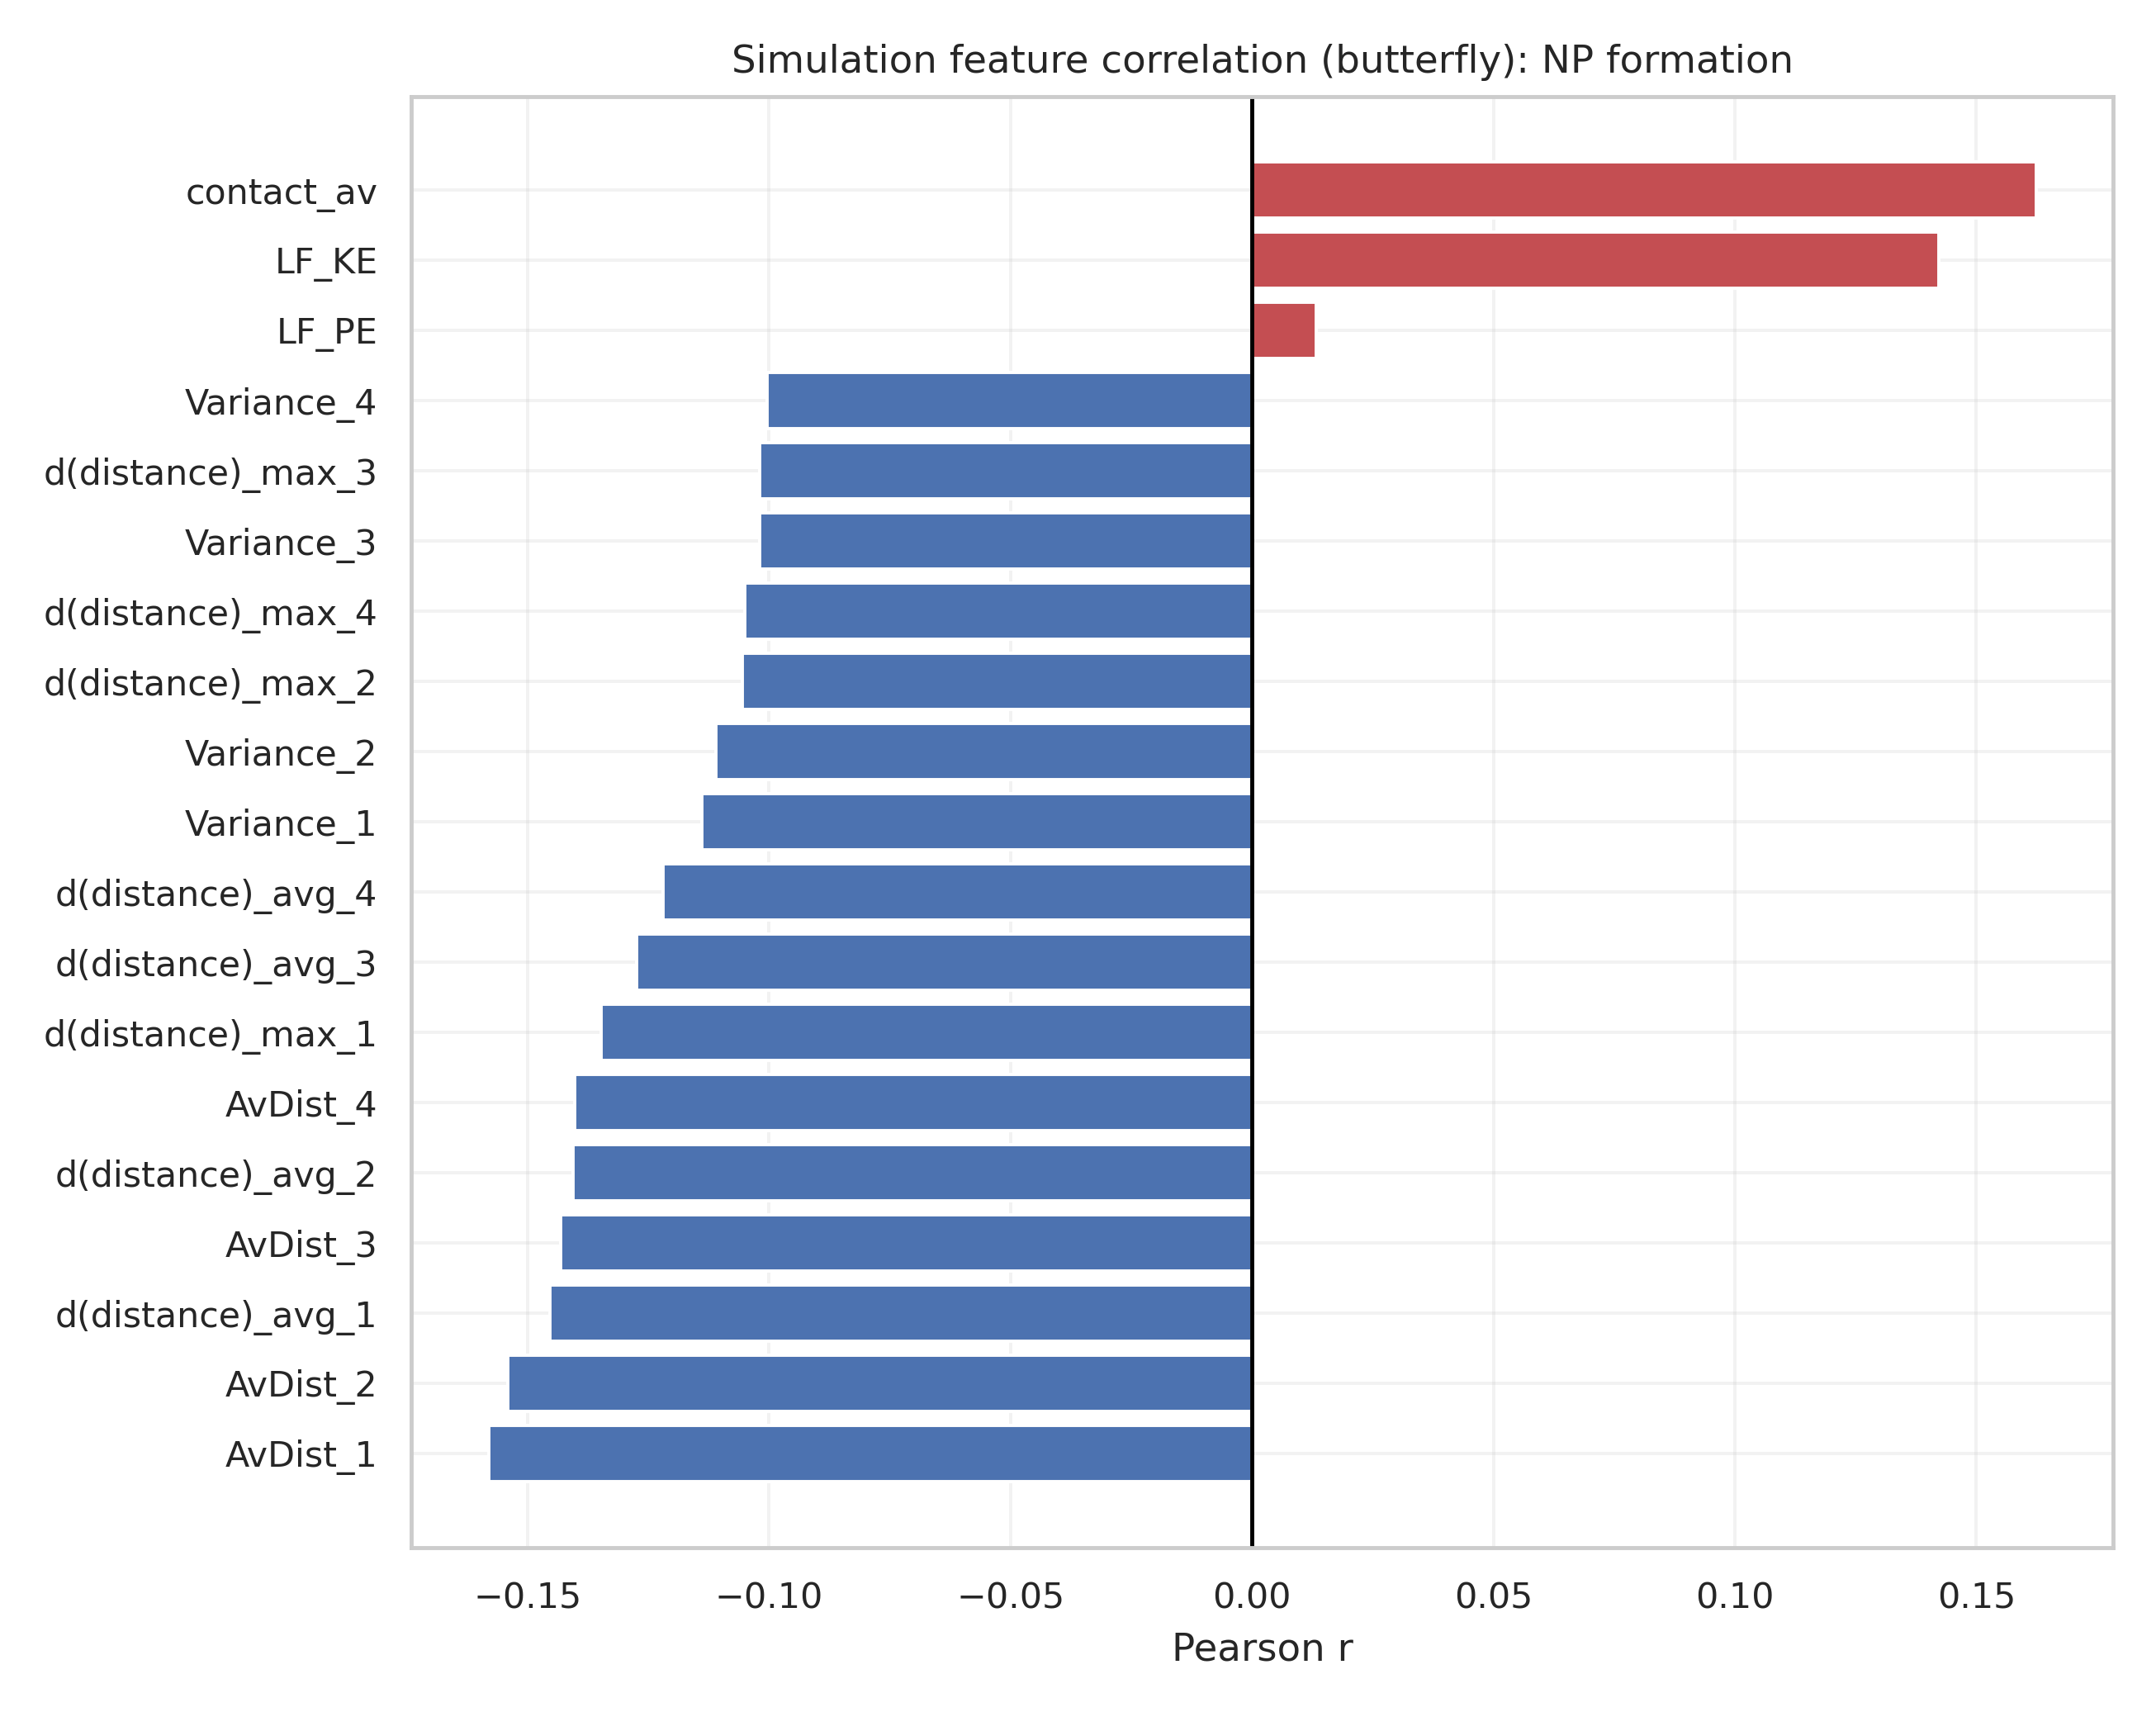

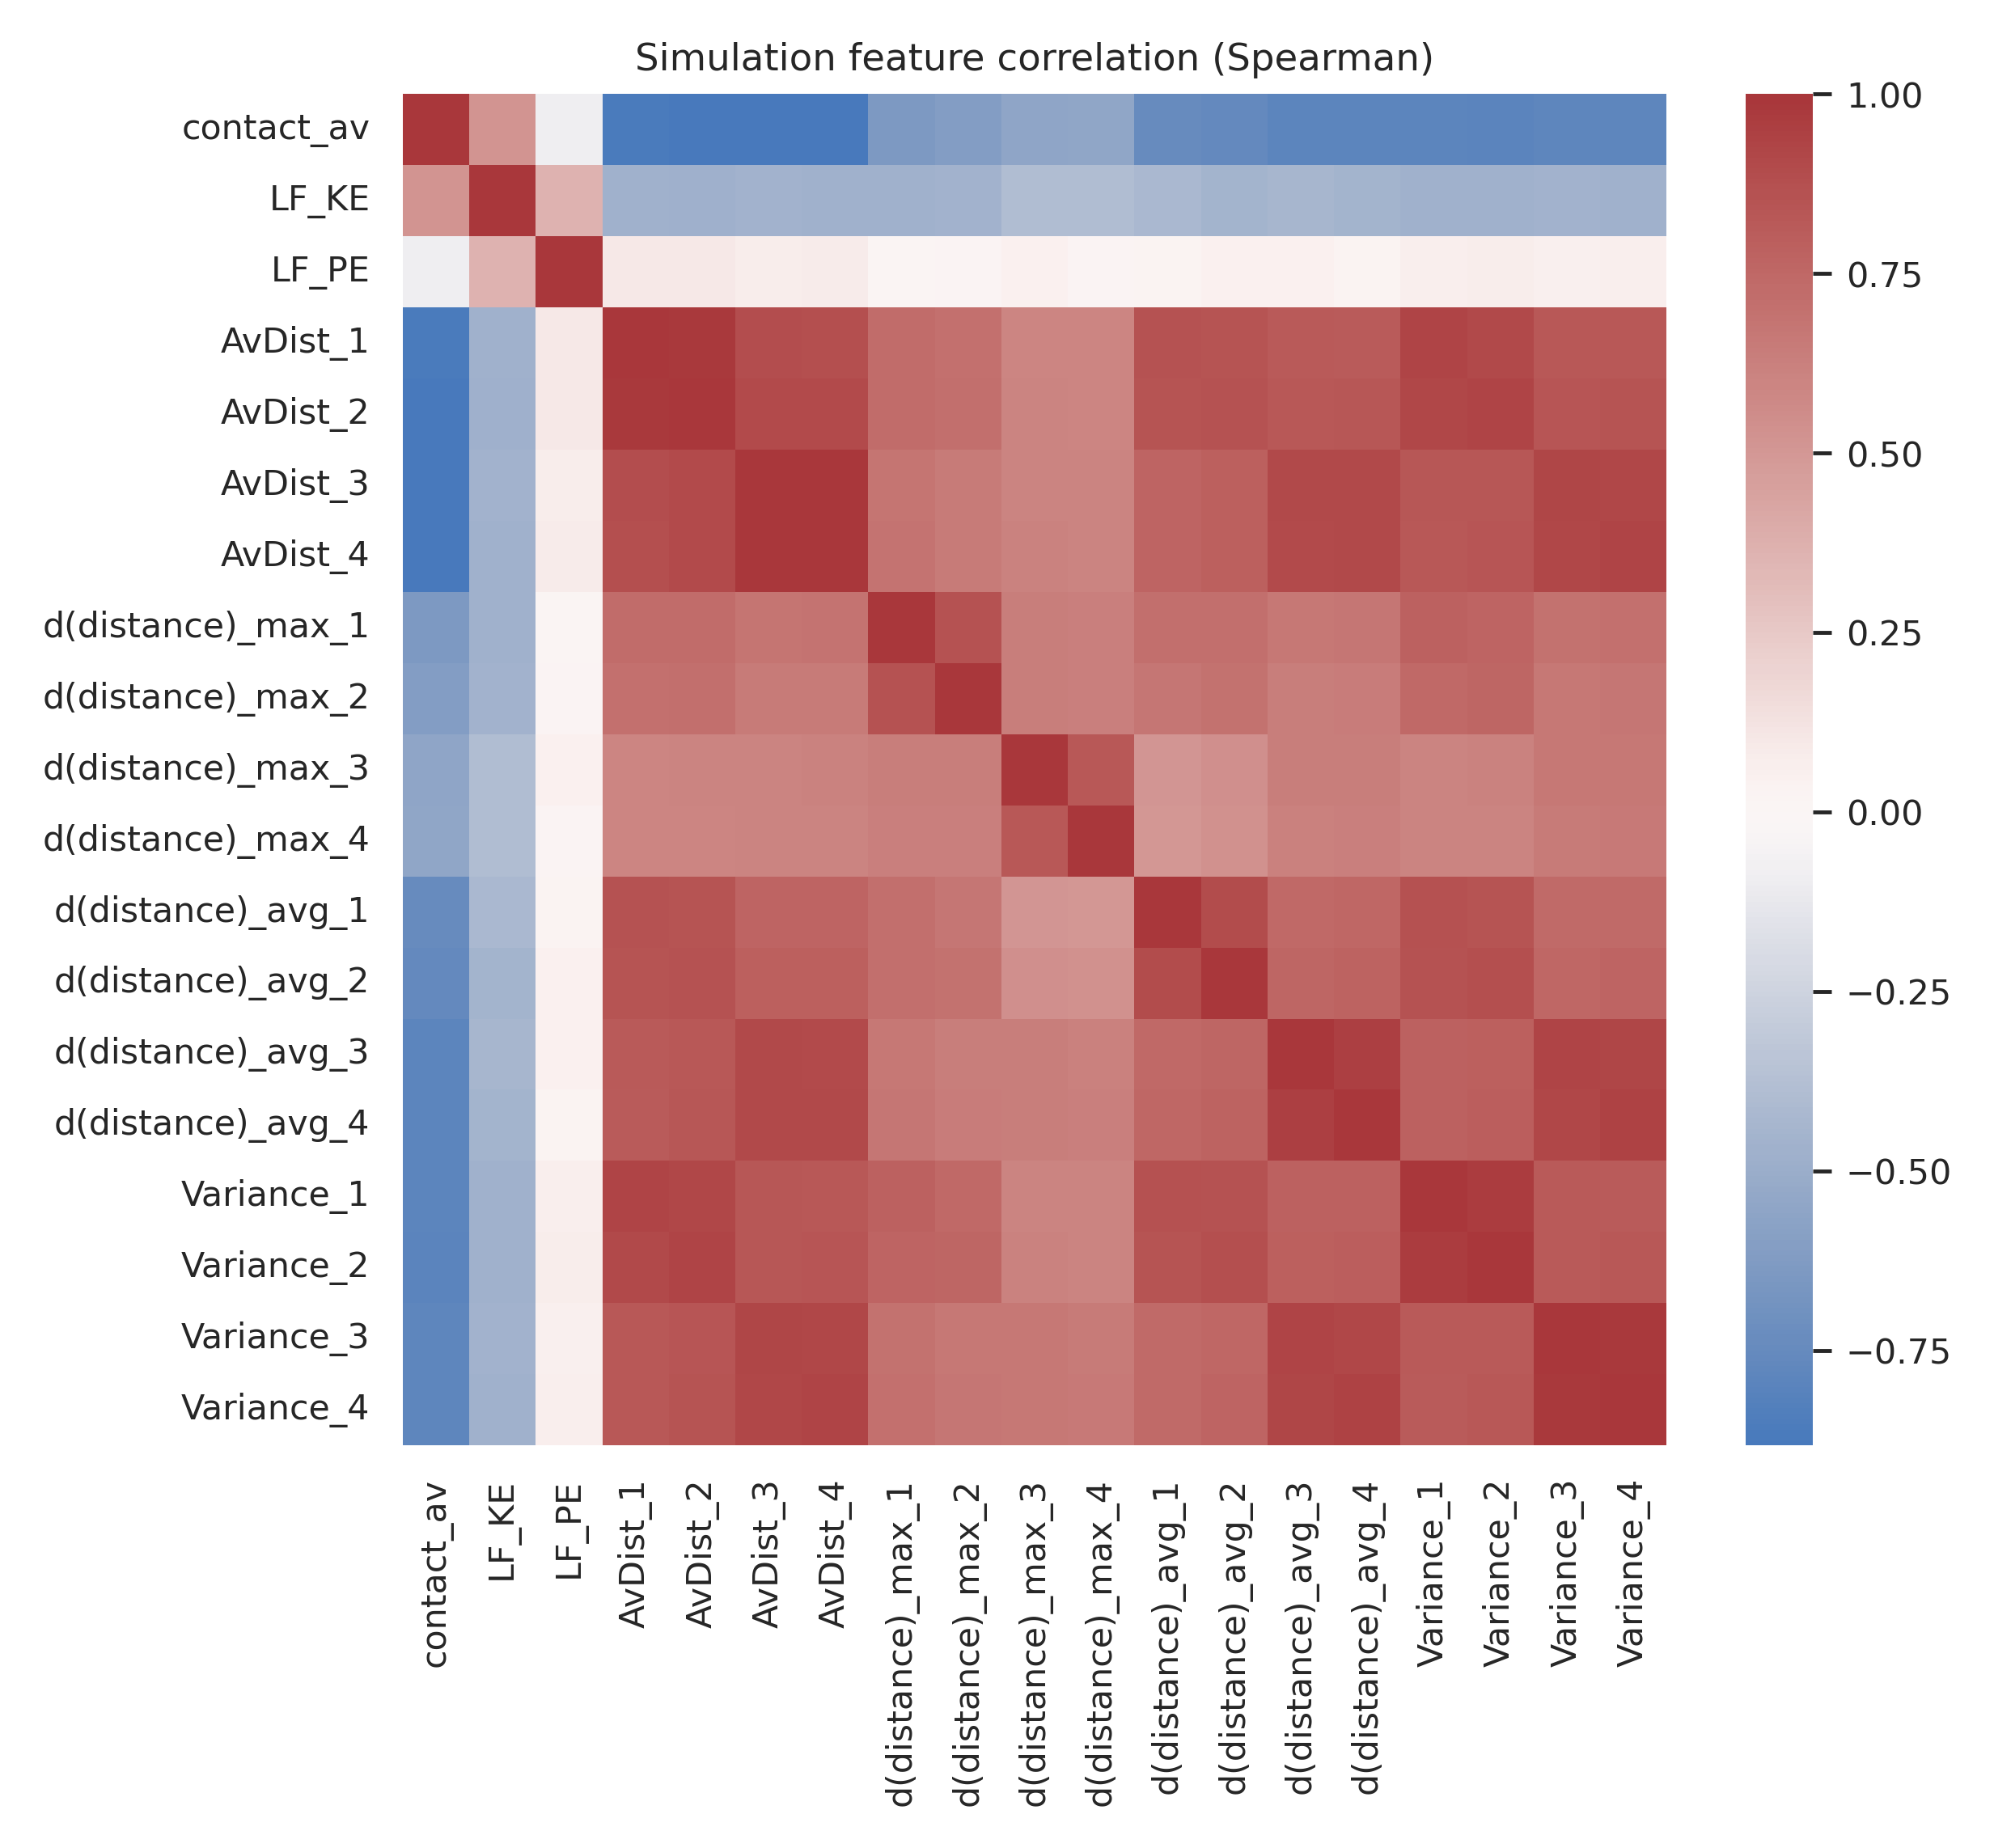

In [10]:
# 25) Simulation feature report (optional): data/simulation_results.tsv
sim_path = DATA / "simulation_results.tsv"
if not sim_path.exists():
    print("No simulation_results.tsv found; skipping.")
else:
    sim_raw = cap.read_tsv_auto(str(sim_path))
    sim = sim_raw.rename(columns={"drug": "drug_name", "excipient": "excipient_name"}).copy()
    feat_cols = [c for c in sim.columns if c not in {"drug_name", "excipient_name"}]
    for c in feat_cols:
        sim[c] = pd.to_numeric(sim[c], errors="coerce")

    # If available, restrict to the planned simulation pair list.
    try:
        sim_pairs = pair_comp[["drug_name", "excipient_name"]].drop_duplicates()
        sim = sim.merge(sim_pairs, on=["drug_name", "excipient_name"], how="inner")
    except Exception:
        pass

    joined = pairs.merge(sim, on=["drug_name", "excipient_name"], how="left")

    # Missingness overview
    if feat_cols:
        miss = joined[feat_cols].isna().mean().sort_values(ascending=False)
        sim_summary = pd.DataFrame({"feature": miss.index, "missing_rate": miss.values})
        export_table(sim_summary, "simulation_feature_missingness")

    # Univariate signal (AUC per feature)
    from sklearn.metrics import roc_auc_score

    rows = []
    y = joined["y_np"].astype(int).to_numpy()
    for c in feat_cols:
        x = joined[c].to_numpy(dtype=float)
        m = ~np.isnan(x)
        if int(m.sum()) < 50:
            continue
        if len(np.unique(y[m])) < 2:
            continue
        auc = float(roc_auc_score(y[m], x[m]))
        rows.append({"feature": c, "auc": auc, "n": int(m.sum())})

    score = pd.DataFrame(rows).sort_values("auc", ascending=False)
    export_table(score, "simulation_feature_univariate_auc")

    if not score.empty:
        # AUC bar plot
        fig, ax = plt.subplots(figsize=(6.8, 4.8))
        tmp = score.head(20).sort_values("auc", ascending=True)
        ax.barh(tmp["feature"], tmp["auc"], color="#4C72B0")
        ax.axvline(0.5, color="black", linestyle="--", linewidth=1)
        ax.set_title("Simulation features: univariate AUC")
        ax.set_xlabel("AUC")
        savefig(fig, "sim_univariate_auc_top20")

        # Boxplots for top features
        top = score.head(12)["feature"].tolist()
        long = joined[["y_np"] + top].melt(id_vars=["y_np"], var_name="feature", value_name="value")
        long["np_formation"] = pd.Categorical(long["y_np"].map(NP_LABELS), categories=NP_ORDER, ordered=True)
        long = long.dropna(subset=["value"]).copy()
        if SNS is not None:
            g = SNS.catplot(
                data=long,
                x="np_formation",
                order=NP_ORDER,
                y="value",
                col="feature",
                col_wrap=4,
                kind="box",
                sharey=False,
                height=2.4,
            )
            g.fig.suptitle("Top simulation features by NP formation", y=1.02)
            g.fig.savefig(FIG_DIR / "sim_top_features_boxplots.png")
            show_image(FIG_DIR / "sim_top_features_boxplots.png")
            try:
                g.fig.savefig(FIG_DIR / "sim_top_features_boxplots.pdf")
            except Exception:
                pass
            plt.close(g.fig)
        else:
            print("seaborn not installed; skipping multi-panel boxplots.")

    # Correlation "butterfly" plot (Pearson r vs y_np)
    corr_rows = []
    for c in feat_cols:
        x = joined[c].to_numpy(dtype=float)
        m = ~np.isnan(x)
        if int(m.sum()) < 50:
            continue
        if len(np.unique(y[m])) < 2:
            continue
        r = float(np.corrcoef(x[m], y[m])[0, 1])
        corr_rows.append({"feature": c, "corr_y_np": r, "n": int(m.sum())})

    corr_df = pd.DataFrame(corr_rows)
    export_table(corr_df.sort_values("corr_y_np", ascending=False), "simulation_feature_corr_y_np")

    if not corr_df.empty:
        k = int(min(25, corr_df.shape[0]))
        top_corr = corr_df.reindex(corr_df["corr_y_np"].abs().sort_values(ascending=False).index).head(k)
        top_corr = top_corr.sort_values("corr_y_np")
        fig_h = max(4.8, 0.28 * k + 1.2)
        fig, ax = plt.subplots(figsize=(7.6, fig_h))
        colors = np.where(top_corr["corr_y_np"] >= 0, "#C44E52", "#4C72B0")
        ax.barh(top_corr["feature"], top_corr["corr_y_np"], color=colors)
        ax.axvline(0, color="black", linewidth=1)
        ax.set_title("Simulation feature correlation (butterfly): NP formation")
        ax.set_xlabel("Pearson r")
        savefig(fig, "sim_feature_corr_butterfly_y_np")

    # Correlation heatmap across simulation features (Spearman)
    if feat_cols:
        corrmat = joined[feat_cols].corr(method="spearman")
        fig, ax = plt.subplots(figsize=(7.2, 6.2))
        if SNS is not None:
            SNS.heatmap(corrmat, cmap="vlag", center=0, ax=ax)
        else:
            im = ax.imshow(corrmat.to_numpy(), cmap="coolwarm", vmin=-1, vmax=1)
            ax.set_xticks(range(len(feat_cols)))
            ax.set_yticks(range(len(feat_cols)))
            ax.set_xticklabels(feat_cols, rotation=90, fontsize=8)
            ax.set_yticklabels(feat_cols, fontsize=8)
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        ax.set_title("Simulation feature correlation (Spearman)")
        savefig(fig, "sim_feature_corr_heatmap")

In [11]:
# 5) Splits
manifest = {}
for mode in ["random_kfold", "leave_one_drug_out", "leave_one_excipient_out"]:
    manifest[mode] = cap.make_splits(
        pairs,
        mode=mode,
        n_splits=int(CFG["splits"]["n_splits"]),
        shuffle=bool(CFG["splits"]["shuffle"]),
        random_seed=int(CFG["random_seed"]),
    )

cap.safe_write_json(manifest, str(Path(results_dir) / "splits_manifest.json"))

SPLIT_MODE = str(CFG["splits"]["mode"])
splits = manifest[SPLIT_MODE]
print("Using split mode:", SPLIT_MODE, "folds:", len(splits))
splits[0]


Using split mode: random_kfold folds: 5


{'fold': 0,
 'name': 'kfold_0',
 'train_idx': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  10,
  11,
  12,
  13,
  14,
  16,
  17,
  18,
  19,
  21,
  22,
  23,
  24,
  27,
  28,
  29,
  31,
  32,
  33,
  34,
  35,
  36,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  48,
  49,
  50,
  51,
  53,
  54,
  56,
  57,
  58,
  59,
  60,
  61,
  63,
  64,
  66,
  67,
  68,
  69,
  70,
  71,
  74,
  75,
  76,
  78,
  79,
  80,
  81,
  83,
  84,
  85,
  86,
  88,
  89,
  91,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  105,
  107,
  108,
  109,
  110,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  123,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  136,
  138,
  139,
  141,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  152,
  153,
  154,
  155,
  157,
  158,
  159,
  160,
  161,
  163,
  164,
  165,
  166,
  167,
  168,
  169,
  170,
  171,
  172,
  173,
  174,
  175,
  176,
  177,
  178,
  179,
  180,
  

In [12]:
# 6) Featurize: RDKit descriptors (default) / Mordred (optional)
cache_dir = Path(CFG["paths"]["cache_dir"])
cache_dir.mkdir(parents=True, exist_ok=True)

use_mordred = bool(CFG.get("features", {}).get("use_mordred_if_available", False))
desc_tag = "mordred" if use_mordred else "rdkit"

drug_desc_path = cache_dir / f"desc_selected_drugs_{desc_tag}.pkl"
exc_desc_path = cache_dir / f"desc_selected_excipients_{desc_tag}.pkl"

if drug_desc_path.exists():
    desc_drug = pickle.load(open(drug_desc_path, "rb"))
else:
    desc_drug = cap.compute_mordred(
        drugs.dropna(subset=["smiles_std"])[["mol_id", "smiles_std"]],
        use_mordred_if_available=use_mordred,
    )
    pickle.dump(desc_drug, open(drug_desc_path, "wb"))

if exc_desc_path.exists():
    desc_exc = pickle.load(open(exc_desc_path, "rb"))
else:
    desc_exc = cap.compute_mordred(
        excs.dropna(subset=["smiles_std"])[["mol_id", "smiles_std"]],
        use_mordred_if_available=use_mordred,
    )
    pickle.dump(desc_exc, open(exc_desc_path, "wb"))


# Optional: Morgan fingerprints for drugs/excipients (used by high-capacity regressors)
fp_drug = None
fp_exc = None
try:
    nbits = int(CFG.get("features", {}).get("morgan_nbits", 2048))
    radius = int(CFG.get("features", {}).get("morgan_radius", 2))

    fp_drug_path = cache_dir / f"fp_morgan_drugs_r{radius}_n{nbits}.pkl"
    fp_exc_path = cache_dir / f"fp_morgan_excipients_r{radius}_n{nbits}.pkl"

    def _fp_table(df):
        rows = []
        idx = []
        for mol_id, smi in df[["mol_id", "smiles_std"]].dropna().itertuples(index=False):
            try:
                fp = cap.make_morgan_fp(str(smi), radius=radius, nbits=nbits)
            except Exception:
                fp = np.full((nbits,), np.nan, dtype=float)
            rows.append(fp)
            idx.append(str(mol_id))
        if not rows:
            return None
        return pd.DataFrame(np.asarray(rows), index=idx)

    if fp_drug_path.exists():
        fp_drug = pickle.load(open(fp_drug_path, "rb"))
    else:
        fp_drug = _fp_table(drugs)
        if fp_drug is not None:
            pickle.dump(fp_drug, open(fp_drug_path, "wb"))

    if fp_exc_path.exists():
        fp_exc = pickle.load(open(fp_exc_path, "rb"))
    else:
        fp_exc = _fp_table(excs)
        if fp_exc is not None:
            pickle.dump(fp_exc, open(fp_exc_path, "wb"))

    if fp_drug is not None:
        fp_drug = fp_drug.reindex(desc_drug.index)
    if fp_exc is not None:
        fp_exc = fp_exc.reindex(desc_exc.index)
except Exception:
    fp_drug = None
    fp_exc = None

# Add low-effort compound-level annotations as extra features (helps in a low-label regime)
SELFAGG_SMILES = set(selfagg.dropna(subset=["smiles_std"])["smiles_std"].astype(str).tolist())
_gras_t = gras.dropna(subset=["smiles_std"]).copy()
_gras_t["type"] = _gras_t.get("type").astype(str).str.strip().str.upper()
GRAS_SMILES = set(_gras_t.loc[_gras_t["type"] == "GRAS", "smiles_std"].astype(str).tolist())
IIG_SMILES = set(_gras_t.loc[_gras_t["type"] == "IIG", "smiles_std"].astype(str).tolist())

ANN_FEATURES = ["ann_is_selfagg", "ann_is_gras", "ann_is_iig"]

def add_ann_features(desc_df: pd.DataFrame, smiles_map: pd.Series) -> pd.DataFrame:
    out = desc_df.copy()
    s = smiles_map.reindex(out.index).fillna("").astype(str)
    out["ann_is_selfagg"] = s.isin(SELFAGG_SMILES).astype(int)
    out["ann_is_gras"] = s.isin(GRAS_SMILES).astype(int)
    out["ann_is_iig"] = s.isin(IIG_SMILES).astype(int)
    return out

# Align mol_id -> smiles_std for annotation lookups
_drug_smiles = drugs.set_index("mol_id")["smiles_std"]
_exc_smiles = excs.set_index("mol_id")["smiles_std"]

desc_drug = add_ann_features(desc_drug, _drug_smiles)
desc_exc = add_ann_features(desc_exc, _exc_smiles)

base_features = sorted(set(desc_drug.columns).intersection(set(desc_exc.columns)))
feature_names = cap.make_pair_feature_names(base_features)

Xd = desc_drug.loc[pairs["drug_mol_id"].astype(str).tolist(), base_features].to_numpy()
Xe = desc_exc.loc[pairs["excipient_mol_id"].astype(str).tolist(), base_features].to_numpy()
X = cap.make_pair_features(Xd, Xe)

y_cls = pairs["y_np"].astype(int).to_numpy()
y_reg = {
    "radius_nm": pairs["y_radius_nm"].to_numpy(dtype=float),
    "size_reduction": pairs["y_size_reduction"].to_numpy(dtype=float),
}

print("Descriptor backend:", desc_tag)
print("X:", X.shape, "base_features:", len(base_features))


Descriptor backend: rdkit
X: (1440, 880) base_features: 220


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


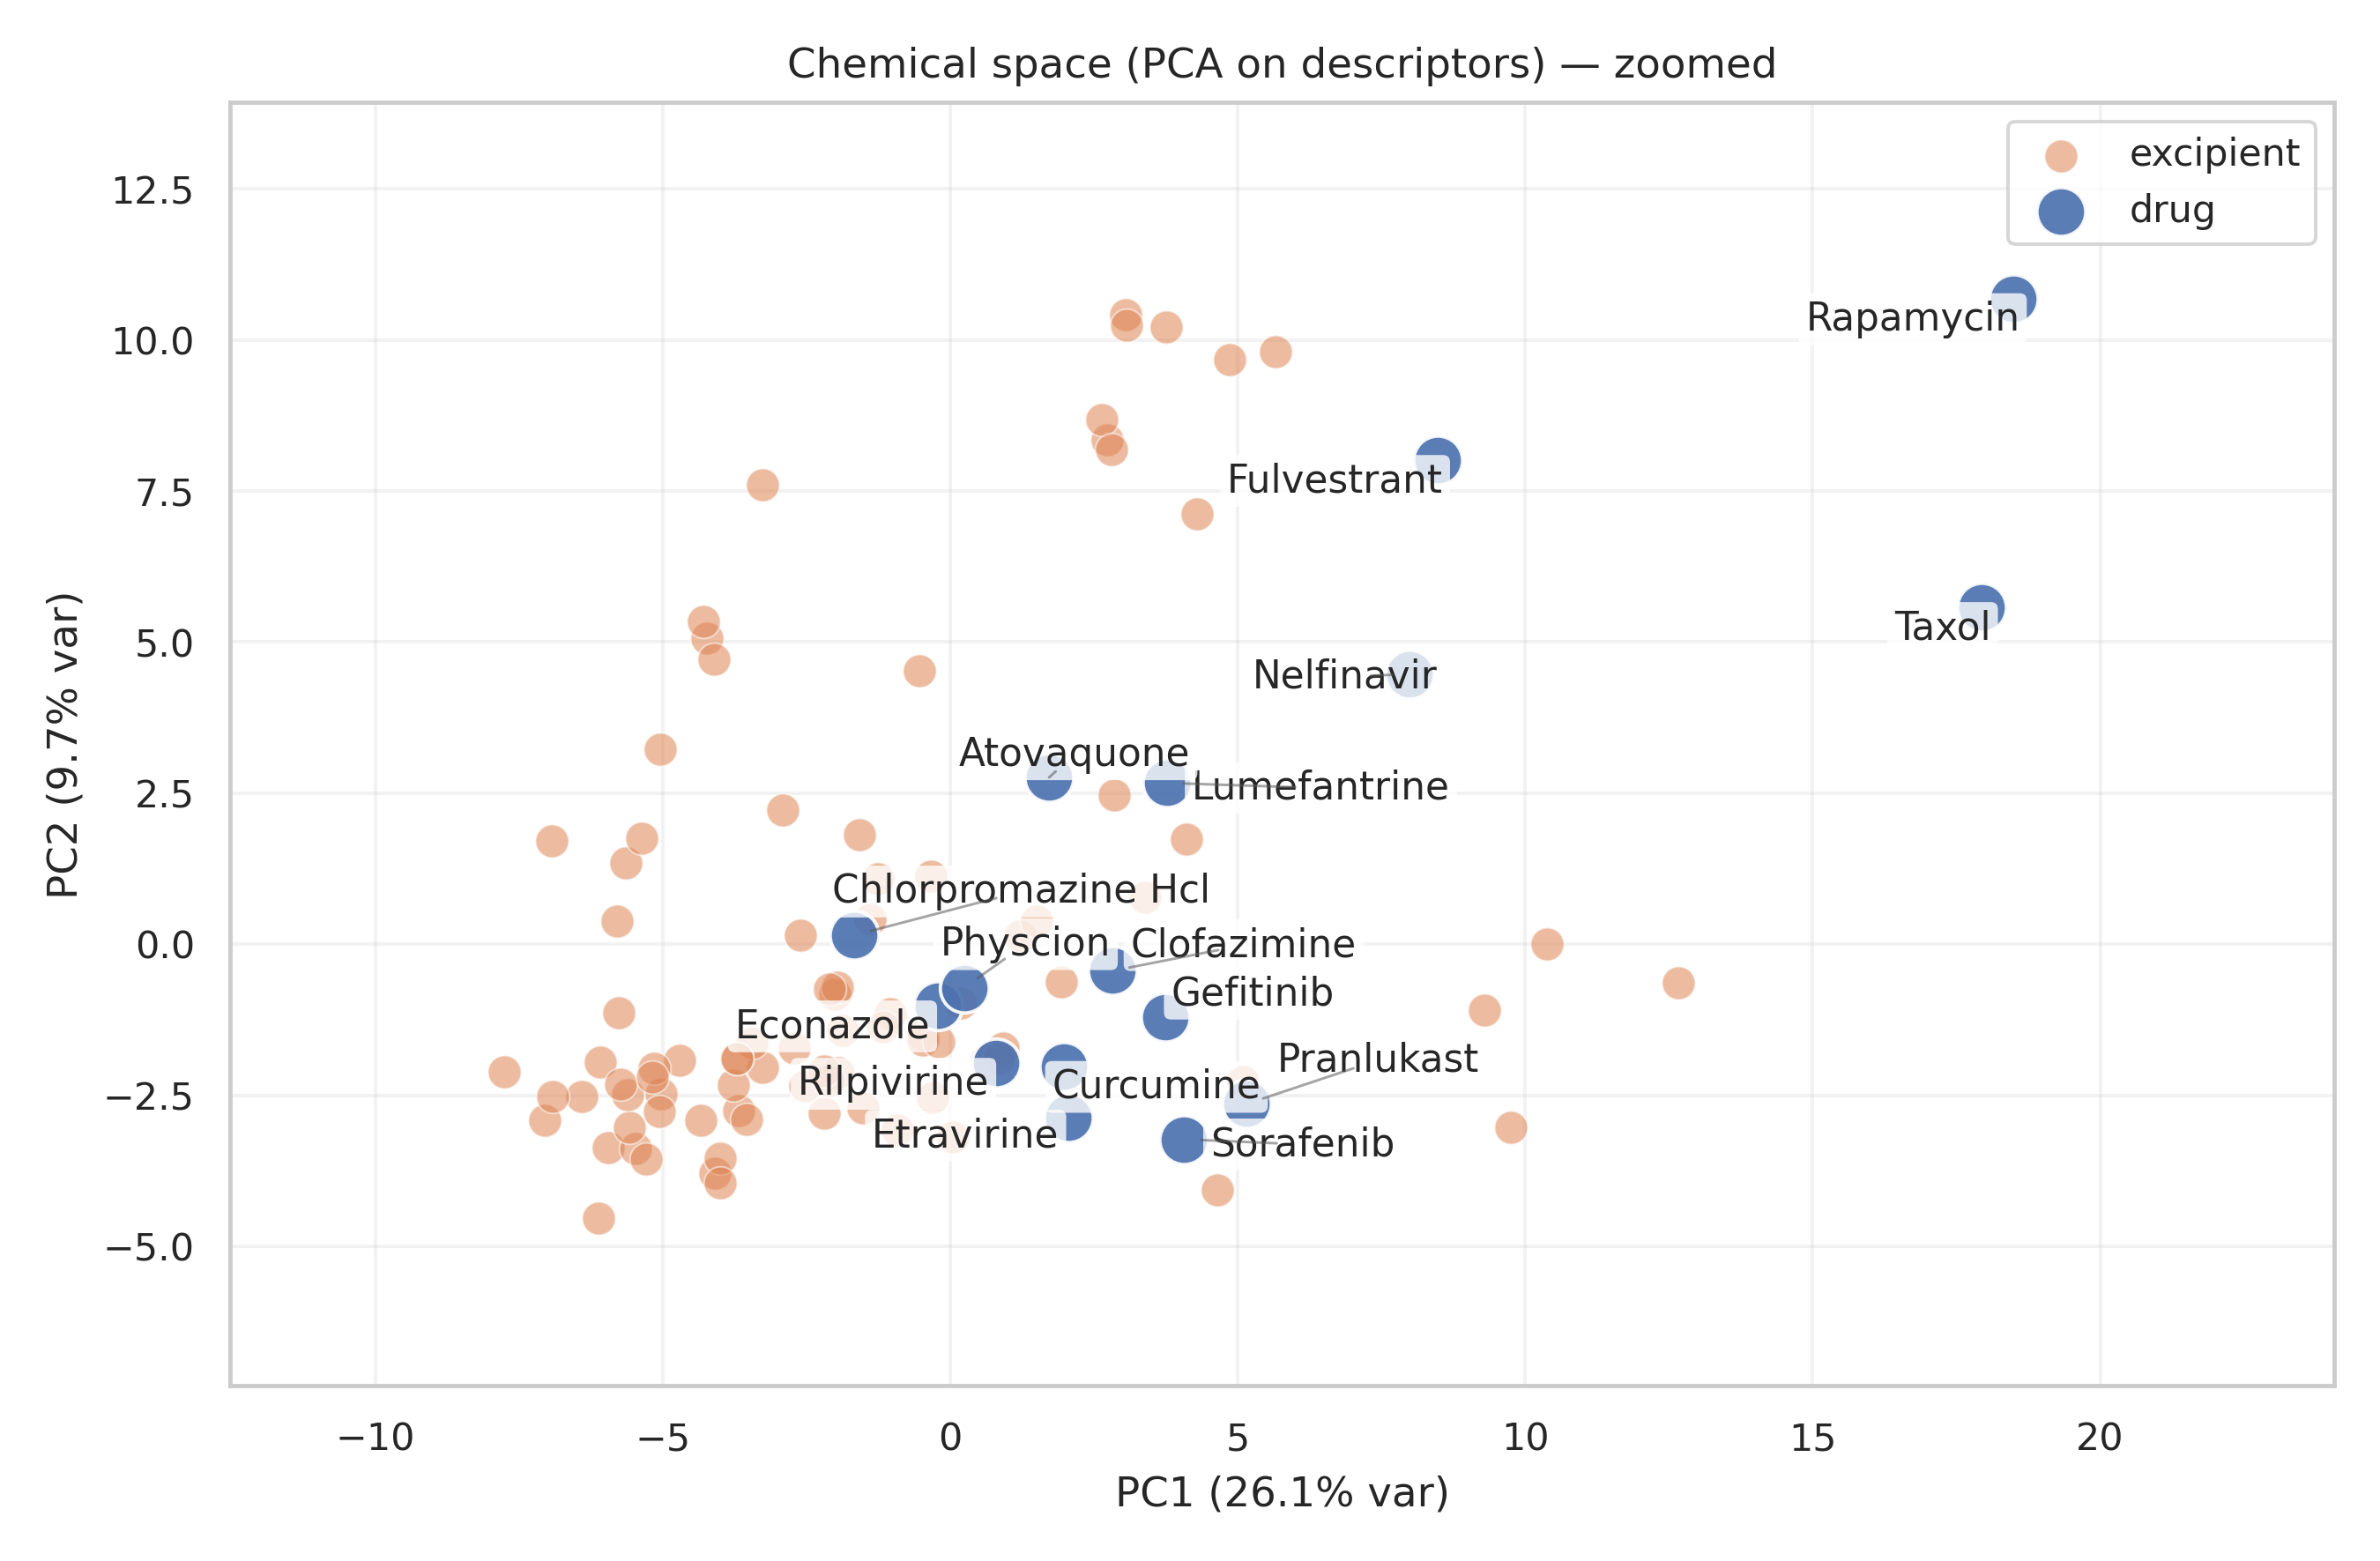

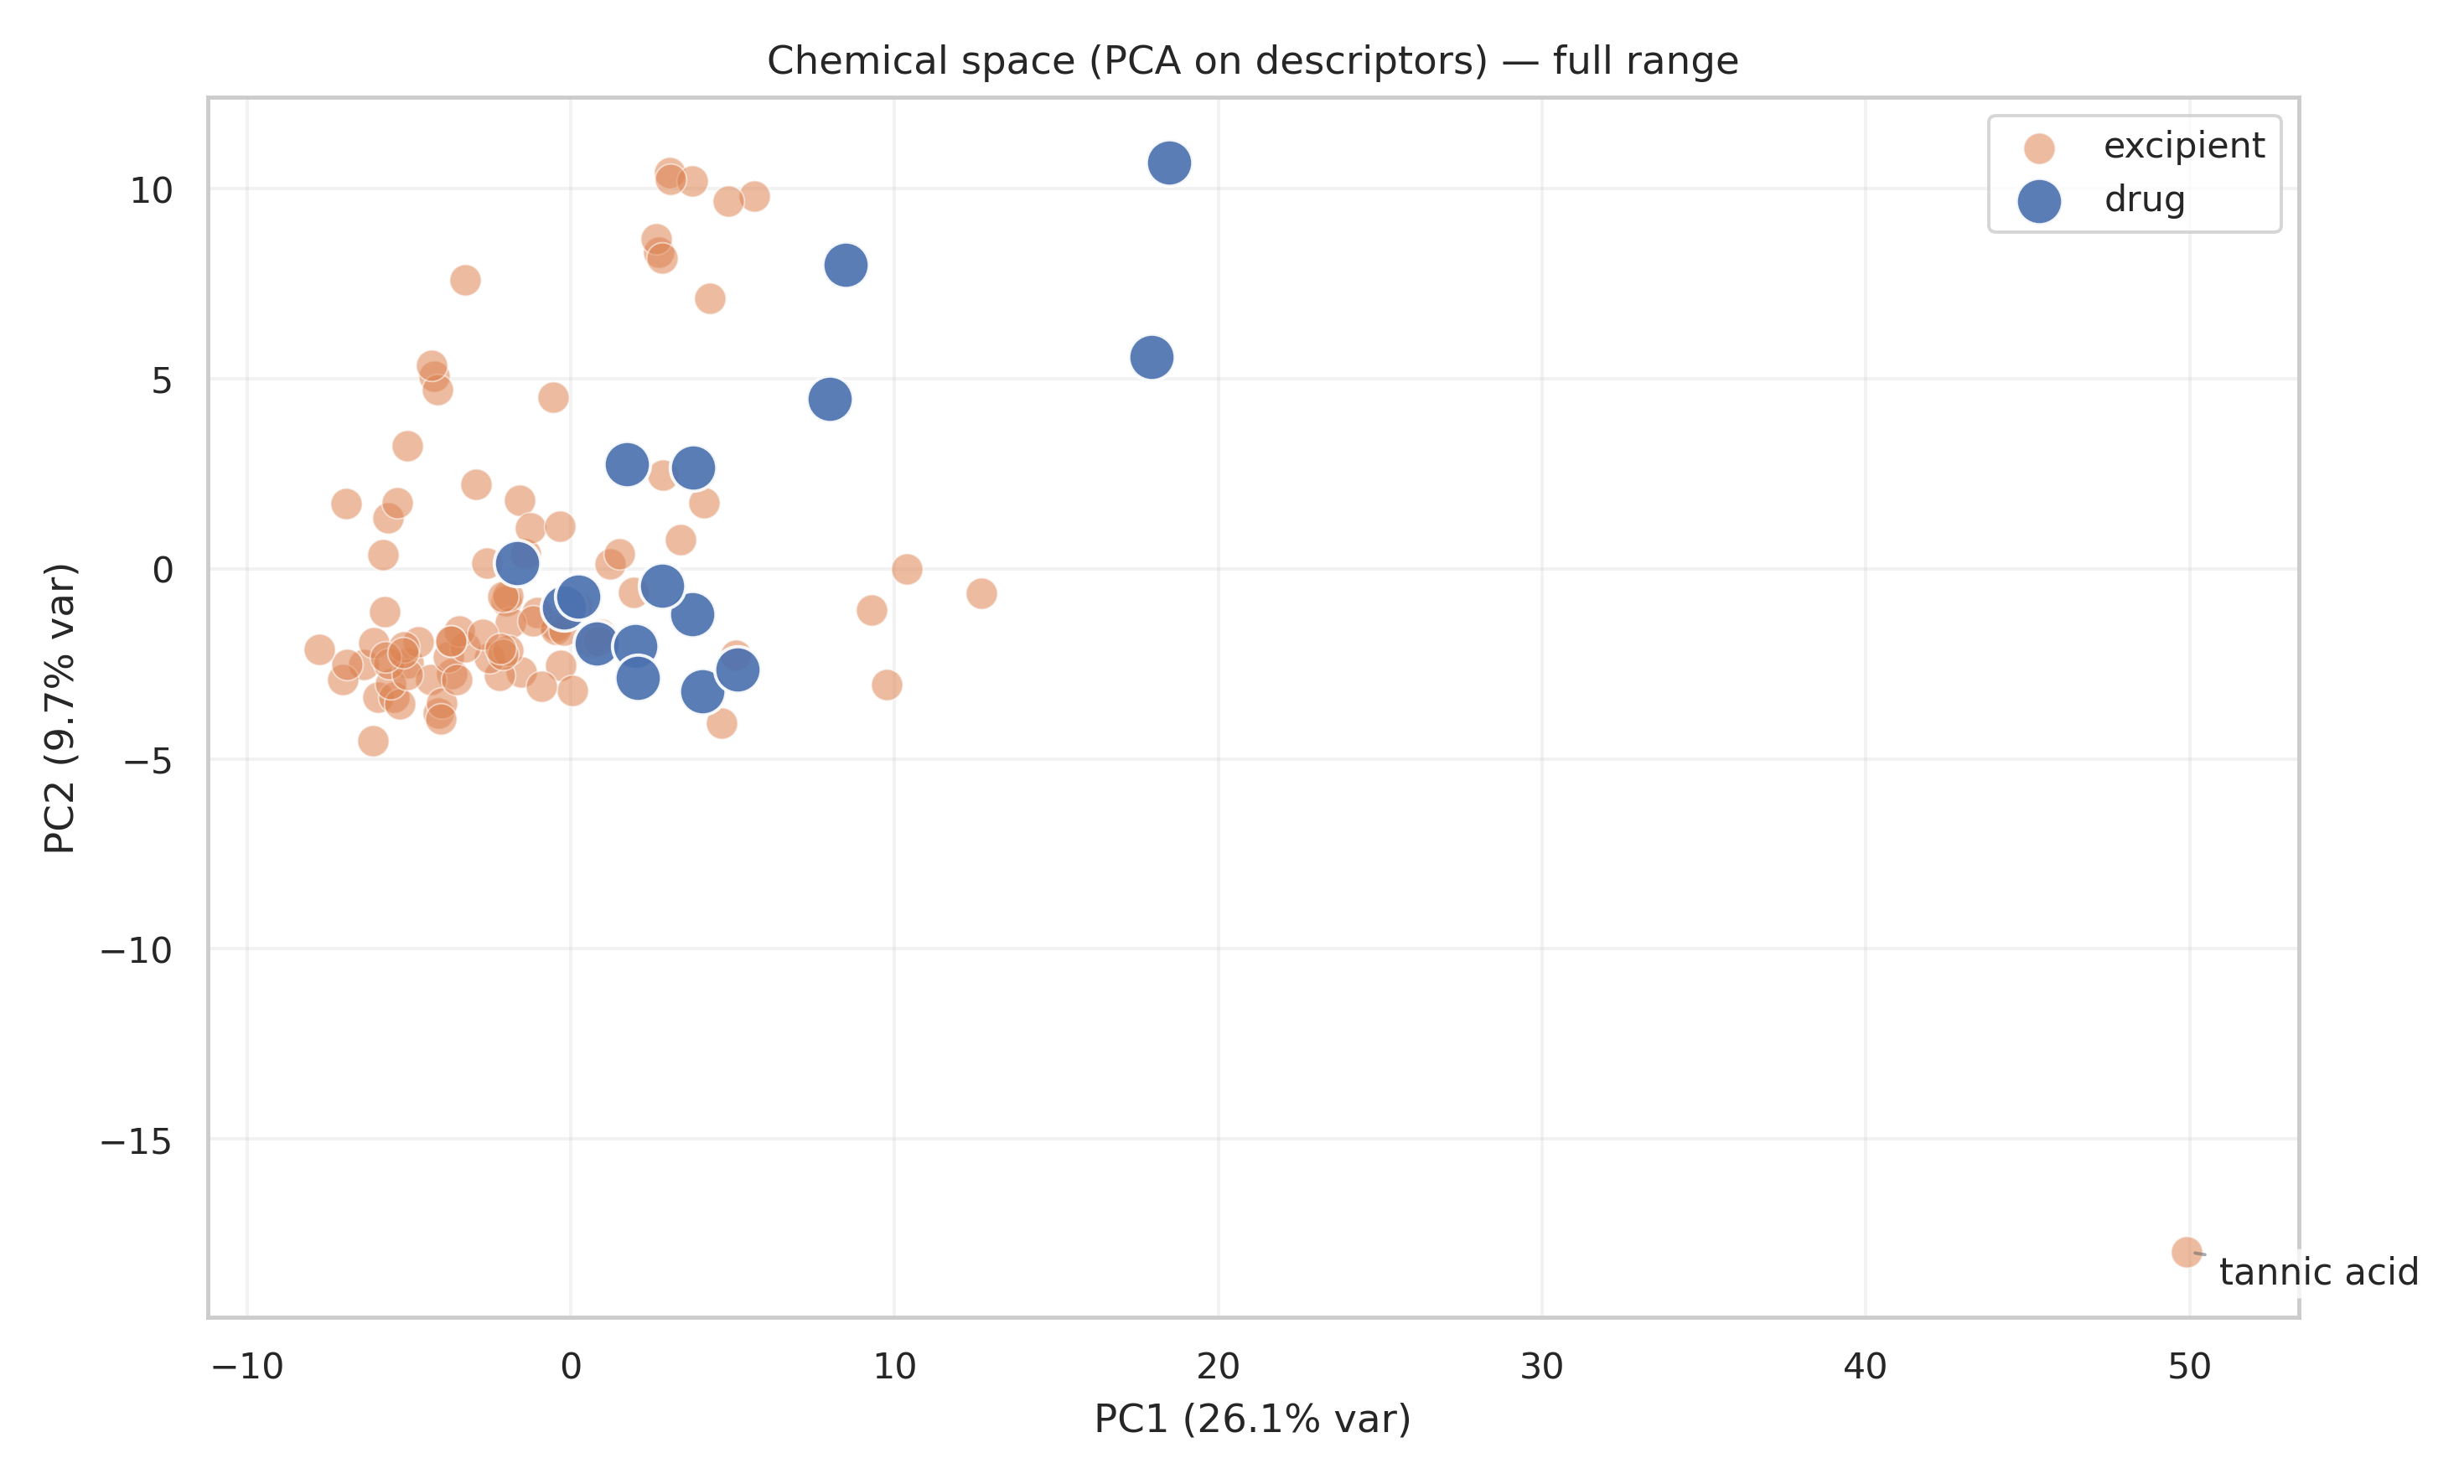

PosixPath('/media/xuchengjie/E7562A2674DB25F7/SRRSH/Sirt7/12.27/results/figures/chemspace_pca_selected_full_range.png')

In [13]:
# 19) Chemical space visualization (PCA on descriptors)
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd

try:
    from adjustText import adjust_text
except Exception:
    adjust_text = None

# Build a shared descriptor matrix for drugs + excipients

d_names = drugs.set_index("mol_id")["name"].to_dict()
e_names = excs.set_index("mol_id")["name"].to_dict()

d_desc = desc_drug[base_features].copy()
d_desc["kind"] = "drug"
d_desc["name"] = [d_names.get(i, i) for i in d_desc.index]

e_desc = desc_exc[base_features].copy()
e_desc["kind"] = "excipient"
e_desc["name"] = [e_names.get(i, i) for i in e_desc.index]

chem = pd.concat([d_desc, e_desc], axis=0, ignore_index=False)
X0 = chem[base_features].to_numpy()
X0 = SimpleImputer(strategy="median").fit_transform(X0)
X0 = StandardScaler().fit_transform(X0)

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(X0)
ev1, ev2 = pca.explained_variance_ratio_.tolist()

chem["PC1"] = pcs[:, 0]
chem["PC2"] = pcs[:, 1]

drug_pts = chem[chem["kind"] == "drug"].copy()
exc_pts = chem[chem["kind"] == "excipient"].copy()


def _axis_labels(ax):
    ax.set_xlabel(f"PC1 ({ev1*100:.1f}% var)")
    ax.set_ylabel(f"PC2 ({ev2*100:.1f}% var)")


def _scatter(ax):
    ax.scatter(
        exc_pts["PC1"],
        exc_pts["PC2"],
        s=60,
        c="#DD8452",
        marker="o",
        alpha=0.55,
        label="excipient",
        edgecolors="white",
        linewidths=0.4,
    )
    ax.scatter(
        drug_pts["PC1"],
        drug_pts["PC2"],
        s=130,
        c="#4C72B0",
        marker="o",
        alpha=0.92,
        edgecolors="white",
        linewidths=0.8,
        label="drug",
    )


# 19.1 Zoomed view (readable labels)
bulk = chem
x_lo, x_hi = bulk["PC1"].quantile([0.02, 0.98]).tolist()
y_lo, y_hi = bulk["PC2"].quantile([0.02, 0.98]).tolist()

# Always include all drugs in the zoomed panel.
x_lo = float(min(x_lo, drug_pts["PC1"].min()))
x_hi = float(max(x_hi, drug_pts["PC1"].max()))
y_lo = float(min(y_lo, drug_pts["PC2"].min()))
y_hi = float(max(y_hi, drug_pts["PC2"].max()))

pad_x = (x_hi - x_lo) * 0.22 if x_hi > x_lo else 1.0
pad_y = (y_hi - y_lo) * 0.22 if y_hi > y_lo else 1.0

fig, ax = plt.subplots(figsize=(8.8, 5.4))
_scatter(ax)
ax.set_xlim(x_lo - pad_x, x_hi + pad_x)
ax.set_ylim(y_lo - pad_y, y_hi + pad_y)
_axis_labels(ax)
ax.set_title("Chemical space (PCA on descriptors) — zoomed")

# Annotate drugs (smart placement)
texts = []
for _, r in drug_pts.iterrows():
    texts.append(
        ax.text(
            float(r["PC1"]),
            float(r["PC2"]),
            str(r["name"]).replace("_", " "),
            fontsize=9,
            ha="center",
            va="center",
            bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none", alpha=0.78),
        )
    )

if adjust_text is not None:
    adjust_text(
        texts,
        x=drug_pts["PC1"].to_numpy(dtype=float),
        y=drug_pts["PC2"].to_numpy(dtype=float),
        ax=ax,
        expand_text=(1.25, 1.35),
        expand_points=(1.45, 1.55),
        force_text=(0.40, 0.55),
        force_points=(0.30, 0.45),
        arrowprops=dict(
            arrowstyle="-",
            color="0.35",
            lw=0.6,
            alpha=0.55,
            shrinkA=6,
            shrinkB=4,
        ),
        lim=800,
    )

ax.legend(loc="upper right", frameon=True)
savefig(fig, "chemspace_pca_selected_zoomed", width=1600)


# 19.2 Full range (outliers included)
x_min, x_max = float(chem["PC1"].min()), float(chem["PC1"].max())
y_min, y_max = float(chem["PC2"].min()), float(chem["PC2"].max())
x_pad = 0.06 * (x_max - x_min) if x_max > x_min else 1.0
y_pad = 0.06 * (y_max - y_min) if y_max > y_min else 1.0

fig, ax = plt.subplots(figsize=(9.2, 5.4))
_scatter(ax)
ax.set_xlim(x_min - x_pad, x_max + x_pad)
ax.set_ylim(y_min - y_pad, y_max + y_pad)
_axis_labels(ax)
ax.set_title("Chemical space (PCA on descriptors) — full range")

# Label the most extreme excipient (often explains the wide x-range)
exc_abs = (exc_pts["PC1"].abs() + exc_pts["PC2"].abs()).to_numpy(dtype=float)
if exc_abs.size:
    j = int(np.argmax(exc_abs))
    out = exc_pts.iloc[j]
    ax.annotate(
        str(out["name"]).replace("_", " "),
        (float(out["PC1"]), float(out["PC2"])),
        xytext=(8, -8),
        textcoords="offset points",
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none", alpha=0.78),
        arrowprops=dict(arrowstyle="-", color="0.4", lw=0.8, alpha=0.55),
    )

ax.legend(loc="upper right", frameon=True)
savefig(fig, "chemspace_pca_selected_full_range", width=1600)


In [14]:
# 7) Train Model A (EBM): classification + 2 regressions (where available)
ebm_models = []
oof_ebm_prob = np.full((len(pairs),), np.nan)
oof_ebm_radius = np.full((len(pairs),), np.nan)
oof_ebm_sr = np.full((len(pairs),), np.nan)

if not bool(CFG.get("models", {}).get("ebm", {}).get("enabled", True)):
    print("[EBM] Disabled by config (models.ebm.enabled=false). Skipping.")
else:
    try:
        for sp in splits:
            m = cap.train_ebm(
                X,
                y_cls,
                y_reg,
                sp,
                feature_names=feature_names,
                random_seed=int(CFG["random_seed"]),
                train_cfg=CFG.get("training", {}),
            )
            ebm_models.append(m)
            te = np.array(sp["test_idx"], dtype=int)
            Xt = m["imputer"].transform(X[te])
            oof_ebm_prob[te] = m["cls_model"].predict_proba(Xt)[:, 1]
            if "radius_nm" in m["reg_models"]:
                oof_ebm_radius[te] = m["reg_models"]["radius_nm"].predict(Xt)
            if "size_reduction" in m["reg_models"]:
                oof_ebm_sr[te] = m["reg_models"]["size_reduction"].predict(Xt)

            out_path = Path(CFG["paths"]["models_dir"]) / f"ebm_{sp['name']}.pkl"
            try:
                pickle.dump(m, open(out_path, "wb"))
            except Exception:
                pass
    except Exception as e:
        ebm_models = []
        print("EBM skipped:", repr(e))

len(ebm_models)


[EBM] Disabled by config (models.ebm.enabled=false). Skipping.


0

In [15]:
# 8) Train Model B (GBDT): multi-backend ensemble (LightGBM + XGBoost + ExtraTrees)
# Rationale: different tree learners often make complementary errors, improving reliability without extra labeling.
gbdt_models = []
oof_gbdt_prob = np.full((len(pairs),), np.nan)
oof_gbdt_radius = np.full((len(pairs),), np.nan)
oof_gbdt_sr = np.full((len(pairs),), np.nan)

# Config: allow either a single backend or a list of backends.
gbdt_backends = CFG.get("models", {}).get("gbdt", {}).get("backends")
if not gbdt_backends:
    gbdt_backends = [CFG.get("models", {}).get("gbdt", {}).get("backend", "auto")]
if isinstance(gbdt_backends, str):
    gbdt_backends = [gbdt_backends]

gbdt_backends = [str(b).strip() for b in gbdt_backends if str(b).strip()]
# de-dup while preserving order
_seen = set()
gbdt_backends = [b for b in gbdt_backends if not (b in _seen or _seen.add(b))]

try:
    for sp in splits:
        te = np.array(sp["test_idx"], dtype=int)
        fold_probs = []
        fold_radius = []
        fold_sr = []

        for backend in gbdt_backends:
            try:
                m = cap.train_gbdt(
                    X,
                    y_cls,
                    y_reg,
                    sp,
                    feature_names=feature_names,
                    backend=str(backend),
                    random_seed=int(CFG["random_seed"]),
                    train_cfg=CFG.get("training", {}),
                )
            except Exception as e:
                print(f"[gbdt:{backend}] {sp['name']} skipped:", repr(e))
                continue

            gbdt_models.append(m)
            Xt = m["imputer"].transform(X[te])

            if hasattr(m["cls_model"], "predict_proba"):
                fold_probs.append(m["cls_model"].predict_proba(Xt)[:, 1])
            else:
                fold_probs.append(1 / (1 + np.exp(-m["cls_model"].decision_function(Xt))))

            if "radius_nm" in m["reg_models"]:
                fold_radius.append(m["reg_models"]["radius_nm"].predict(Xt))
            if "size_reduction" in m["reg_models"]:
                fold_sr.append(m["reg_models"]["size_reduction"].predict(Xt))

            backend_tag = "".join(ch if ch.isalnum() else "_" for ch in str(backend).lower())
            out_path = Path(CFG["paths"]["models_dir"]) / f"gbdt_{backend_tag}_{sp['name']}.pkl"
            try:
                pickle.dump(m, open(out_path, "wb"))
            except Exception:
                pass

        if fold_probs:
            oof_gbdt_prob[te] = np.mean(np.vstack(fold_probs), axis=0)
        if fold_radius:
            oof_gbdt_radius[te] = np.nanmean(np.vstack(fold_radius), axis=0)
        if fold_sr:
            oof_gbdt_sr[te] = np.nanmean(np.vstack(fold_sr), axis=0)

except Exception as e:
    gbdt_models = []
    print("GBDT skipped:", repr(e))

print("GBDT backends:", gbdt_backends)
len(gbdt_models)


GBDT backends: ['lightgbm', 'xgboost', 'extra_trees']


15

In [16]:
# 9) Train Model C (optional): bipartite link prediction baseline
link_model = None
if bool(CFG["models"]["linkpred"].get("enabled", False)):
    nodes_d = drugs.dropna(subset=["smiles_std"])[["mol_id"]].copy()
    nodes_e = excs.dropna(subset=["smiles_std"])[["mol_id"]].copy()
    node_feats = {
        "drug": desc_drug.loc[nodes_d["mol_id"].astype(str).tolist(), base_features].to_numpy(),
        "excipient": desc_exc.loc[nodes_e["mol_id"].astype(str).tolist(), base_features].to_numpy(),
    }
    edges = pairs[["drug_mol_id", "excipient_mol_id", "y_np"]].copy()
    link_model = cap.train_bipartite_linkpred(nodes_d, nodes_e, edges, node_feats, random_seed=int(CFG["random_seed"]))
    pickle.dump(link_model, open(Path(CFG["paths"]["models_dir"]) / "linkpred_baseline.pkl", "wb"))
else:
    print("Link prediction model skipped (CFG.models.linkpred.enabled=false).")

link_model


Link prediction model skipped (CFG.models.linkpred.enabled=false).


[multitask_nn] fold 1/5: best_epoch=2 val=0.4127
[multitask_nn] fold 2/5: best_epoch=3 val=1.087
[multitask_nn] fold 3/5: best_epoch=1 val=0.9117
[multitask_nn] fold 4/5: best_epoch=2 val=0.8594
[multitask_nn] fold 5/5: best_epoch=1 val=1.034


/home/xuchengjie/miniconda3/envs/supramol-afm/lib/python3.11/site-packages/sklearn/base.py:463: InconsistentVersionWarning:

Trying to unpickle estimator SimpleImputer from version 1.7.0 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

/home/xuchengjie/miniconda3/envs/supramol-afm/lib/python3.11/site-packages/sklearn/base.py:463: InconsistentVersionWarning:

Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

/home/xuchengjie/miniconda3/envs/supramol-afm/lib/python3.11/site-packages/sklearn/base.py:463: InconsistentVersionWarning:

Trying to unpickle estimator KNeighborsRegressor f

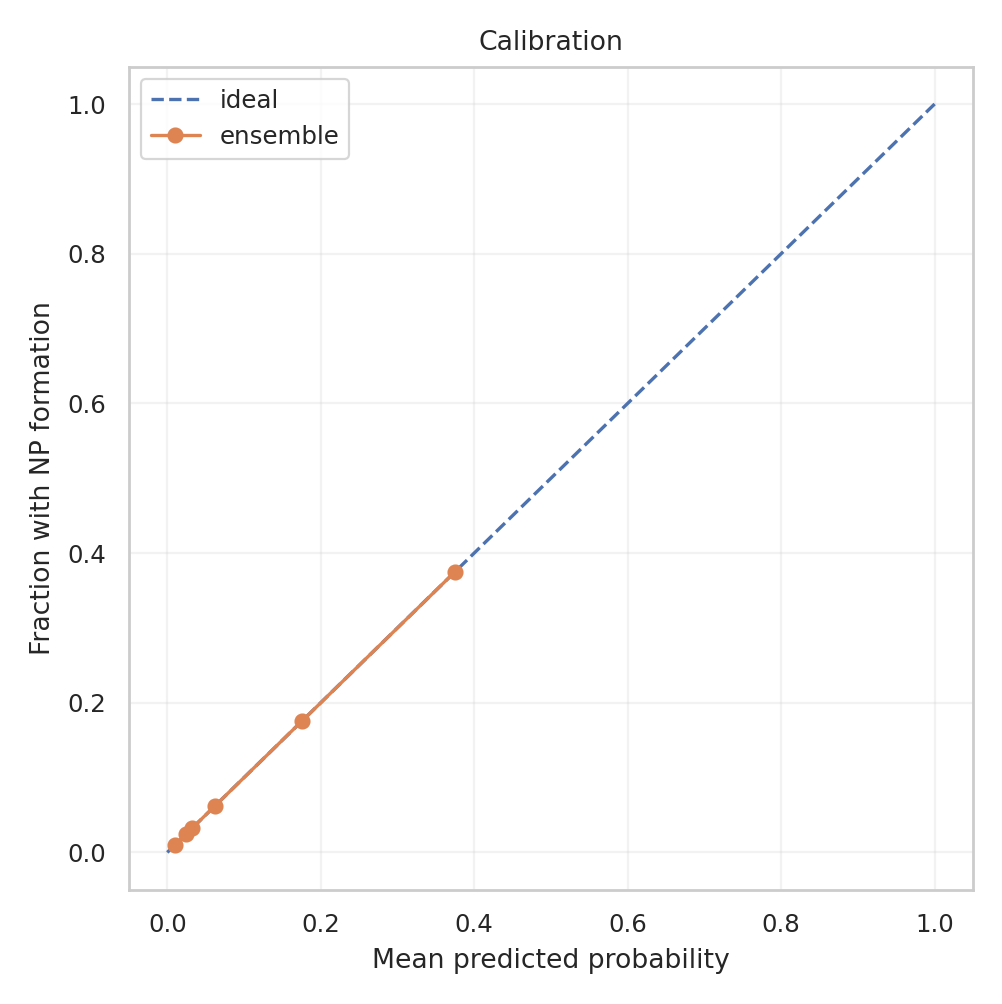

{'n': 1440,
 'threshold': 0.14754098360655737,
 'avg_precision': 0.3095772688818106,
 'accuracy': 0.8458333333333333,
 'f1': 0.3657142857142857,
 'mcc': 0.34772771871631275,
 'precision': 0.25,
 'recall': 0.6808510638297872,
 'balanced_accuracy': 0.7691030950649679,
 'specificity': 0.8573551263001485,
 'roc_auc': 0.8348099965223988}

In [17]:
# 10) Ensemble + calibration + simple conformal-style uncertainty + metrics
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    balanced_accuracy_score,
    confusion_matrix,
    f1_score,
    matthews_corrcoef,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    recall_score,
    r2_score,
    roc_auc_score,
)
from sklearn.calibration import calibration_curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt


def cls_metrics(y_true, p, threshold=0.5):
    p = np.asarray(p, dtype=float)
    mask = ~np.isnan(p)
    y = np.asarray(y_true, dtype=int)[mask]
    p = p[mask]
    if y.size == 0:
        return {"n": 0}
    pred = (p >= float(threshold)).astype(int)
    out = {
        "n": int(y.size),
        "threshold": float(threshold),
        "avg_precision": float(average_precision_score(y, p)),
        "accuracy": float(accuracy_score(y, pred)),
        "f1": float(f1_score(y, pred, zero_division=0)),
        "mcc": float(matthews_corrcoef(y, pred)),
        "precision": float(precision_score(y, pred, zero_division=0)),
        "recall": float(recall_score(y, pred, zero_division=0)),
        "balanced_accuracy": float(balanced_accuracy_score(y, pred)),
    }
    cm = confusion_matrix(y, pred, labels=[0, 1])
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
        spec = tn / (tn + fp) if (tn + fp) else float("nan")
        out["specificity"] = float(spec)
    if len(np.unique(y)) >= 2:
        out["roc_auc"] = float(roc_auc_score(y, p))
    return out


def reg_metrics(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y = y_true[mask]
    p = y_pred[mask]
    if y.size == 0:
        return {"n": 0}
    return {
        "n": int(y.size),
        "mae": float(mean_absolute_error(y, p)),
        "rmse": float(np.sqrt(mean_squared_error(y, p))),
        "r2": float(r2_score(y, p)),
    }


def select_threshold(y_true, p, mode="f1", min_precision=None, min_recall=None):
    p = np.asarray(p, dtype=float)
    mask = ~np.isnan(p)
    y = np.asarray(y_true, dtype=int)[mask]
    p = p[mask]
    if y.size == 0:
        return 0.5, {"mode": mode, "note": "empty"}

    precision, recall, thresholds = precision_recall_curve(y, p)
    if thresholds.size == 0:
        return 0.5, {"mode": mode, "note": "no_thresholds"}

    precision = precision[:-1]
    recall = recall[:-1]

    mode_s = str(mode).strip().lower()

    f1 = 2 * precision * recall / (precision + recall + 1e-12)

    beta = None
    if mode_s.startswith("f"):
        try:
            beta = float(mode_s[1:])
        except Exception:
            beta = None

    score_name = "f1"
    score = f1

    if beta is not None:
        b2 = beta * beta
        score = (1 + b2) * precision * recall / (b2 * precision + recall + 1e-12)
        score_name = f"f{beta:g}"
    elif mode_s == "precision":
        score = precision
        score_name = "precision"
    elif mode_s == "recall":
        score = recall
        score_name = "recall"

    keep = np.ones_like(score, dtype=bool)
    if min_precision is not None:
        keep &= precision >= float(min_precision)
    if min_recall is not None:
        keep &= recall >= float(min_recall)

    if not np.any(keep):
        idx = int(np.nanargmax(score))
        return float(thresholds[idx]), {
            "mode": f"max_{score_name}_fallback",
            "precision": float(precision[idx]),
            "recall": float(recall[idx]),
            "f1": float(f1[idx]),
            score_name: float(score[idx]),
        }

    masked_score = np.where(keep, score, -np.inf)
    idx = int(np.nanargmax(masked_score))

    return float(thresholds[idx]), {
        "mode": mode,
        "precision": float(precision[idx]),
        "recall": float(recall[idx]),
        "f1": float(f1[idx]),
        score_name: float(score[idx]),
    }
def fit_and_apply_calibrator(p_raw):
    p_raw = np.asarray(p_raw, dtype=float)
    mask = ~np.isnan(p_raw)
    if int(mask.sum()) == 0:
        return None, p_raw
    calib = cap.calibrate_prob(p_raw[mask], y_cls[mask], method="isotonic")
    out = np.full_like(p_raw, np.nan, dtype=float)
    out[mask] = cap.apply_calibrator(calib, p_raw[mask])
    return calib, out


parts = []
calib_ebm, p_ebm = (None, None)
if ebm_models:
    calib_ebm, p_ebm = fit_and_apply_calibrator(oof_ebm_prob)
    parts.append(("ebm", p_ebm))

calib_gbdt, p_gbdt = (None, None)
if gbdt_models:
    calib_gbdt, p_gbdt = fit_and_apply_calibrator(oof_gbdt_prob)
    parts.append(("gbdt", p_gbdt))

# Learn ensemble weights on out-of-fold predictions (compute cost is negligible here).
ensemble_weight_info = {"mode": "uniform"}
ensemble_weight_ebm = 1.0 if ebm_models else 0.0
ensemble_weight_gbdt = 1.0 if gbdt_models else 0.0
if ebm_models and gbdt_models:
    ws = np.linspace(0.0, 1.0, 101)
    ap_scores = []
    m = np.isfinite(p_ebm) & np.isfinite(p_gbdt)
    for w in ws:
        p = w * p_ebm[m] + (1.0 - w) * p_gbdt[m]
        ap_scores.append(float(average_precision_score(y_cls[m], p)))
    best_i = int(np.nanargmax(ap_scores))
    ensemble_weight_ebm = float(ws[best_i])
    ensemble_weight_gbdt = float(1.0 - ensemble_weight_ebm)
    ensemble_weight_info = {
        "mode": "max_avg_precision",
        "w_ebm": ensemble_weight_ebm,
        "w_gbdt": ensemble_weight_gbdt,
        "avg_precision": float(ap_scores[best_i]),
    }

if parts:
    if ebm_models and gbdt_models:
        p_ensemble_raw = ensemble_weight_ebm * p_ebm + ensemble_weight_gbdt * p_gbdt
    else:
        p_ensemble_raw = np.nanmean(np.vstack([p for _, p in parts]), axis=0)
else:
    p_ensemble_raw = np.full((len(pairs),), np.nan)

calib_final, p_ensemble = fit_and_apply_calibrator(p_ensemble_raw)



# Ensure regression label arrays exist before auxiliary baselines
y_radius_eval = np.asarray(globals().get("y_radius_eval", y_reg.get("radius_nm")), dtype=float)
y_sr_eval = np.asarray(globals().get("y_sr_eval", y_reg.get("size_reduction")), dtype=float)

# Target-encoding baseline for radius (drug/excipient identity) to reduce bias on sparse labels
from sklearn.linear_model import Ridge

def _fit_te_model(df, y, *, alpha=3.0):
    df = df.copy()
    y = np.asarray(y, dtype=float)
    mask = np.isfinite(y)
    if int(mask.sum()) < 5:
        return None, None
    df = df.loc[mask]
    y = y[mask]
    global_mean = float(np.nanmean(y))
    drug_stats = df.groupby("drug_name")["y"].agg(["mean", "count"])
    exc_stats = df.groupby("excipient_name")["y"].agg(["mean", "count"])

    def _enc(stats, names):
        aligned = stats.reindex(pd.Index(names, name=stats.index.name))
        means = aligned["mean"].to_numpy(dtype=float)
        counts = aligned["count"].to_numpy(dtype=float)
        out = np.full((len(names),), global_mean, dtype=float)
        ok = np.isfinite(means) & np.isfinite(counts)
        if int(ok.sum()) > 0:
            out[ok] = (counts[ok] * means[ok] + float(alpha) * global_mean) / (counts[ok] + float(alpha))
        return out

    X = np.column_stack([
        _enc(drug_stats, df["drug_name"].tolist()),
        _enc(exc_stats, df["excipient_name"].tolist()),
    ])
    model = Ridge(alpha=1.0)
    model.fit(X, y)
    stats = {"global_mean": global_mean, "drug_stats": drug_stats, "exc_stats": exc_stats, "alpha": float(alpha)}
    return stats, model

def _predict_te_model(df, stats, model):
    if stats is None or model is None:
        return np.full((len(df),), np.nan, dtype=float)
    global_mean = float(stats["global_mean"])
    alpha = float(stats["alpha"])
    drug_stats = stats["drug_stats"]
    exc_stats = stats["exc_stats"]

    def _enc(stats_df, names):
        aligned = stats_df.reindex(pd.Index(names, name=stats_df.index.name))
        means = aligned["mean"].to_numpy(dtype=float)
        counts = aligned["count"].to_numpy(dtype=float)
        out = np.full((len(names),), global_mean, dtype=float)
        ok = np.isfinite(means) & np.isfinite(counts)
        if int(ok.sum()) > 0:
            out[ok] = (counts[ok] * means[ok] + float(alpha) * global_mean) / (counts[ok] + float(alpha))
        return out

    X = np.column_stack([
        _enc(drug_stats, df["drug_name"].tolist()),
        _enc(exc_stats, df["excipient_name"].tolist()),
    ])
    return model.predict(X)

te_radius_oof = np.full((len(pairs),), np.nan, dtype=float)
te_radius_stats = None
te_radius_model = None

try:
    alpha = 3.0
    for sp in splits:
        tr = np.array(sp["train_idx"], dtype=int)
        te = np.array(sp["test_idx"], dtype=int)
        df_tr = pairs.loc[tr, ["drug_name", "excipient_name"]].copy()
        df_tr["y"] = y_radius_eval[tr]
        stats, model = _fit_te_model(df_tr, y_radius_eval[tr], alpha=alpha)
        if stats is None:
            continue
        te_radius_oof[te] = _predict_te_model(pairs.loc[te, ["drug_name", "excipient_name"]], stats, model)

    # Fit on full data for external screening usage
    df_full = pairs.loc[:, ["drug_name", "excipient_name"]].copy()
    df_full["y"] = y_radius_eval
    te_radius_stats, te_radius_model = _fit_te_model(df_full, y_radius_eval, alpha=alpha)
except Exception as e:
    te_radius_oof = np.full((len(pairs),), np.nan, dtype=float)
    te_radius_stats = None
    te_radius_model = None
    print("[te_radius] skipped:", repr(e))


pred_radius_base = np.nanmean(np.vstack([oof_ebm_radius, oof_gbdt_radius, te_radius_oof]), axis=0)
pred_sr_base = np.nanmean(np.vstack([oof_ebm_sr, oof_gbdt_sr]), axis=0)

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import clone

try:
    from lightgbm import LGBMRegressor

    _HAS_LGBM = True
except Exception:
    _HAS_LGBM = False

try:
    from xgboost import XGBRegressor

    _HAS_XGB = True
except Exception:
    _HAS_XGB = False

try:
    from catboost import CatBoostRegressor

    _HAS_CAT = True
except Exception:
    _HAS_CAT = False

if _HAS_CAT:
    from sklearn.base import BaseEstimator, RegressorMixin

    class SklearnCompatibleCatBoostRegressor(BaseEstimator, RegressorMixin):
        def __init__(
            self,
            iterations=2000,
            learning_rate=0.03,
            depth=6,
            l2_leaf_reg=3.0,
            loss_function="MAE",
            random_seed=0,
            verbose=False,
            allow_writing_files=False,
        ):
            self.iterations = iterations
            self.learning_rate = learning_rate
            self.depth = depth
            self.l2_leaf_reg = l2_leaf_reg
            self.loss_function = loss_function
            self.random_seed = random_seed
            self.verbose = verbose
            self.allow_writing_files = allow_writing_files

        def fit(self, X, y):
            self.model_ = CatBoostRegressor(
                iterations=self.iterations,
                learning_rate=self.learning_rate,
                depth=self.depth,
                l2_leaf_reg=self.l2_leaf_reg,
                loss_function=self.loss_function,
                random_seed=self.random_seed,
                verbose=self.verbose,
                allow_writing_files=self.allow_writing_files,
            )
            self.model_.fit(X, y)
            return self

        def predict(self, X):
            return self.model_.predict(X)


# Meta-search controls (keeps the notebook runtime reasonable)
META_SEARCH = CFG.get("training", {}).get("meta_search", {})
META_SEARCH_LEVEL = str(META_SEARCH.get("level", "standard")).strip().lower()
META_SEARCH_TOP_FS = int(META_SEARCH.get("top_feature_sets", 3) or 3)
META_SEARCH_FAST_FOLDS = int(META_SEARCH.get("fast_cv_folds", 3) or 3)
META_SEARCH_CV_FOLDS = int(META_SEARCH.get("cv_folds", 3) or 3)
META_SEARCH_MAX_FEATURES = int(META_SEARCH.get("max_features", 2000) or 2000)
META_SEARCH_USE_CACHE = bool(META_SEARCH.get("use_cache", True))

def _logit(x, eps=1e-3):
    x = np.asarray(x, dtype=float)
    x = np.clip(x, eps, 1.0 - eps)
    return np.log(x / (1.0 - x))

def _expit(x):
    x = np.asarray(x, dtype=float)
    return 1.0 / (1.0 + np.exp(-x))


def _build_candidates(task):
    """Candidate regressors for meta-selection.

    Notes
    -----
    - `standard` keeps the candidate set intentionally small so the notebook stays responsive.
    - Switch `training.meta_search.level` to `full` when you want a broader sweep (slower).
    """

    task = str(task).strip().lower()
    level = str(META_SEARCH_LEVEL).strip().lower()
    candidates = []

    # Linear baselines
    ridge_alphas = [0.1, 1.0, 10.0, 100.0, 1000.0] if level == "full" else [10.0, 100.0]
    for alpha in ridge_alphas:
        candidates.append(
            (
                f"ridge_a{alpha}",
                make_pipeline(
                    SimpleImputer(strategy="median"),
                    StandardScaler(with_mean=True),
                    Ridge(alpha=float(alpha)),
                ),
            )
        )

    # KNN (often strong in low-label regimes)
    knn_metrics = ["manhattan", "euclidean"] if level == "full" else ["manhattan"]
    knn_ks = ([3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25] if level == "full" else [5, 9, 13])
    for metric in knn_metrics:
        for k in knn_ks:
            candidates.append(
                (
                    f"knn(k={k},metric={metric})",
                    make_pipeline(
                        SimpleImputer(strategy="median"),
                        StandardScaler(with_mean=False),
                        KNeighborsRegressor(
                            n_neighbors=int(k),
                            weights="distance",
                            metric=metric,
                        ),
                    ),
                )
            )

    # Boosting libraries (usually strongest)
    if _HAS_LGBM:
        if level == "full":
            if task == "radius":
                lgbm_grid = [
                    ("regression_l1", 0.03, 31, 6),
                    ("regression_l1", 0.05, 63, -1),
                    ("huber", 0.03, 31, 6),
                    ("regression", 0.03, 31, 6),
                ]
            else:
                lgbm_grid = [
                    ("regression", 0.03, 31, 6),
                    ("huber", 0.03, 31, 6),
                ]
        else:
            lgbm_grid = [("regression_l1" if task == "radius" else "regression", 0.03, 31, 6)]

        for objective, lr0, num_leaves, max_depth in lgbm_grid:
            candidates.append(
                (
                    f"lightgbm_{objective}_lr{lr0}_l{num_leaves}_d{max_depth}",
                    make_pipeline(
                        SimpleImputer(strategy="median"),
                        LGBMRegressor(
                            n_estimators=1200 if level == "full" else 600,
                            learning_rate=float(lr0),
                            num_leaves=int(num_leaves),
                            max_depth=int(max_depth),
                            subsample=0.85,
                            colsample_bytree=0.85,
                            reg_alpha=0.1,
                            reg_lambda=1.0,
                            objective=str(objective),
                            random_state=int(CFG["random_seed"]),
                            n_jobs=-1,
                            force_col_wise=True,
                        ),
                    ),
                )
            )

    if _HAS_XGB:
        if level == "full":
            if task == "radius":
                objectives = ["reg:pseudohubererror", "reg:squarederror"]
            else:
                objectives = ["reg:squarederror", "reg:pseudohubererror"]
            depths = [3, 6]
        else:
            objectives = ["reg:absoluteerror", "reg:squarederror"] if task == "radius" else ["reg:squarederror"]
            depths = [6]

        for objective in objectives:
            for depth in depths:
                candidates.append(
                    (
                        f"xgb_{objective}_d{depth}",
                        make_pipeline(
                            SimpleImputer(strategy="median"),
                            XGBRegressor(
                                n_estimators=1500 if level == "full" else 600,
                                learning_rate=0.03,
                                max_depth=int(depth),
                                min_child_weight=1.0,
                                subsample=0.85,
                                colsample_bytree=0.85,
                                reg_alpha=0.1,
                                reg_lambda=1.0,
                                objective=str(objective),
                                random_state=int(CFG["random_seed"]),
                                n_jobs=-1,
                                tree_method="hist",
                            ),
                        ),
                    )
                )

    if level != "full":
        # A few strong non-linear candidates (still fast enough for notebooks)
        candidates.append(
            (
                "extra_trees",
                make_pipeline(
                    SimpleImputer(strategy="median"),
                    ExtraTreesRegressor(
                        n_estimators=1200,
                        random_state=int(CFG["random_seed"]),
                        n_jobs=-1,
                        min_samples_leaf=2,
                        max_features="sqrt",
                    ),
                ),
            )
        )
        candidates.append(
            (
                "hist_gbdt_squared_error",
                make_pipeline(
                    SimpleImputer(strategy="median"),
                    HistGradientBoostingRegressor(
                        loss="squared_error",
                        learning_rate=0.05,
                        max_depth=6,
                        max_bins=255,
                        max_iter=600,
                        l2_regularization=0.1,
                        random_state=int(CFG["random_seed"]),
                    ),
                ),
            )
        )
        candidates.append(
            (
                "svr_rbf_c10",
                make_pipeline(
                    SimpleImputer(strategy="median"),
                    StandardScaler(with_mean=True),
                    SVR(C=10.0, gamma="scale", epsilon=0.05, kernel="rbf"),
                ),
            )
        )
        candidates.append(
            (
                "kernel_ridge_rbf_a0.01_g0.01",
                make_pipeline(
                    SimpleImputer(strategy="median"),
                    StandardScaler(with_mean=True),
                    KernelRidge(alpha=1e-2, kernel="rbf", gamma=1e-2),
                ),
            )
        )
        if _HAS_CAT:
            candidates.append(
                (
                    "catboost_mae",
                    make_pipeline(
                        SimpleImputer(strategy="median"),
                        SklearnCompatibleCatBoostRegressor(
                            iterations=2500,
                            learning_rate=0.03,
                            depth=6,
                            l2_leaf_reg=3.0,
                            loss_function="MAE",
                            random_seed=int(CFG["random_seed"]),
                            verbose=False,
                            allow_writing_files=False,
                        ),
                    ),
                )
            )
        return candidates

    # Heavier candidates only in FULL mode
    et_n = 1500
    candidates.append(
        (
            "extra_trees",
            make_pipeline(
                SimpleImputer(strategy="median"),
                ExtraTreesRegressor(
                    n_estimators=int(et_n),
                    random_state=int(CFG["random_seed"]),
                    n_jobs=-1,
                    min_samples_leaf=2,
                    max_features="sqrt",
                ),
            ),
        )
    )

    for loss in ["absolute_error", "squared_error"]:
        candidates.append(
            (
                f"hist_gbdt_{loss}",
                make_pipeline(
                    SimpleImputer(strategy="median"),
                    HistGradientBoostingRegressor(
                        loss=loss,
                        learning_rate=0.05,
                        max_depth=6,
                        max_bins=255,
                        max_iter=800,
                        l2_regularization=0.1,
                        random_state=int(CFG["random_seed"]),
                    ),
                ),
            )
        )

    # Kernel methods (operate in transformed target-space)
    svr_grid = [(1.0, "scale", 0.05), (10.0, "scale", 0.05), (10.0, 0.1, 0.05), (100.0, 0.01, 0.05)]
    krr_grid = [(1e-2, 0.1), (1e-2, 0.01), (1e-1, 0.01), (1.0, 0.001)]

    for c, gamma, eps in svr_grid:
        model = make_pipeline(
            SimpleImputer(strategy="median"),
            StandardScaler(with_mean=True),
            SVR(C=float(c), gamma=gamma, epsilon=float(eps), kernel="rbf"),
        )
        candidates.append((f"svr_rbf_c{c}_g{gamma}_e{eps}", model))

    for alpha, gamma in krr_grid:
        model = make_pipeline(
            SimpleImputer(strategy="median"),
            StandardScaler(with_mean=True),
            KernelRidge(alpha=float(alpha), kernel="rbf", gamma=float(gamma)),
        )
        candidates.append((f"kernel_ridge_rbf_a{alpha}_g{gamma}", model))

    if _HAS_CAT:
        candidates.append(
            (
                "catboost_mae",
                make_pipeline(
                    SimpleImputer(strategy="median"),
                    SklearnCompatibleCatBoostRegressor(
                        iterations=2000,
                        learning_rate=0.03,
                        depth=6,
                        l2_leaf_reg=3.0,
                        loss_function="MAE",
                        random_seed=int(CFG["random_seed"]),
                        verbose=False,
                        allow_writing_files=False,
                    ),
                ),
            )
        )

    return candidates

def _run_meta_selection(
    label,
    y_eval,
    base_pred,
    feature_sets,
    candidates,
    transform,
    inverse_transform,
    clip_range=None,
    score_mode="mae",
):
    pred = base_pred.copy()
    meta_model = None
    meta_info = {"method": "none"}

    meta_mask = np.isfinite(y_eval)
    n_labeled = int(meta_mask.sum())
    meta_info["n_labeled"] = n_labeled

    cache_path = None
    if META_SEARCH_USE_CACHE:
        try:
            cache_key = f"v7_{label}_{META_SEARCH_LEVEL}_k{META_SEARCH_TOP_FS}_f{META_SEARCH_CV_FOLDS}_mf{META_SEARCH_MAX_FEATURES}"
            cache_path = Path(CFG["paths"]["models_dir"]) / f"meta_{cache_key}.pkl"
            if cache_path.exists():
                cached = pickle.load(open(cache_path, "rb"))
                if isinstance(cached, dict) and "pred" in cached:
                    cached_pred = np.asarray(cached["pred"], dtype=float)
                    cached_info = cached.get("info", {}) if isinstance(cached.get("info", {}), dict) else {}
                    cached_model = None
                    try:
                        best_name = str(cached_info.get("best_model", ""))
                        best_fs = str(cached_info.get("feature_set", ""))
                        cand = None
                        for n, m in candidates:
                            if str(n) == best_name:
                                cand = m
                                break
                        fs_all = None
                        for fs_name, X_all in feature_sets:
                            if str(fs_name) == best_fs:
                                fs_all = X_all
                                break
                        if cand is not None and fs_all is not None:
                            cached_model = clone(cand)
                            X_m = fs_all[meta_mask]
                            y_m = y_eval[meta_mask]
                            cached_model.fit(X_m, transform(y_m))
                    except Exception:
                        cached_model = None
                    return cached_pred, cached_model, cached_info
        except Exception:
            cache_path = None

    if n_labeled < 20:
        meta_info["note"] = "insufficient_labels"
        return pred, meta_model, meta_info

    y_m = y_eval[meta_mask]
    kf = KFold(n_splits=int(max(2, META_SEARCH_CV_FOLDS)), shuffle=True, random_state=int(CFG["random_seed"]))

    def _inverse_safe(z):
        z = np.asarray(z, dtype=float)
        if label == 'size_reduction':
            z = np.clip(z, -50.0, 50.0)
        elif label == 'radius':
            if clip_range is not None:
                lo = float(np.log1p(max(float(clip_range[0]), 0.0)))
                hi = float(np.log1p(max(float(clip_range[1]), 0.0)))
                z = np.clip(z, lo - 2.0, hi + 2.0)
            else:
                z = np.clip(z, -5.0, 10.0)
        y = inverse_transform(z)
        y = np.asarray(y, dtype=float)
        y[~np.isfinite(y)] = np.nan
        return y


    score_mode = str(score_mode).strip().lower()
    best_score = -np.inf if score_mode == "r2" else np.inf

    # Pre-select a few strong feature sets to keep runtime reasonable
    feature_sets_use = list(feature_sets)
    if META_SEARCH_LEVEL != "full":
        if label == 'radius':
            _allow = {
                'desc',
                'pair',
                'id',
                'desc+id',
                'pair+id',
                'desc+preds',
                'pair+preds',
                'id+preds',
                'desc+id+preds',
                'pair+id+preds',
                'fp_rp',
                'fp_rp+preds',
                'desc+sim',
                'desc+sim+preds',
                'pair+sim',
                'pair+sim+preds',
            }
            feature_sets_use = [fs for fs in feature_sets_use if fs[0] in _allow]
        elif label == 'size_reduction':
            _allow = {
                'desc',
                'pair',
                'id',
                'desc+preds',
                'pair+preds',
                'id+preds',
                'fp_rp',
                'fp_rp+preds',
                'desc+id',
                'desc+id+preds',
                'desc+sim',
                'desc+sim+preds',
                'pair+sim',
                'pair+sim+preds',
            }
            feature_sets_use = [fs for fs in feature_sets_use if fs[0] in _allow]
    try:
        top_k = int(max(1, META_SEARCH_TOP_FS))
        n_fast = int(max(2, META_SEARCH_FAST_FOLDS))
        if top_k < len(feature_sets_use):
            kf_fast = KFold(n_splits=n_fast, shuffle=True, random_state=int(CFG["random_seed"]))
            baseline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler(with_mean=True), Ridge(alpha=10.0))
            fs_rows = []
            for fs_name, X_all in feature_sets_use:
                X_m = X_all[meta_mask]
                if int(X_m.shape[1]) > int(META_SEARCH_MAX_FEATURES):
                    continue
                oof = np.full((y_m.shape[0],), np.nan, dtype=float)
                for tr_i, te_i in kf_fast.split(X_m):
                    m_i = clone(baseline)
                    m_i.fit(X_m[tr_i], transform(y_m[tr_i]))
                    p_i = _inverse_safe(m_i.predict(X_m[te_i]))
                    if clip_range is not None:
                        p_i = np.clip(p_i, clip_range[0], clip_range[1])
                    oof[te_i] = p_i
                fs_rows.append({"feature_set": fs_name, "cv_mae": float(mean_absolute_error(y_m, oof)), "cv_r2": float(r2_score(y_m, oof))})
            fs_rank = pd.DataFrame(fs_rows)
            if not fs_rank.empty:
                if score_mode == "r2":
                    fs_rank = fs_rank.sort_values(["cv_r2", "cv_mae"], ascending=[False, True])
                else:
                    fs_rank = fs_rank.sort_values(["cv_mae", "cv_r2"], ascending=[True, False])
                export_table(fs_rank, f"{label}_meta_feature_set_ranking")
                top_names = set(fs_rank.head(top_k)["feature_set"].astype(str).tolist())
                feature_sets_use = [(n, X_all) for (n, X_all) in feature_sets_use if n in top_names]
    except Exception:
        feature_sets_use = list(feature_sets)


    rows = []
    best = None
    for feature_set, meta_X_all in feature_sets_use:
        X_m = meta_X_all[meta_mask]
        for name, model in candidates:
            try:
                oof = np.full((y_m.shape[0],), np.nan, dtype=float)
                for tr_i, te_i in kf.split(X_m):
                    model_i = clone(model)
                    model_i.fit(X_m[tr_i], transform(y_m[tr_i]))
                    pred_i = _inverse_safe(model_i.predict(X_m[te_i]))
                    if clip_range is not None:
                        pred_i = np.clip(pred_i, clip_range[0], clip_range[1])
                    oof[te_i] = pred_i

                mae = float(mean_absolute_error(y_m, oof))
                r2 = float(r2_score(y_m, oof))
                rows.append({"feature_set": feature_set, "model": name, "cv_mae": mae, "cv_r2": r2, "error": ""})

                score_val = r2 if score_mode == "r2" else mae
                better = score_val > best_score if score_mode == "r2" else score_val < best_score
                if better:
                    best_score = score_val
                    best = {
                        "feature_set": feature_set,
                        "name": name,
                        "model": model,
                        "oof": oof,
                        "cv_mae": mae,
                        "cv_r2": r2,
                        "n_features": int(X_m.shape[1]),
                    }
            except Exception as exc:
                rows.append({"feature_set": feature_set, "model": name, "cv_mae": np.nan, "cv_r2": np.nan, "error": type(exc).__name__})
                continue

    meta_scores = pd.DataFrame(rows)
    if "feature_set" in meta_scores.columns:
        meta_scores["label"] = meta_scores["feature_set"].astype(str) + " / " + meta_scores["model"].astype(str)
    else:
        meta_scores["label"] = meta_scores["model"].astype(str)
    if score_mode == "r2":
        meta_scores = meta_scores.sort_values(["cv_r2", "cv_mae"], ascending=[False, True])
    else:
        meta_scores = meta_scores.sort_values(["cv_mae", "cv_r2"], ascending=[True, False])
    export_table(meta_scores, f"{label}_meta_model_selection")

    if not meta_scores.empty:
        top = meta_scores.head(10).iloc[::-1]
        fig, ax = plt.subplots(figsize=(6.8, 3.6))
        ax.barh(top["label"], top["cv_mae"], color="#4C72B0")
        ax.set_title(f"{label.replace('_', ' ').title()} meta-model selection (CV MAE)")
        ax.set_xlabel("MAE")
        savefig(fig, f"{label}_meta_model_selection_top10")

    if best is None:
        meta_info["note"] = "no_valid_model"
        meta_info["n_labeled"] = int(meta_mask.sum())
        return pred, meta_model, meta_info

    pred[meta_mask] = best["oof"]

    best_fs = str(best.get("feature_set", ""))
    meta_info = {
        "method": "meta_model_selection",
        "best_model": str(best["name"]),
        "cv_mae": float(best["cv_mae"]),
        "cv_r2": float(best["cv_r2"]),
        "n_labeled": int(y_m.shape[0]),
        "feature_set": best_fs,
        "n_features": int(best.get("n_features", 0) or 0),
        "clip_range": list(clip_range) if clip_range is not None else None,
        "score_mode": score_mode,
        "uses_fp": bool("fp" in best_fs),
    }

    meta_model = best["model"]
    X_fit = None
    X_all_best = None
    for fs_name, X_all in feature_sets:
        if fs_name == best_fs:
            X_fit = X_all[meta_mask]
            X_all_best = X_all
            break
    if X_fit is not None:
        meta_model.fit(X_fit, transform(y_m))
        # Use the fitted meta-model for unlabeled samples (no leakage),
        # but keep OOF predictions on labeled samples for honest metrics.
        try:
            if X_all_best is not None:
                pred_full = _inverse_safe(meta_model.predict(X_all_best))
                if clip_range is not None:
                    pred_full = np.clip(pred_full, clip_range[0], clip_range[1])
                pred[:] = pred_full
                pred[meta_mask] = best["oof"]
        except Exception:
            pass

    if cache_path is not None and META_SEARCH_USE_CACHE:
        tmp_path = None
        try:
            tmp_path = Path(str(cache_path) + ".tmp")
            pickle.dump({"pred": pred, "info": meta_info}, open(tmp_path, "wb"))
            tmp_path.replace(cache_path)
        except Exception:
            try:
                if tmp_path is not None and tmp_path.exists():
                    tmp_path.unlink()
            except Exception:
                pass

    return pred, meta_model, meta_info


y_radius_raw = np.asarray(y_reg["radius_nm"], dtype=float)
qc_radius = CFG.get("qc", {}).get("radius_nm", {})

radius_min = qc_radius.get("min", None)
radius_max = qc_radius.get("max", None)
radius_mad_z = float(qc_radius.get("mad_z", 0.0) or 0.0)

group_mad_z_drug = float(qc_radius.get("group_mad_z_drug", 0.0) or 0.0)
group_mad_z_excipient = float(qc_radius.get("group_mad_z_excipient", 0.0) or 0.0)
group_mad_min_n = int(qc_radius.get("group_mad_min_n", 5) or 5)

radius_mask = np.isfinite(y_radius_raw)
if radius_min is not None:
    radius_mask &= y_radius_raw >= float(radius_min)
if radius_max is not None:
    radius_mask &= y_radius_raw <= float(radius_max)

# Global robust outlier filter (log-space MAD z-score)
if radius_mad_z > 0 and int(radius_mask.sum()) > 5:
    logy = np.log1p(y_radius_raw[radius_mask])
    med = float(np.median(logy))
    mad = float(np.median(np.abs(logy - med)))
    if mad > 0:
        z = np.abs((np.log1p(y_radius_raw) - med) / (1.4826 * mad))
        radius_mask &= z <= radius_mad_z


def _apply_group_mad_filter(mask: np.ndarray, groups: np.ndarray, zthr: float) -> np.ndarray:
    """Within-group robust filtering to drop low-quality radius labels."""
    if float(zthr) <= 0.0:
        return mask
    m = mask.copy()
    idx = np.where(m)[0]
    if int(idx.size) < int(max(6, group_mad_min_n)):
        return m

    g = np.asarray(groups, dtype=str)
    for gv in pd.unique(g[idx]):
        rows = idx[g[idx] == gv]
        if int(rows.size) < int(group_mad_min_n):
            continue
        y = y_radius_raw[rows]
        if not np.isfinite(y).all():
            y = y[np.isfinite(y)]
        if int(y.size) < int(group_mad_min_n):
            continue
        ylog = np.log1p(y)
        med = float(np.median(ylog))
        mad = float(np.median(np.abs(ylog - med)))
        if mad <= 0:
            continue
        z = np.abs((np.log1p(y_radius_raw[rows]) - med) / (1.4826 * mad))
        m[rows] &= z <= float(zthr)

    return m


radius_mask = _apply_group_mad_filter(
    radius_mask,
    pairs["drug_name"].astype(str).to_numpy(),
    group_mad_z_drug,
)
radius_mask = _apply_group_mad_filter(
    radius_mask,
    pairs["excipient_name"].astype(str).to_numpy(),
    group_mad_z_excipient,
)

y_radius_eval = y_radius_raw.copy()
y_radius_eval[~radius_mask] = np.nan

sr_cfg = CFG.get("qc", {}).get("size_reduction", {})
sr_min = float(sr_cfg.get("min", 0.0))
sr_max = float(sr_cfg.get("max", 1.0))

y_sr_raw = np.asarray(y_reg["size_reduction"], dtype=float)
sr_mask = np.isfinite(y_sr_raw) & (y_sr_raw >= sr_min) & (y_sr_raw <= sr_max)
y_sr_eval = y_sr_raw.copy()
y_sr_eval[~sr_mask] = np.nan

# Optional simulation features (if present and joinable).
sim_path = DATA / "simulation_results.tsv"
sim_cols = []
X_sim = None
if sim_path.exists():
    sim_raw = cap.read_tsv_auto(str(sim_path))
    sim_df = sim_raw.rename(columns={"drug": "drug_name", "excipient": "excipient_name"}).copy()
    sim_cols = [c for c in sim_df.columns if c not in {"drug_name", "excipient_name"}]
    for c in sim_cols:
        sim_df[c] = pd.to_numeric(sim_df[c], errors="coerce")
    sim_join = pairs[["drug_name", "excipient_name"]].merge(
        sim_df[["drug_name", "excipient_name"] + sim_cols],
        on=["drug_name", "excipient_name"],
        how="left",
    )
    X_sim = sim_join[sim_cols].to_numpy(dtype=float)

base_pred_features = np.column_stack([
    pred_sr_base.reshape(-1, 1),
    p_ensemble.reshape(-1, 1),
    pred_radius_base.reshape(-1, 1),
])


fp_pair = None
fp_stats = None
if ("fp_drug" in globals()) and (fp_drug is not None) and ("fp_exc" in globals()) and (fp_exc is not None):
    fp_d = fp_drug.loc[pairs["drug_mol_id"].astype(str).tolist()].to_numpy(dtype=float)
    fp_e = fp_exc.loc[pairs["excipient_mol_id"].astype(str).tolist()].to_numpy(dtype=float)
    fp_d = np.nan_to_num(fp_d)
    fp_e = np.nan_to_num(fp_e)
    fp_pair = np.column_stack([fp_d, fp_e])
    inter = np.sum((fp_d > 0) & (fp_e > 0), axis=1)
    union = np.sum((fp_d > 0) | (fp_e > 0), axis=1)
    tanimoto = inter / np.maximum(union, 1)
    fp_stats = np.column_stack([inter, union, tanimoto])

# Dimensionality reduction for meta-selection (keeps runtime reasonable).
# We keep the full fp_pair for the multi-task NN, but use a random projection for meta models.
fp_pair_rp = None
fp_rp = None
if fp_pair is not None and fp_stats is not None:
    try:
        from sklearn.random_projection import SparseRandomProjection

        rp_dim = int(min(512, fp_pair.shape[1]))
        rp = SparseRandomProjection(n_components=rp_dim, random_state=int(CFG["random_seed"]), dense_output=True)
        fp_pair_rp = rp.fit_transform(fp_pair)
        fp_pair_rp = np.asarray(fp_pair_rp, dtype=float)
        fp_rp = np.column_stack([fp_pair_rp, fp_stats])
    except Exception:
        fp_pair_rp = None
        fp_rp = None


# Model C (B+C): Multi-task NN (cls + regressions) to boost regression reliability in a low-label regime
oof_mt_prob = None
oof_mt_radius = None
oof_mt_sr = None
multitask_nn_bundle = None
multitask_nn_info = {"enabled": False}

try:
    import formulens_multitask as fmt

    nn_feature_set = "pair_desc"
    X_nn_parts = [X]
    if fp_pair is not None and fp_stats is not None:
        X_nn_parts.extend([fp_pair, fp_stats])
        nn_feature_set += "+fp"
    if X_sim is not None:
        X_nn_parts.append(X_sim)
        nn_feature_set += "+sim"

    X_nn = np.column_stack(X_nn_parts)

    oof_mt_prob, oof_mt_radius, oof_mt_sr, multitask_nn_bundle, multitask_nn_info = fmt.train_multitask_nn(
        X_nn,
        y_cls=y_cls,
        y_radius=y_radius_eval,
        y_sr=y_sr_eval,
        feature_set=nn_feature_set,
        random_seed=int(CFG["random_seed"]),
        radius_clip=(float(radius_min) if radius_min is not None else 20.0, float(radius_max) if radius_max is not None else 200.0),
        sr_clip=(float(sr_min), float(sr_max)),
        verbose=True,
    )

    # Blend into base regressors (OOF-safe)
    pred_radius_base = np.nanmean(np.vstack([pred_radius_base, oof_mt_radius]), axis=0)
    pred_sr_base = np.nanmean(np.vstack([pred_sr_base, oof_mt_sr]), axis=0)
except Exception as e:
    oof_mt_prob = oof_mt_radius = oof_mt_sr = None
    multitask_nn_bundle = None
    multitask_nn_info = {"enabled": False, "error": repr(e)}
    print("[multitask_nn] skipped:", repr(e))

# Recompute base_pred_features after multitask blend
base_pred_features = np.column_stack([
    pred_sr_base.reshape(-1, 1),
    p_ensemble.reshape(-1, 1),
    pred_radius_base.reshape(-1, 1),
])

# One-hot identity features (drug / excipient).
drug_levels = sorted(pairs["drug_name"].astype(str).unique().tolist())
exc_levels = sorted(pairs["excipient_name"].astype(str).unique().tolist())
drug_map = {n: i for i, n in enumerate(drug_levels)}
exc_map = {n: i for i, n in enumerate(exc_levels)}
drug_idx = pairs["drug_name"].astype(str).map(drug_map).to_numpy(dtype=int)
exc_idx = pairs["excipient_name"].astype(str).map(exc_map).to_numpy(dtype=int)
X_id = np.column_stack([np.eye(len(drug_levels))[drug_idx], np.eye(len(exc_levels))[exc_idx]])

meta_feature_sets_sr = [
    ("desc", np.column_stack([Xd, Xe])),
    ("pair", X),
    ("id", X_id),
    ("desc+id", np.column_stack([Xd, Xe, X_id])),
    ("pair+id", np.column_stack([X, X_id])),
    ("desc+preds", np.column_stack([Xd, Xe, base_pred_features])),
    ("pair+preds", np.column_stack([X, base_pred_features])),
    ("id+preds", np.column_stack([X_id, base_pred_features])),
    ("desc+id+preds", np.column_stack([Xd, Xe, X_id, base_pred_features])),
    ("pair+id+preds", np.column_stack([X, X_id, base_pred_features])),
]
if fp_rp is not None:
    meta_feature_sets_sr.append(("fp_rp", fp_rp))
    meta_feature_sets_sr.append(("fp_rp+preds", np.column_stack([fp_rp, base_pred_features])))
    meta_feature_sets_sr.append(("pair+fp_rp", np.column_stack([X, fp_rp])))
    meta_feature_sets_sr.append(("pair+fp_rp+preds", np.column_stack([X, fp_rp, base_pred_features])))
if X_sim is not None:
    meta_feature_sets_sr.append(("desc+sim", np.column_stack([Xd, Xe, X_sim])))
    meta_feature_sets_sr.append(("desc+sim+preds", np.column_stack([Xd, Xe, X_sim, base_pred_features])))
    meta_feature_sets_sr.append(("pair+sim", np.column_stack([X, X_sim])))
    meta_feature_sets_sr.append(("pair+sim+preds", np.column_stack([X, X_sim, base_pred_features])))

pred_sr = pred_sr_base.copy()
size_reduction_meta_model = None
size_reduction_meta_info = {"method": "none"}

candidates_sr = _build_candidates("size_reduction")
pred_sr, size_reduction_meta_model, size_reduction_meta_info = _run_meta_selection(
    "size_reduction",
    y_sr_eval,
    pred_sr_base,
    meta_feature_sets_sr,
    candidates_sr,
    lambda y: _logit(y, eps=1e-3),
    _expit,
    clip_range=(sr_min, sr_max),
    score_mode="r2",
)

radius_meta_model = None
radius_meta_info = {"method": "none"}
pred_radius = pred_radius_base.copy()

base_pred_features_radius = np.column_stack([
    pred_sr.reshape(-1, 1),
    p_ensemble.reshape(-1, 1),
    pred_radius_base.reshape(-1, 1),
])

meta_feature_sets_radius = [
    ("desc", np.column_stack([Xd, Xe])),
    ("pair", X),
    ("id", X_id),
    ("desc+id", np.column_stack([Xd, Xe, X_id])),
    ("pair+id", np.column_stack([X, X_id])),
    ("desc+preds", np.column_stack([Xd, Xe, base_pred_features_radius])),
    ("pair+preds", np.column_stack([X, base_pred_features_radius])),
    ("id+preds", np.column_stack([X_id, base_pred_features_radius])),
    ("desc+id+preds", np.column_stack([Xd, Xe, X_id, base_pred_features_radius])),
    ("pair+id+preds", np.column_stack([X, X_id, base_pred_features_radius])),
]
if fp_rp is not None:
    meta_feature_sets_radius.append(("fp_rp", fp_rp))
    meta_feature_sets_radius.append(("fp_rp+preds", np.column_stack([fp_rp, base_pred_features_radius])))
    meta_feature_sets_radius.append(("pair+fp_rp", np.column_stack([X, fp_rp])))
    meta_feature_sets_radius.append(("pair+fp_rp+preds", np.column_stack([X, fp_rp, base_pred_features_radius])))
if X_sim is not None:
    meta_feature_sets_radius.append(("desc+sim", np.column_stack([Xd, Xe, X_sim])))
    meta_feature_sets_radius.append(("desc+sim+preds", np.column_stack([Xd, Xe, X_sim, base_pred_features_radius])))
    meta_feature_sets_radius.append(("pair+sim", np.column_stack([X, X_sim])))
    meta_feature_sets_radius.append(("pair+sim+preds", np.column_stack([X, X_sim, base_pred_features_radius])))

candidates_radius = _build_candidates("radius")
pred_radius, radius_meta_model, radius_meta_info = _run_meta_selection(
    "radius",
    y_radius_eval,
    pred_radius_base,
    meta_feature_sets_radius,
    candidates_radius,
    np.log1p,
    np.expm1,
    clip_range=(float(radius_min) if radius_min is not None else 20.0, float(radius_max) if radius_max is not None else 200.0),
    score_mode="r2",
)

radius_meta_info["qc"] = {
    "mad_z": radius_mad_z,
    "n_total": int(np.isfinite(y_radius_raw).sum()),
    "n_kept": int(np.isfinite(y_radius_eval).sum()),
    "n_dropped": int(np.isfinite(y_radius_raw).sum() - np.isfinite(y_radius_eval).sum()),
}
size_reduction_meta_info["qc"] = {
    "min": sr_min,
    "max": sr_max,
    "n_total": int(np.isfinite(y_sr_raw).sum()),
    "n_kept": int(np.isfinite(y_sr_eval).sum()),
    "n_dropped": int(np.isfinite(y_sr_raw).sum() - np.isfinite(y_sr_eval).sum()),
}
alpha = float(CFG["uncertainty"]["alpha"])
conf_cls = cap.conformal_classification(p_ensemble, y_cls, alpha=alpha) if parts else {"alpha": alpha, "q": float("nan")}
conf_radius = cap.conformal_regression(pred_radius, y_radius_eval, alpha=alpha)
conf_sr = cap.conformal_regression(pred_sr, y_sr_eval, alpha=alpha)

thr_cfg = CFG.get("training", {}).get("cls_threshold", {})
cls_threshold, cls_threshold_info = select_threshold(
    y_cls,
    p_ensemble,
    mode=thr_cfg.get("mode", "f1"),
    min_precision=thr_cfg.get("min_precision"),
    min_recall=thr_cfg.get("min_recall"),
)

def topk_metrics(y_true, p, ks=(10, 20, 50, 100, 200, 500)):
    p = np.asarray(p, dtype=float)
    mask = ~np.isnan(p)
    y = np.asarray(y_true, dtype=int)[mask]
    p = p[mask]
    if y.size == 0:
        return {}

    order = np.argsort(-p)
    total_pos = int(y.sum())
    out = {"n": int(y.size), "pos_rate": float(y.mean()), "n_pos": total_pos}
    for k in ks:
        k = int(min(int(k), y.size))
        if k <= 0:
            continue
        yk = y[order[:k]]
        out[f"precision@{k}"] = float(yk.mean())
        out[f"recall@{k}"] = float(yk.sum() / total_pos) if total_pos else float("nan")
    return out


topk = topk_metrics(y_cls, p_ensemble)

metrics = {
    "split_mode": SPLIT_MODE,
    "ebm": {
        "cls": cls_metrics(y_cls, oof_ebm_prob),
        "radius_nm": reg_metrics(y_radius_eval, oof_ebm_radius),
        "size_reduction": reg_metrics(y_sr_eval, oof_ebm_sr),
    },
    "gbdt": {
        "cls": cls_metrics(y_cls, oof_gbdt_prob),
        "radius_nm": reg_metrics(y_radius_eval, oof_gbdt_radius),
        "size_reduction": reg_metrics(y_sr_eval, oof_gbdt_sr),
    },
    "ensemble": {
        "weights": ensemble_weight_info,
        "multitask_nn": multitask_nn_info,
        "topk": topk,
        "cls": cls_metrics(y_cls, p_ensemble, threshold=cls_threshold),
        "cls_default_threshold": cls_metrics(y_cls, p_ensemble, threshold=0.5),
        "cls_threshold_info": cls_threshold_info,
        "radius_nm": reg_metrics(y_radius_eval, pred_radius),
        "radius_meta_info": radius_meta_info,
        "size_reduction": reg_metrics(y_sr_eval, pred_sr),
        "calibration": {"conformal_cls": conf_cls, "conformal_radius": conf_radius, "conformal_sr": conf_sr},
    },
}
cap.safe_write_json(metrics, str(Path(results_dir) / "model_metrics.json"))

if int(np.sum(~np.isnan(p_ensemble))) > 0:
    mask = ~np.isnan(p_ensemble)
    frac_pos, mean_pred = calibration_curve(y_cls[mask], p_ensemble[mask], n_bins=10, strategy="quantile")
    plt.figure(figsize=(5, 5))
    plt.plot([0, 1], [0, 1], "--", label="ideal")
    plt.plot(mean_pred, frac_pos, marker="o", label="ensemble")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction with NP formation")
    plt.title("Calibration")
    plt.legend()
    plt.tight_layout()
    plt.savefig(Path(results_dir) / "calibration_plots.png", dpi=200)
    show_image(Path(results_dir) / "calibration_plots.png")
    plt.close()

metrics["ensemble"]["cls"]








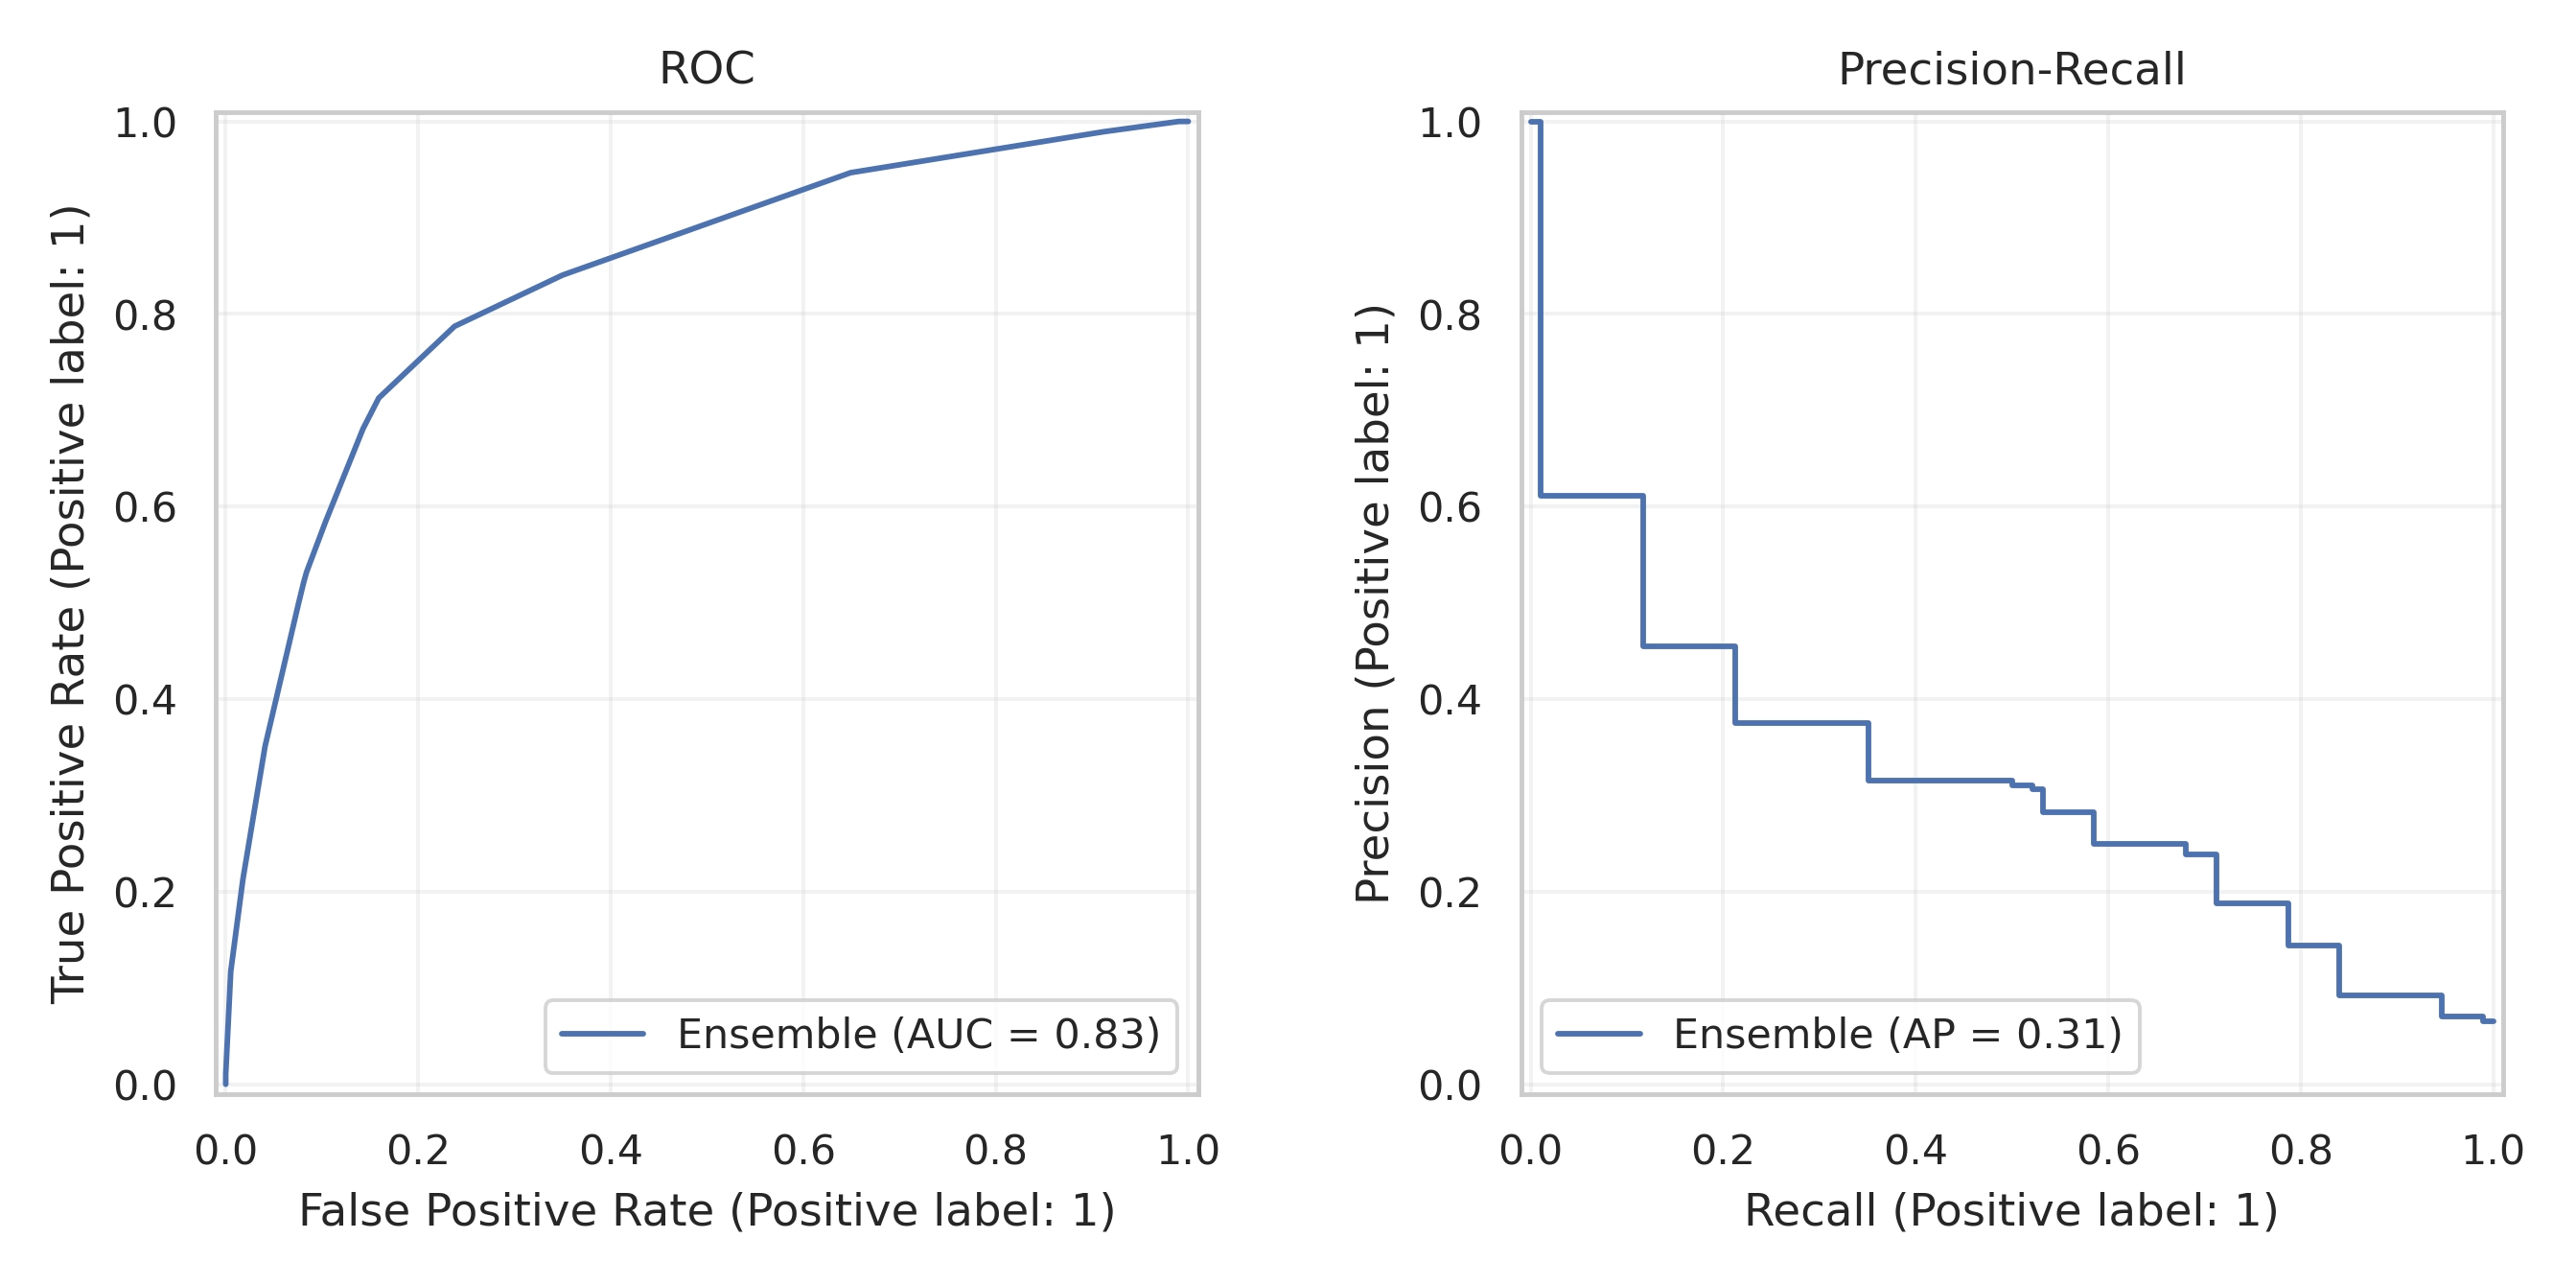

threshold  tp   fp  fn    tn  precision    recall  specificity  accuracy  \
7        0.07  67  214  27  1132   0.238434  0.712766     0.841010  0.832639   
8        0.08  67  214  27  1132   0.238434  0.712766     0.841010  0.832639   
9        0.09  67  214  27  1132   0.238434  0.712766     0.841010  0.832639   
10       0.10  67  214  27  1132   0.238434  0.712766     0.841010  0.832639   
11       0.11  67  214  27  1132   0.238434  0.712766     0.841010  0.832639   
12       0.12  67  214  27  1132   0.238434  0.712766     0.841010  0.832639   
13       0.13  64  192  30  1154   0.250000  0.680851     0.857355  0.845833   
14       0.14  64  192  30  1154   0.250000  0.680851     0.857355  0.845833   
15       0.15  55  140  39  1206   0.282051  0.585106     0.895988  0.875694   
4        0.04  74  320  20  1026   0.187817  0.787234     0.762259  0.763889   
5        0.05  74  320  20  1026   0.187817  0.787234     0.762259  0.763889   
6        0.06  74  320  20  1026   0.187817  0.787234     0.762259  0.763889   
16       0.16  50  113  44  1233   0.306748  0.531915     0.916048  0.890972   
17       0.17  50  113  44  1233   0.306748  0.531915     0.916048  0.890972   
18       0.18  50  113  44  1233   0.306748  0.531915     0.916048  0.890972   
19       0.19  50  113  44  1233   0.306748  0.531915     0.916048  0.890972   
20       0.20  50  113  44  1233   0.306748  0.531915     0.916048  0.890972   
21       0.21  49  109  45  1237   0.310127  0.521277     0.919019  0.893056   
22       0.22  49  109  45  1237   0.310127  0.521277     0.919019  0.893056   
3        0.03  79  471  15   875   0.143636  0.840426     0.650074  0.662500   

          f1        f2  
7   0.357333  0.509893  
8   0.357333  0.509893  
9   0.357333  0.509893  
10  0.357333  0.509893  
11  0.357333  0.509893  
12  0.357333  0.509893  
13  0.365714  0.506329  
14  0.365714  0.506329  
15  0.380623  0.481611  
4   0.303279  0.480519  
5   0.303279  0.480519  
6   0.303279  0.480519  
16  0.389105  0.463822  
17  0.389105  0.463822  
18  0.389105  0.463822  
19  0.389105  0.463822  
20  0.389105  0.463822  
21  0.388889  0.458801  
22  0.388889  0.458801  
3   0.245342  0.426566

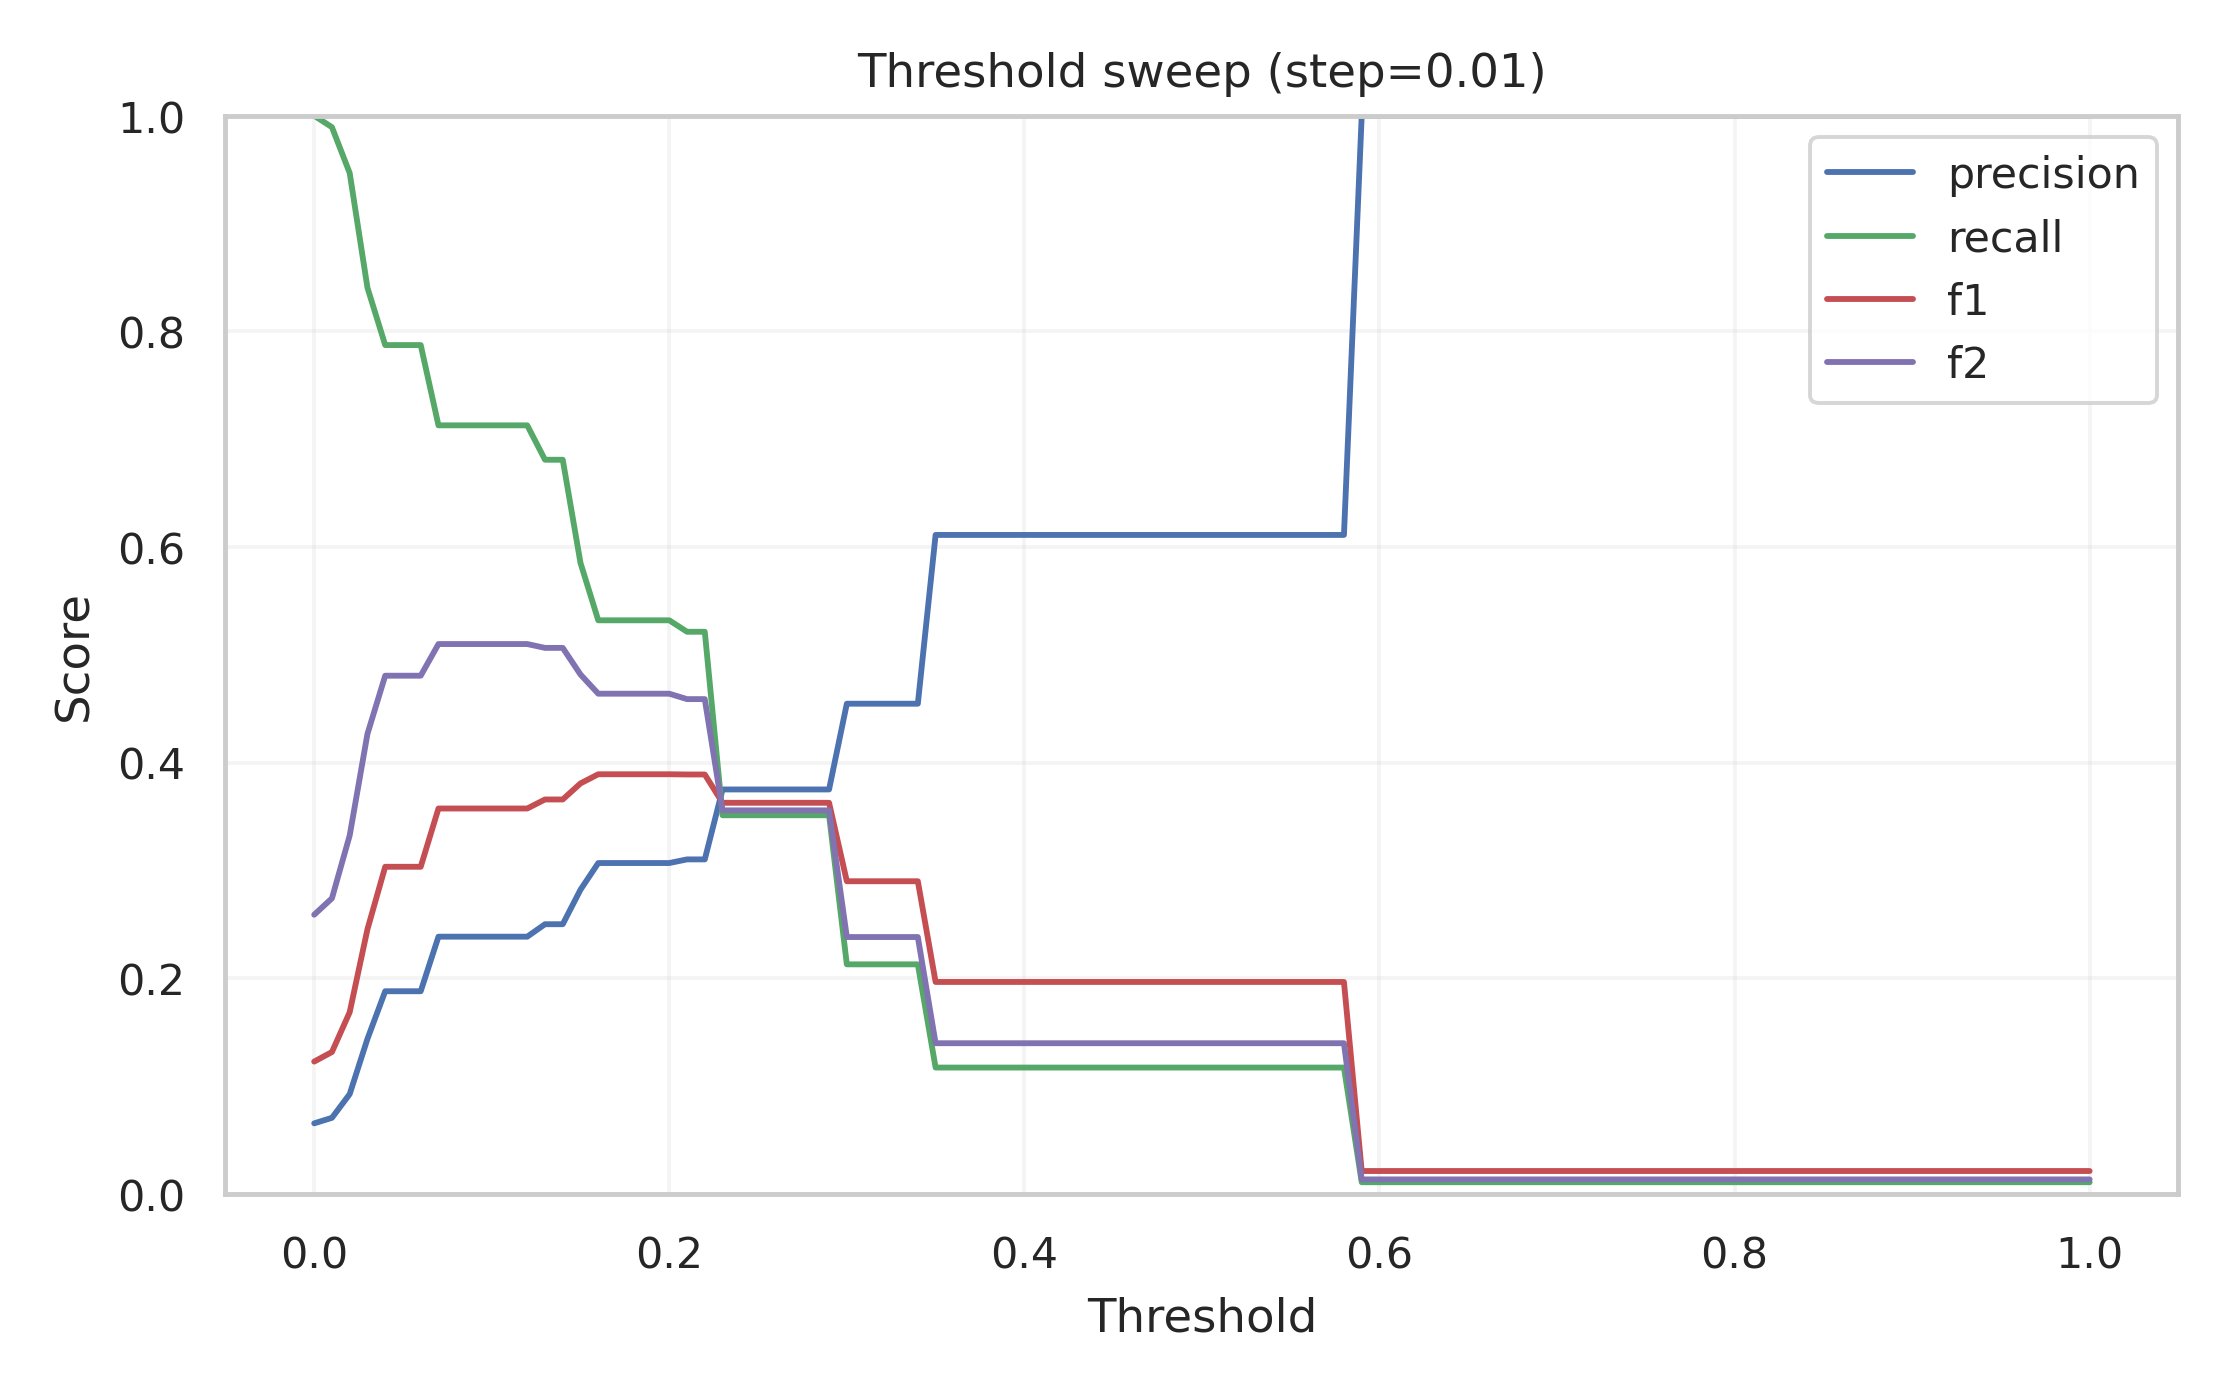

[info] Using cls_threshold_selected=0.10 for downstream steps.


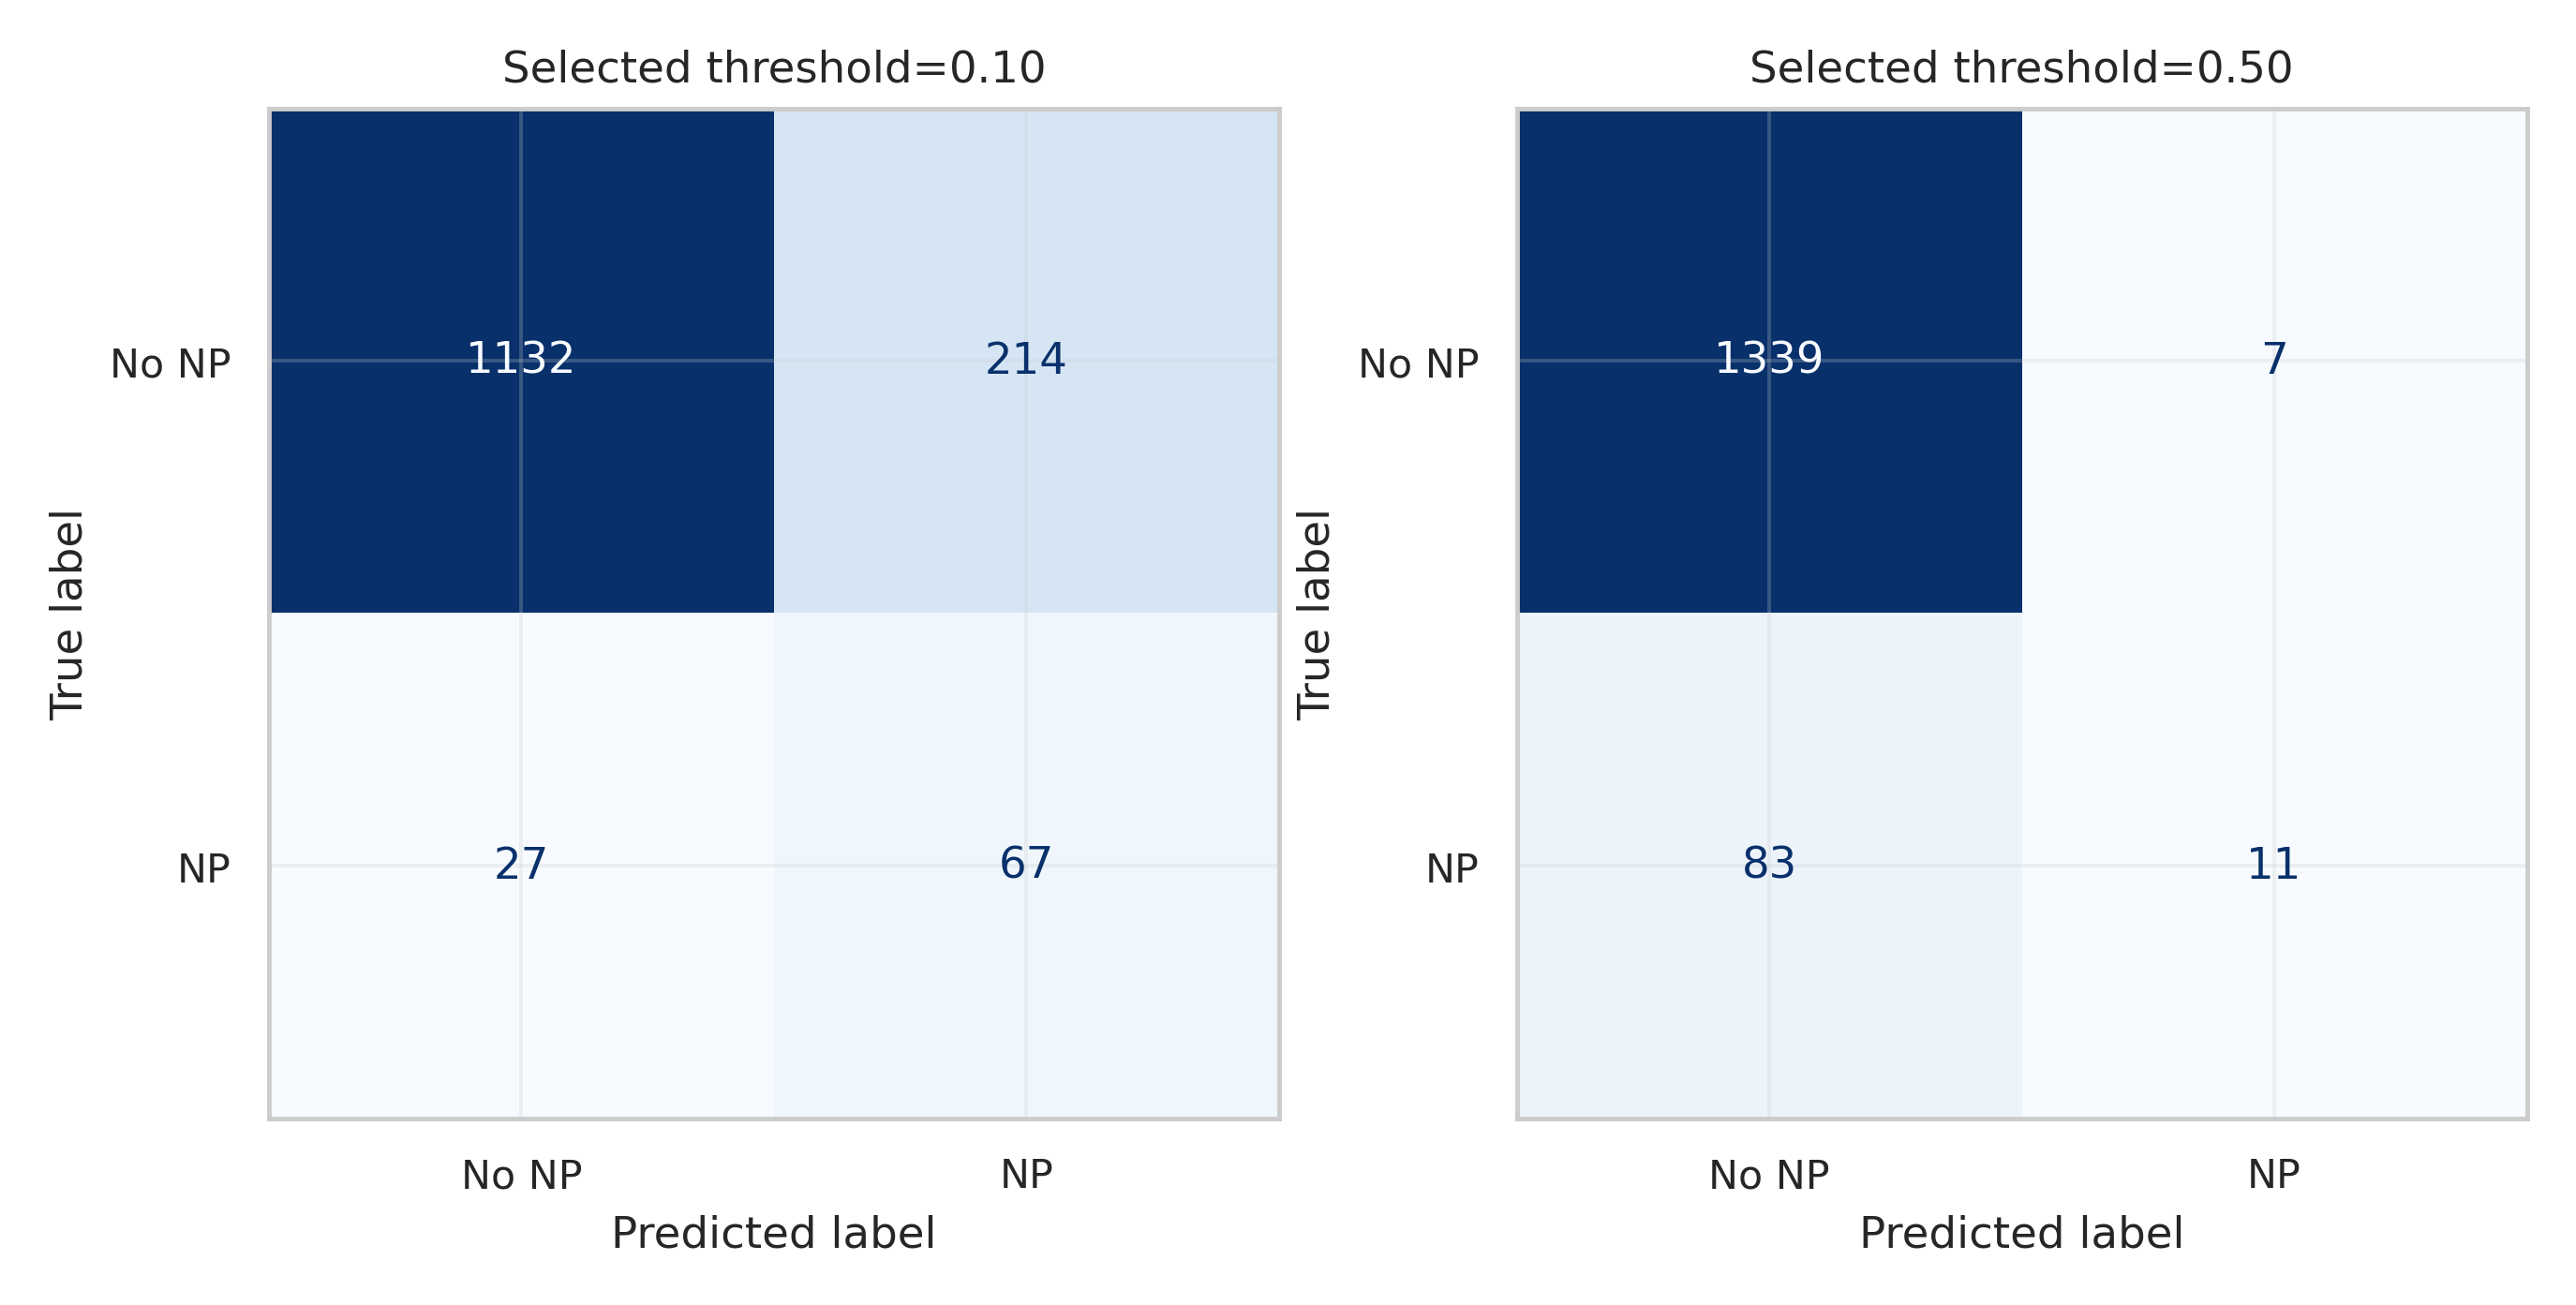

which  threshold  precision    recall        f1        f2    tp     fp  \
0  selected        0.1   0.238434  0.712766  0.357333  0.509893  67.0  214.0   
1  ref_0.50        0.5   0.611111  0.117021  0.196429  0.139594  11.0    7.0   

     fn      tn  
0  27.0  1132.0  
1  83.0  1339.0

Dropdown(description='Threshold', index=10, options=(0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09…

Output()

[info] You can change cls_threshold_selected via the dropdown; rerun downstream cells to apply.


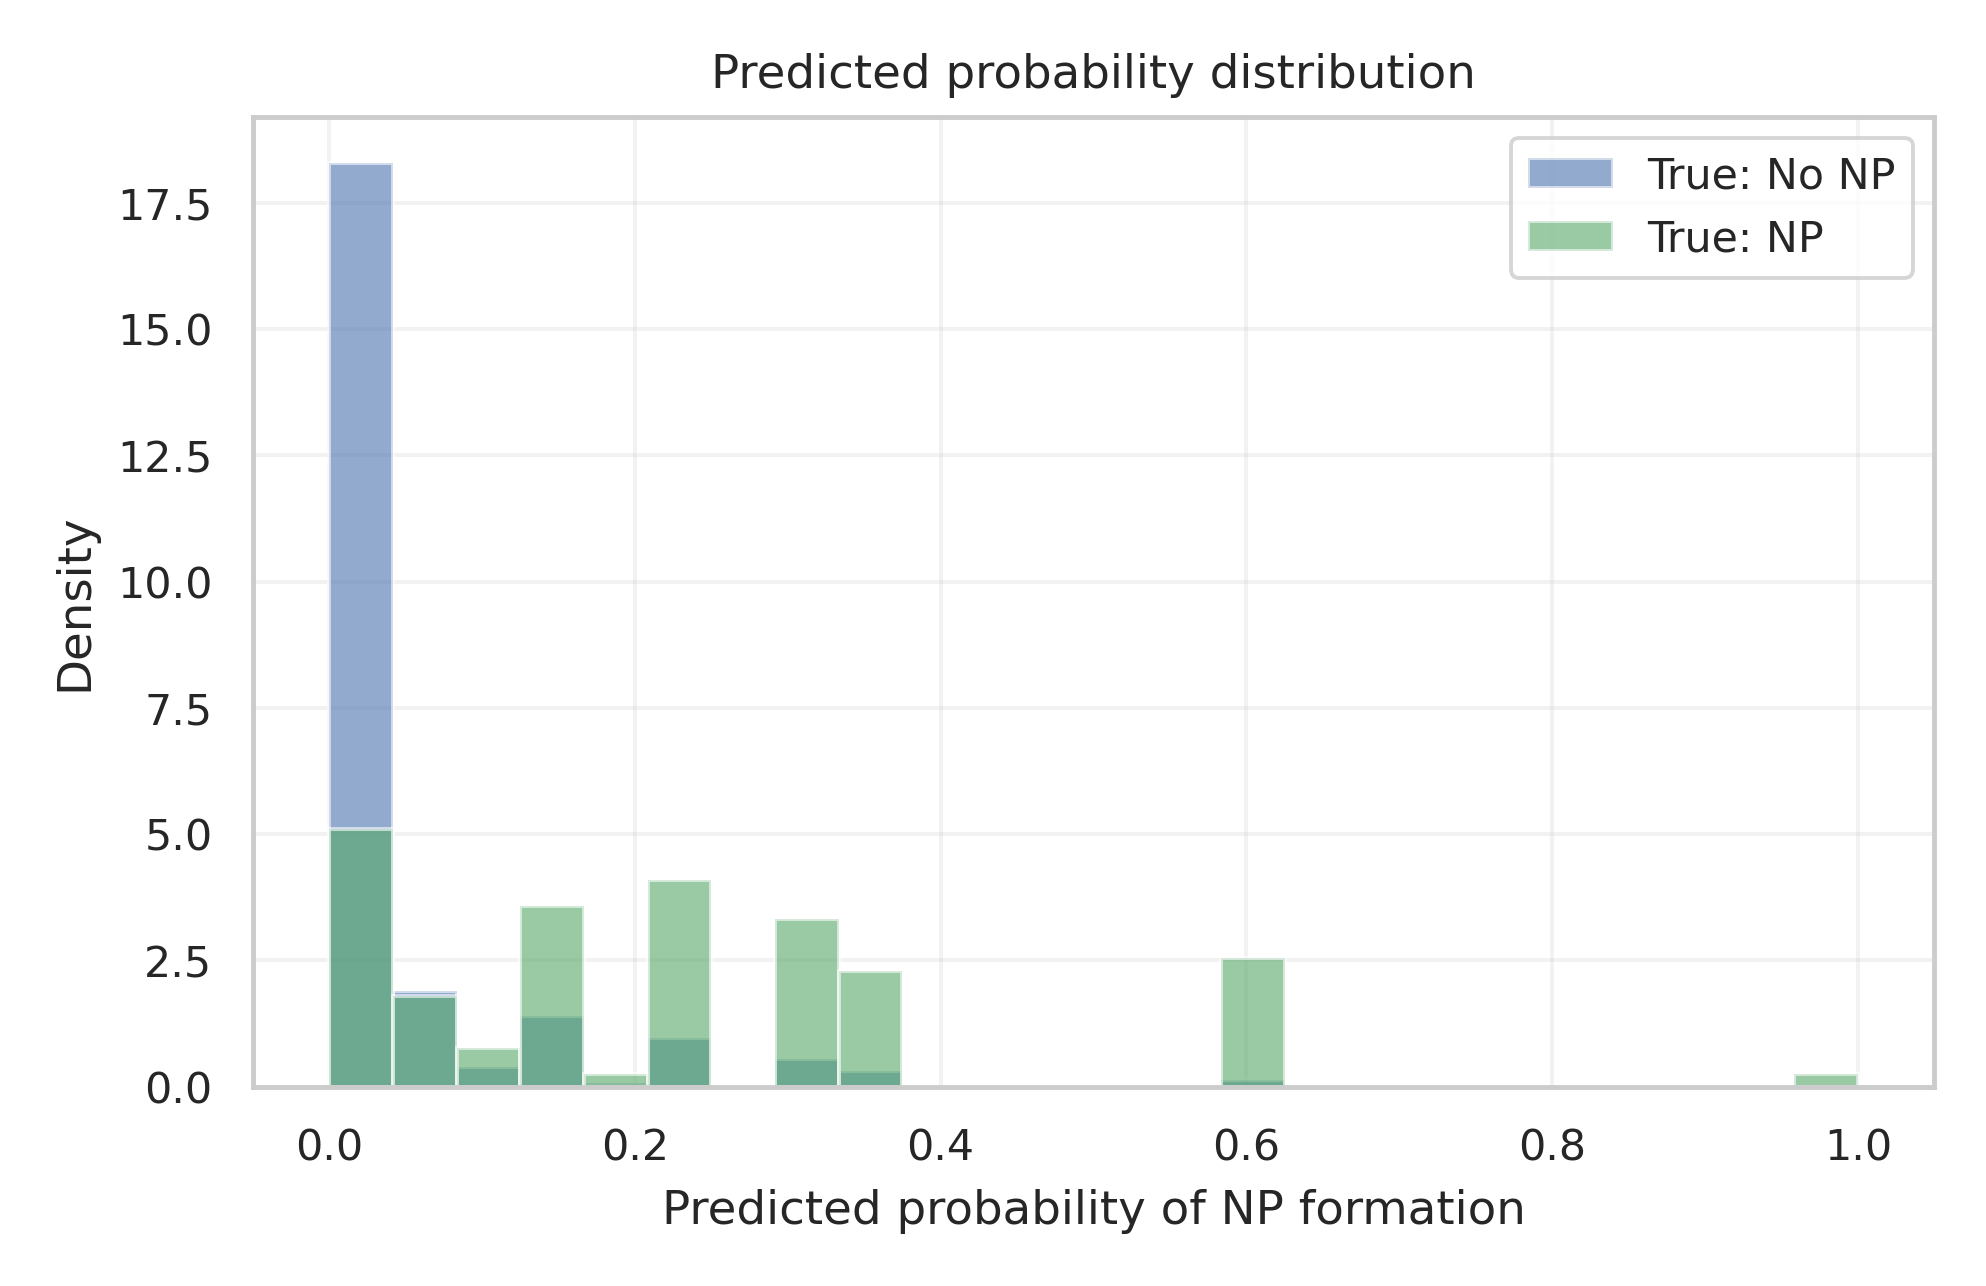

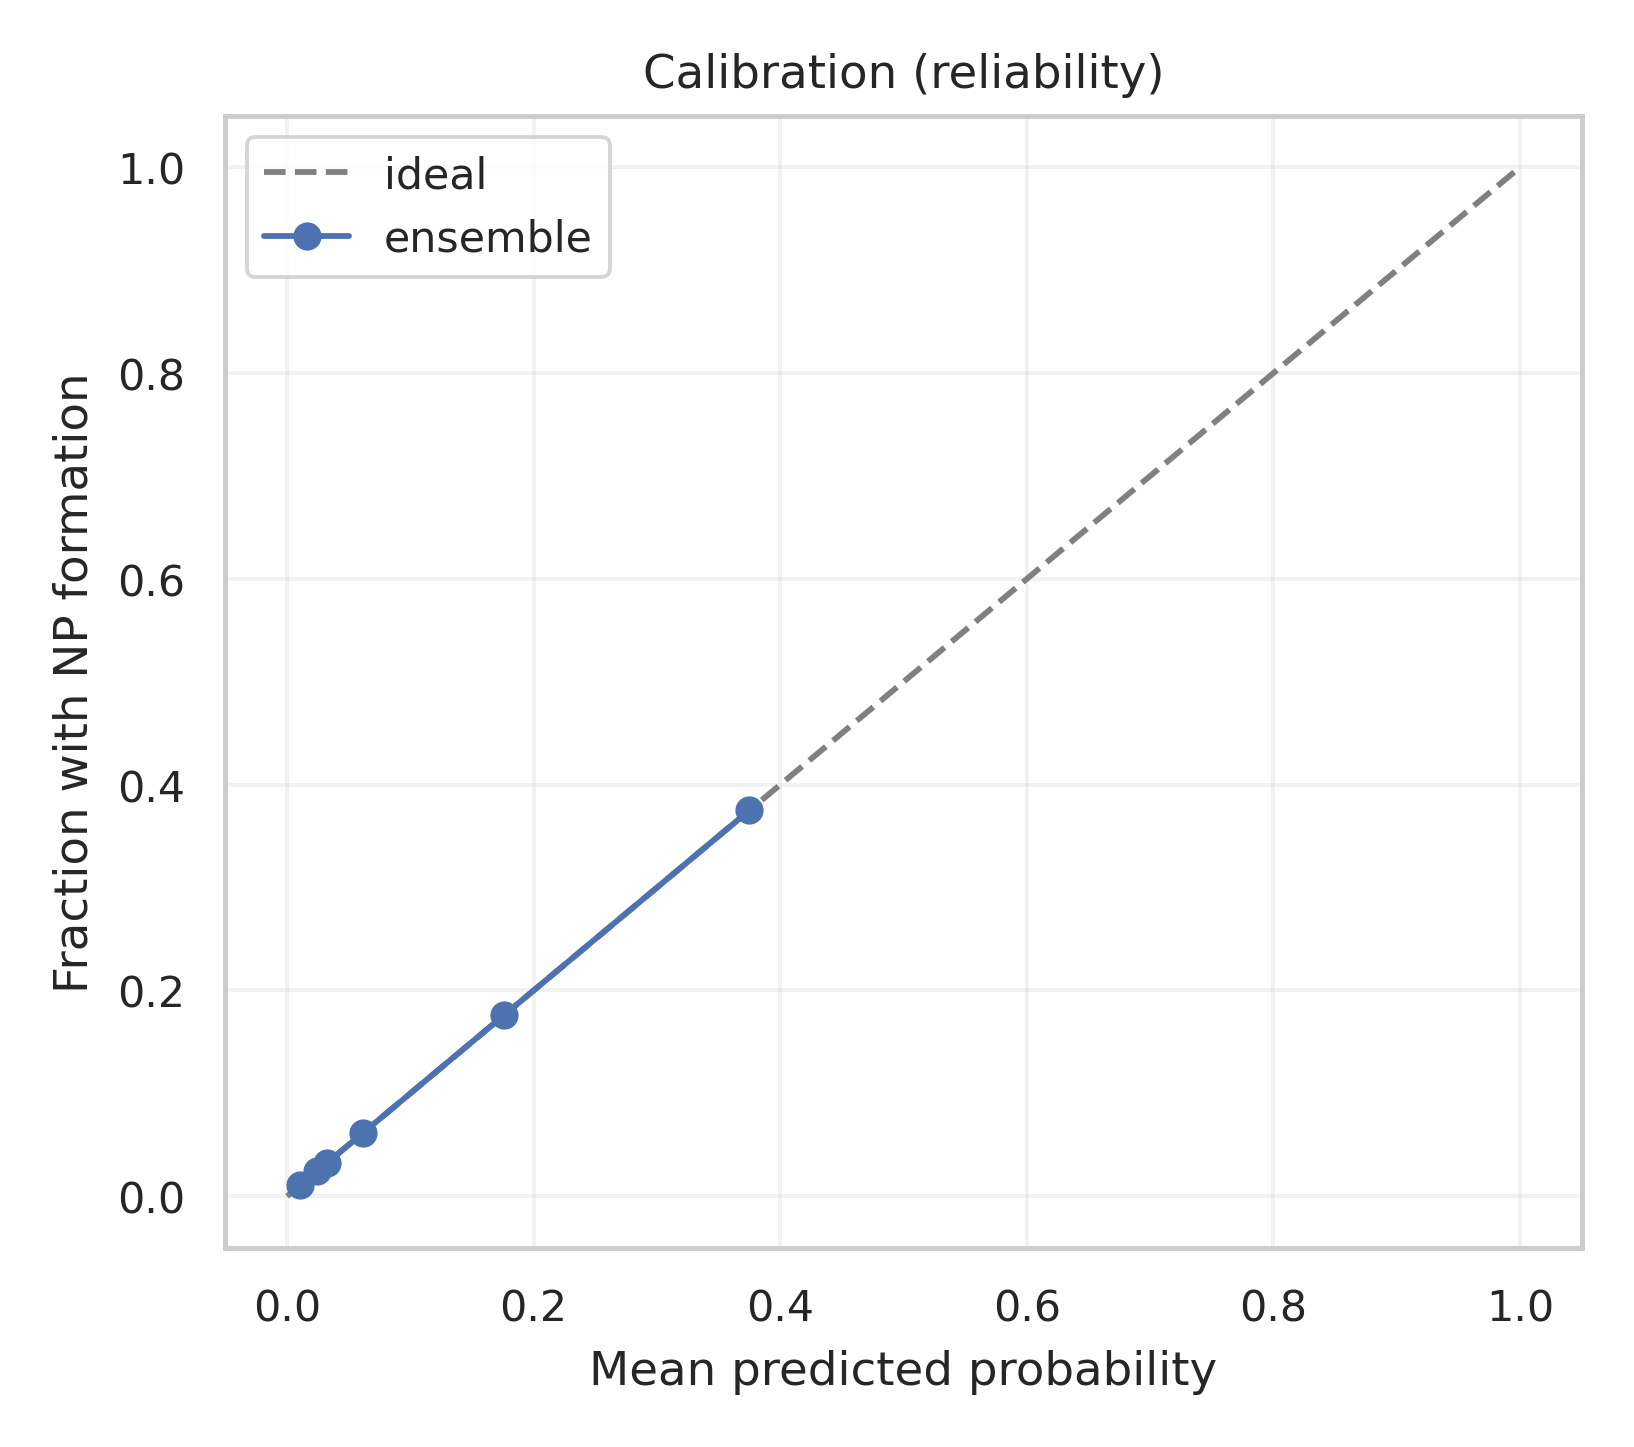

In [18]:
# 20) Classification evaluation figures (ROC/PR + threshold sweep + calibration)
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    confusion_matrix,
)
from sklearn.calibration import calibration_curve


def _mask(y, p):
    p = np.asarray(p, dtype=float)
    m = ~np.isnan(p)
    return np.asarray(y, dtype=int)[m], p[m]


def _cm_stats(y_true, p_prob, thr: float):
    thr = float(thr)
    pred = (np.asarray(p_prob, dtype=float) >= thr).astype(int)
    cm = confusion_matrix(np.asarray(y_true, dtype=int), pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    precision = float(tp / (tp + fp)) if (tp + fp) > 0 else 0.0
    recall = float(tp / (tp + fn)) if (tp + fn) > 0 else 0.0
    specificity = float(tn / (tn + fp)) if (tn + fp) > 0 else 0.0
    accuracy = float((tp + tn) / max(tp + tn + fp + fn, 1))

    f1 = float(2 * precision * recall / (precision + recall + 1e-12))
    beta = 2.0
    b2 = beta * beta
    f2 = float((1 + b2) * precision * recall / (b2 * precision + recall + 1e-12))

    return {
        "threshold": thr,
        "tp": int(tp),
        "fp": int(fp),
        "fn": int(fn),
        "tn": int(tn),
        "precision": precision,
        "recall": recall,
        "specificity": specificity,
        "accuracy": accuracy,
        "f1": f1,
        "f2": f2,
    }, cm


y_m, p_m = _mask(y_cls, p_ensemble)

# ROC/PR overview
fig, axes = plt.subplots(1, 2, figsize=(9.2, 3.8))
RocCurveDisplay.from_predictions(y_m, p_m, ax=axes[0], name="Ensemble")
PrecisionRecallDisplay.from_predictions(y_m, p_m, ax=axes[1], name="Ensemble")
axes[0].set_title("ROC")
axes[1].set_title("Precision-Recall")
savefig(fig, "model_cls_roc_pr")

# Threshold sweep (0.00..1.00, step=0.01)
threshold_grid = np.round(np.arange(0.0, 1.0001, 0.01), 2)
rows = []
for thr in threshold_grid:
    r, _ = _cm_stats(y_m, p_m, float(thr))
    rows.append(r)

thr_sweep = pd.DataFrame(rows)
export_table(thr_sweep, "model_cls_threshold_sweep")

# Quick preview: top-20 thresholds by F2 (lower FN preference)
display(thr_sweep.sort_values(["f2", "f1"], ascending=[False, False]).head(20))

# Metric curves
fig, ax = plt.subplots(figsize=(7.2, 4.0))
ax.plot(thr_sweep["threshold"], thr_sweep["precision"], label="precision", color="#4C72B0")
ax.plot(thr_sweep["threshold"], thr_sweep["recall"], label="recall", color="#55A868")
ax.plot(thr_sweep["threshold"], thr_sweep["f1"], label="f1", color="#C44E52")
ax.plot(thr_sweep["threshold"], thr_sweep["f2"], label="f2", color="#8172B2")
ax.set_title("Threshold sweep (step=0.01)")
ax.set_xlabel("Threshold")
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.2)
ax.legend()
savefig(fig, "model_cls_threshold_sweep")

# Interactive threshold picker (dropdown)
# - left: candidate threshold
# - right: reference threshold=0.50
cls_threshold_selected = float(globals().get("cls_threshold_selected", 0.10))
cls_threshold_selected = float(np.clip(np.round(cls_threshold_selected, 2), 0.0, 1.0))
print(f"[info] Using cls_threshold_selected={cls_threshold_selected:.2f} for downstream steps.")


def _plot_cm_pair(thr_sel: float):
    fig, axes = plt.subplots(1, 2, figsize=(9.0, 4.0))
    for ax, thr in [(axes[0], float(thr_sel)), (axes[1], 0.50)]:
        _, cm = _cm_stats(y_m, p_m, float(thr))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=NP_ORDER)
        disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format="d")
        ax.set_title(f"Selected threshold={thr:.2f}")
    return fig


def _render_threshold(thr_sel: float, *, save: bool = False):
    global cls_threshold_selected
    cls_threshold_selected = float(np.clip(np.round(float(thr_sel), 2), 0.0, 1.0))

    fig = _plot_cm_pair(cls_threshold_selected)
    if save:
        savefig(fig, "model_cls_confusion_matrices")
    else:
        plt.show()

    # Show numeric stats separately (avoid overloading the plot title)
    s_sel = thr_sweep.loc[thr_sweep["threshold"] == float(np.round(cls_threshold_selected, 2))].iloc[0].to_dict()
    s_ref = thr_sweep.loc[thr_sweep["threshold"] == 0.50].iloc[0].to_dict()

    stats = pd.DataFrame([
        {"which": "selected", **s_sel},
        {"which": "ref_0.50", **s_ref},
    ])[[
        "which",
        "threshold",
        "precision",
        "recall",
        "f1",
        "f2",
        "tp",
        "fp",
        "fn",
        "tn",
    ]]
    display(stats)


# Save a static confusion-matrix figure for the default selection
_render_threshold(cls_threshold_selected, save=True)

try:
    import ipywidgets as widgets
    from IPython.display import clear_output, display

    dd = widgets.Dropdown(
        options=[float(x) for x in threshold_grid],
        value=float(cls_threshold_selected),
        description="Threshold",
    )

    out = widgets.Output()

    def _on_change(change):
        if change.get("name") != "value":
            return
        with out:
            clear_output(wait=True)
            _render_threshold(float(change["new"]), save=False)

    dd.observe(_on_change, names="value")

    display(dd)
    display(out)
    with out:
        _render_threshold(float(cls_threshold_selected), save=False)

    print("[info] You can change cls_threshold_selected via the dropdown; rerun downstream cells to apply.")

except Exception as e:
    print("ipywidgets not available; set `cls_threshold_selected` manually.")

# Probability distributions by class
fig, ax = plt.subplots(figsize=(6.2, 3.6))
p0 = p_m[y_m == 0]
p1 = p_m[y_m == 1]
bins = np.linspace(0, 1, 25)
ax.hist(p0, bins=bins, alpha=0.6, label=f"True: {NP_LABELS[0]}", color="#4C72B0", density=True)
ax.hist(p1, bins=bins, alpha=0.6, label=f"True: {NP_LABELS[1]}", color="#55A868", density=True)
ax.set_title("Predicted probability distribution")
ax.set_xlabel("Predicted probability of NP formation")
ax.set_ylabel("Density")
ax.legend()
savefig(fig, "model_cls_score_distributions")

# Reliability diagram
if int(np.sum(~np.isnan(p_ensemble))) > 0:
    fig, ax = plt.subplots(figsize=(5.0, 4.2))
    frac_pos, mean_pred = calibration_curve(y_m, p_m, n_bins=10, strategy="quantile")
    ax.plot([0, 1], [0, 1], "--", color="gray", label="ideal")
    ax.plot(mean_pred, frac_pos, marker="o", label="ensemble")
    ax.set_title("Calibration (reliability)")
    ax.set_xlabel("Mean predicted probability")
    ax.set_ylabel("Fraction with NP formation")
    ax.legend()
    savefig(fig, "model_cls_calibration_reliability")


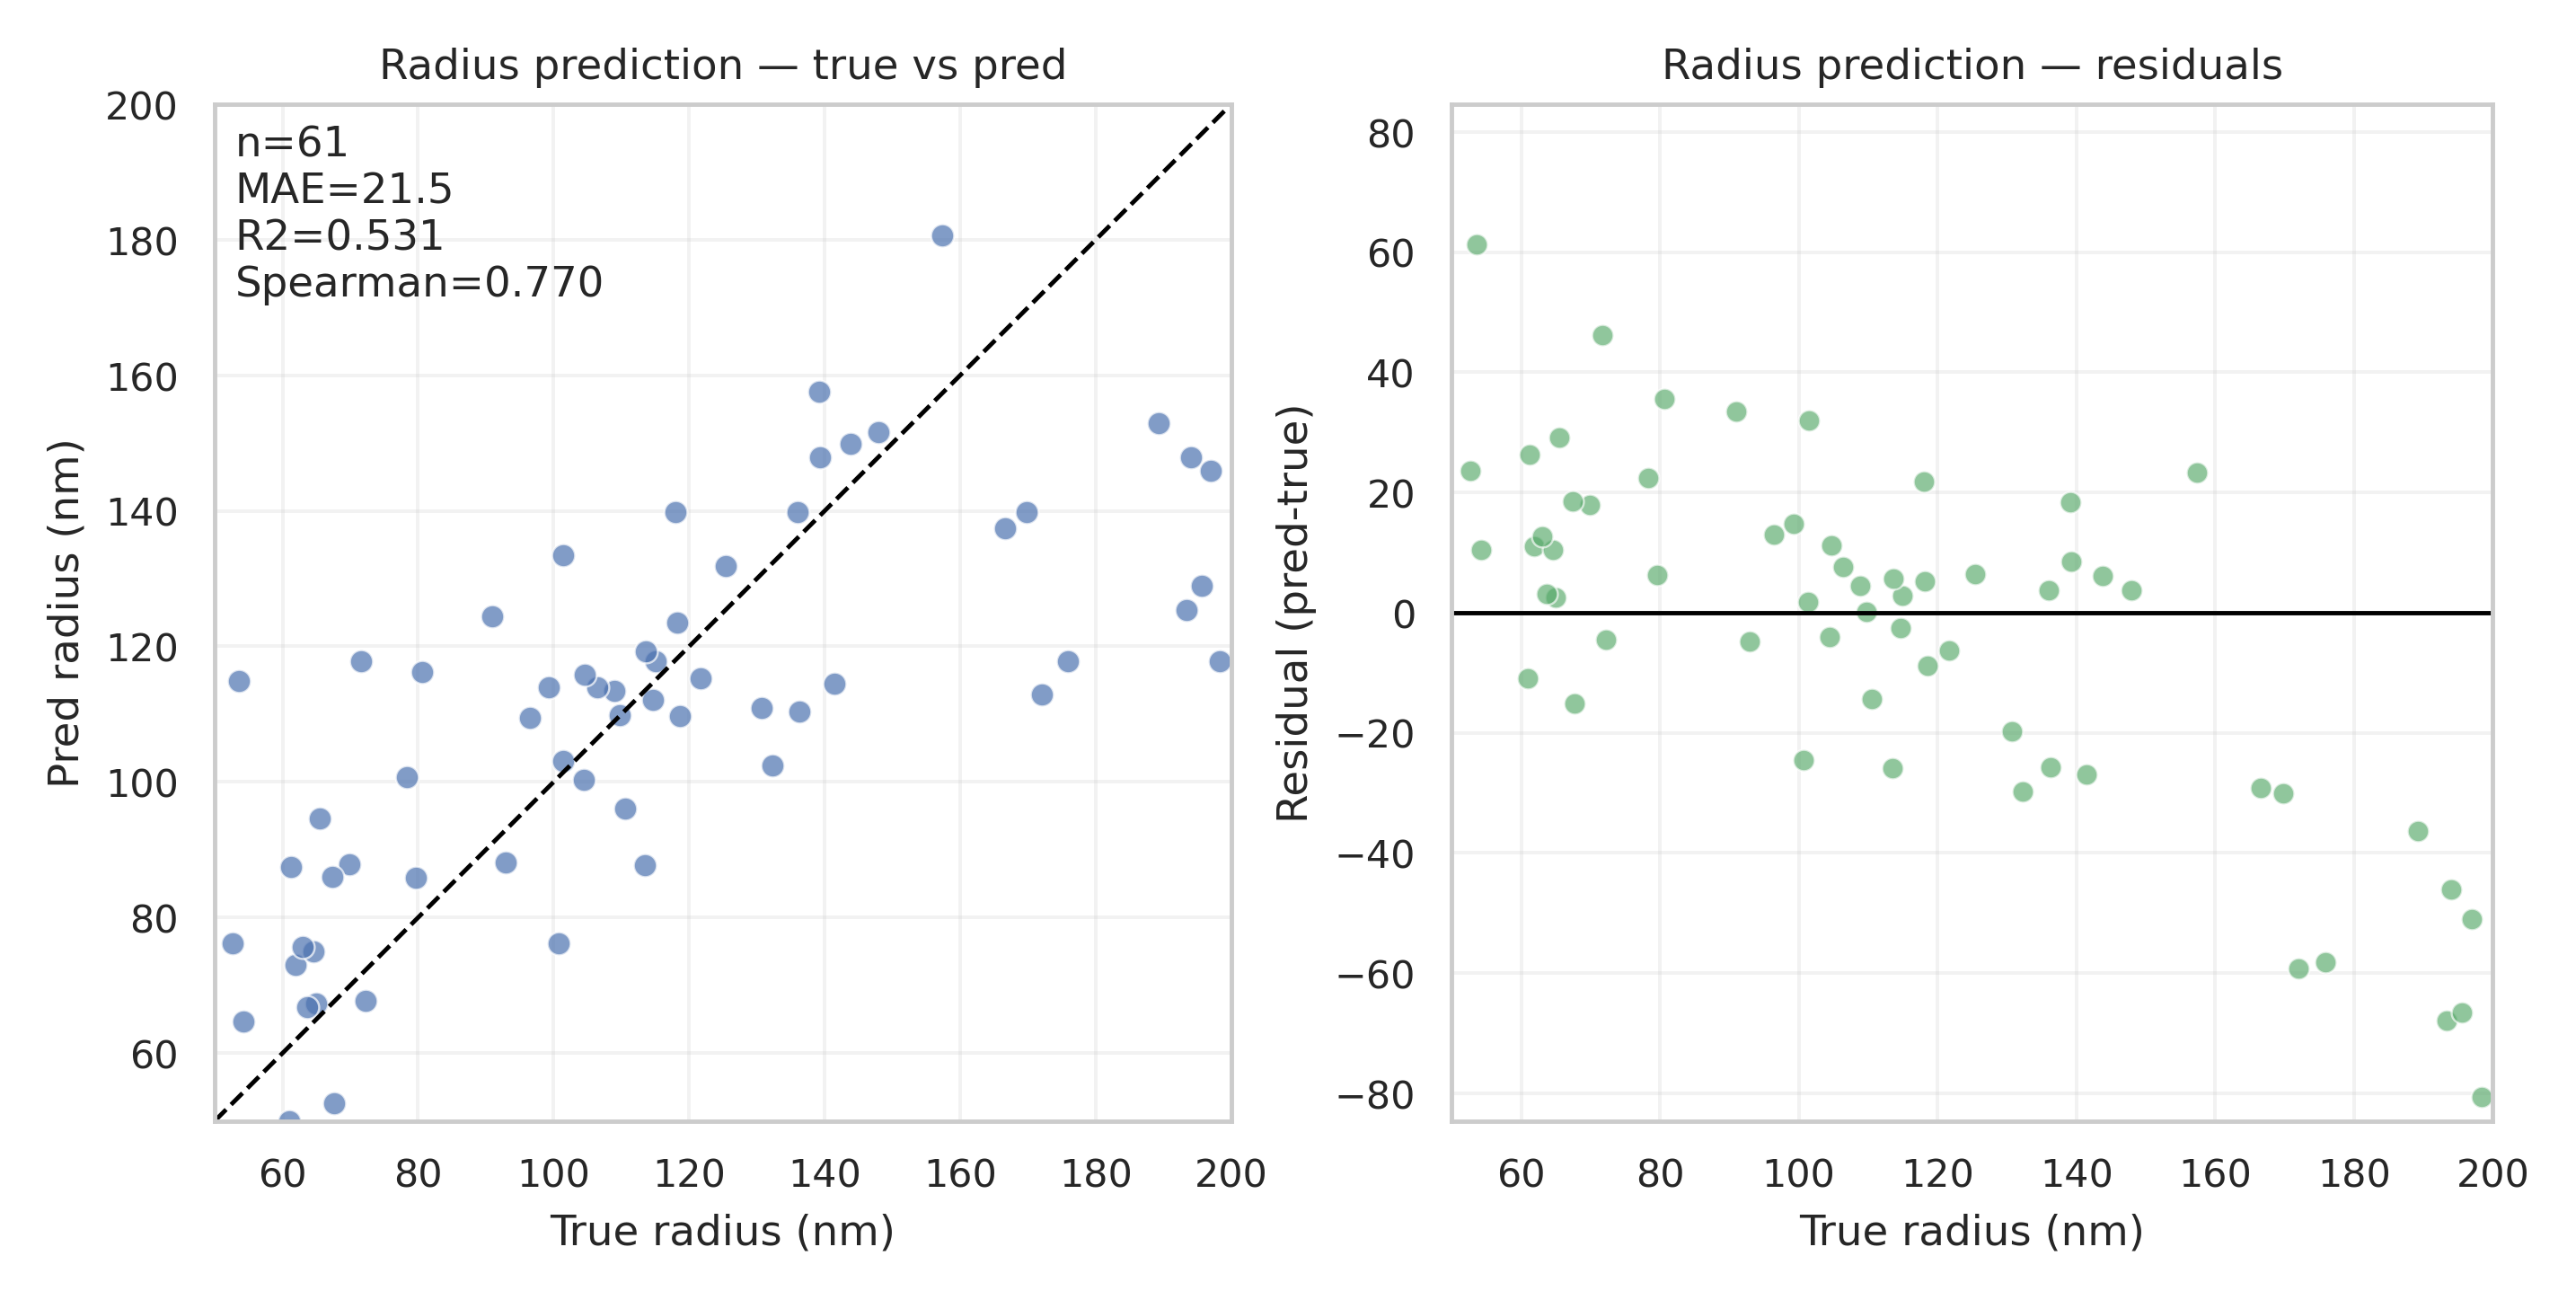

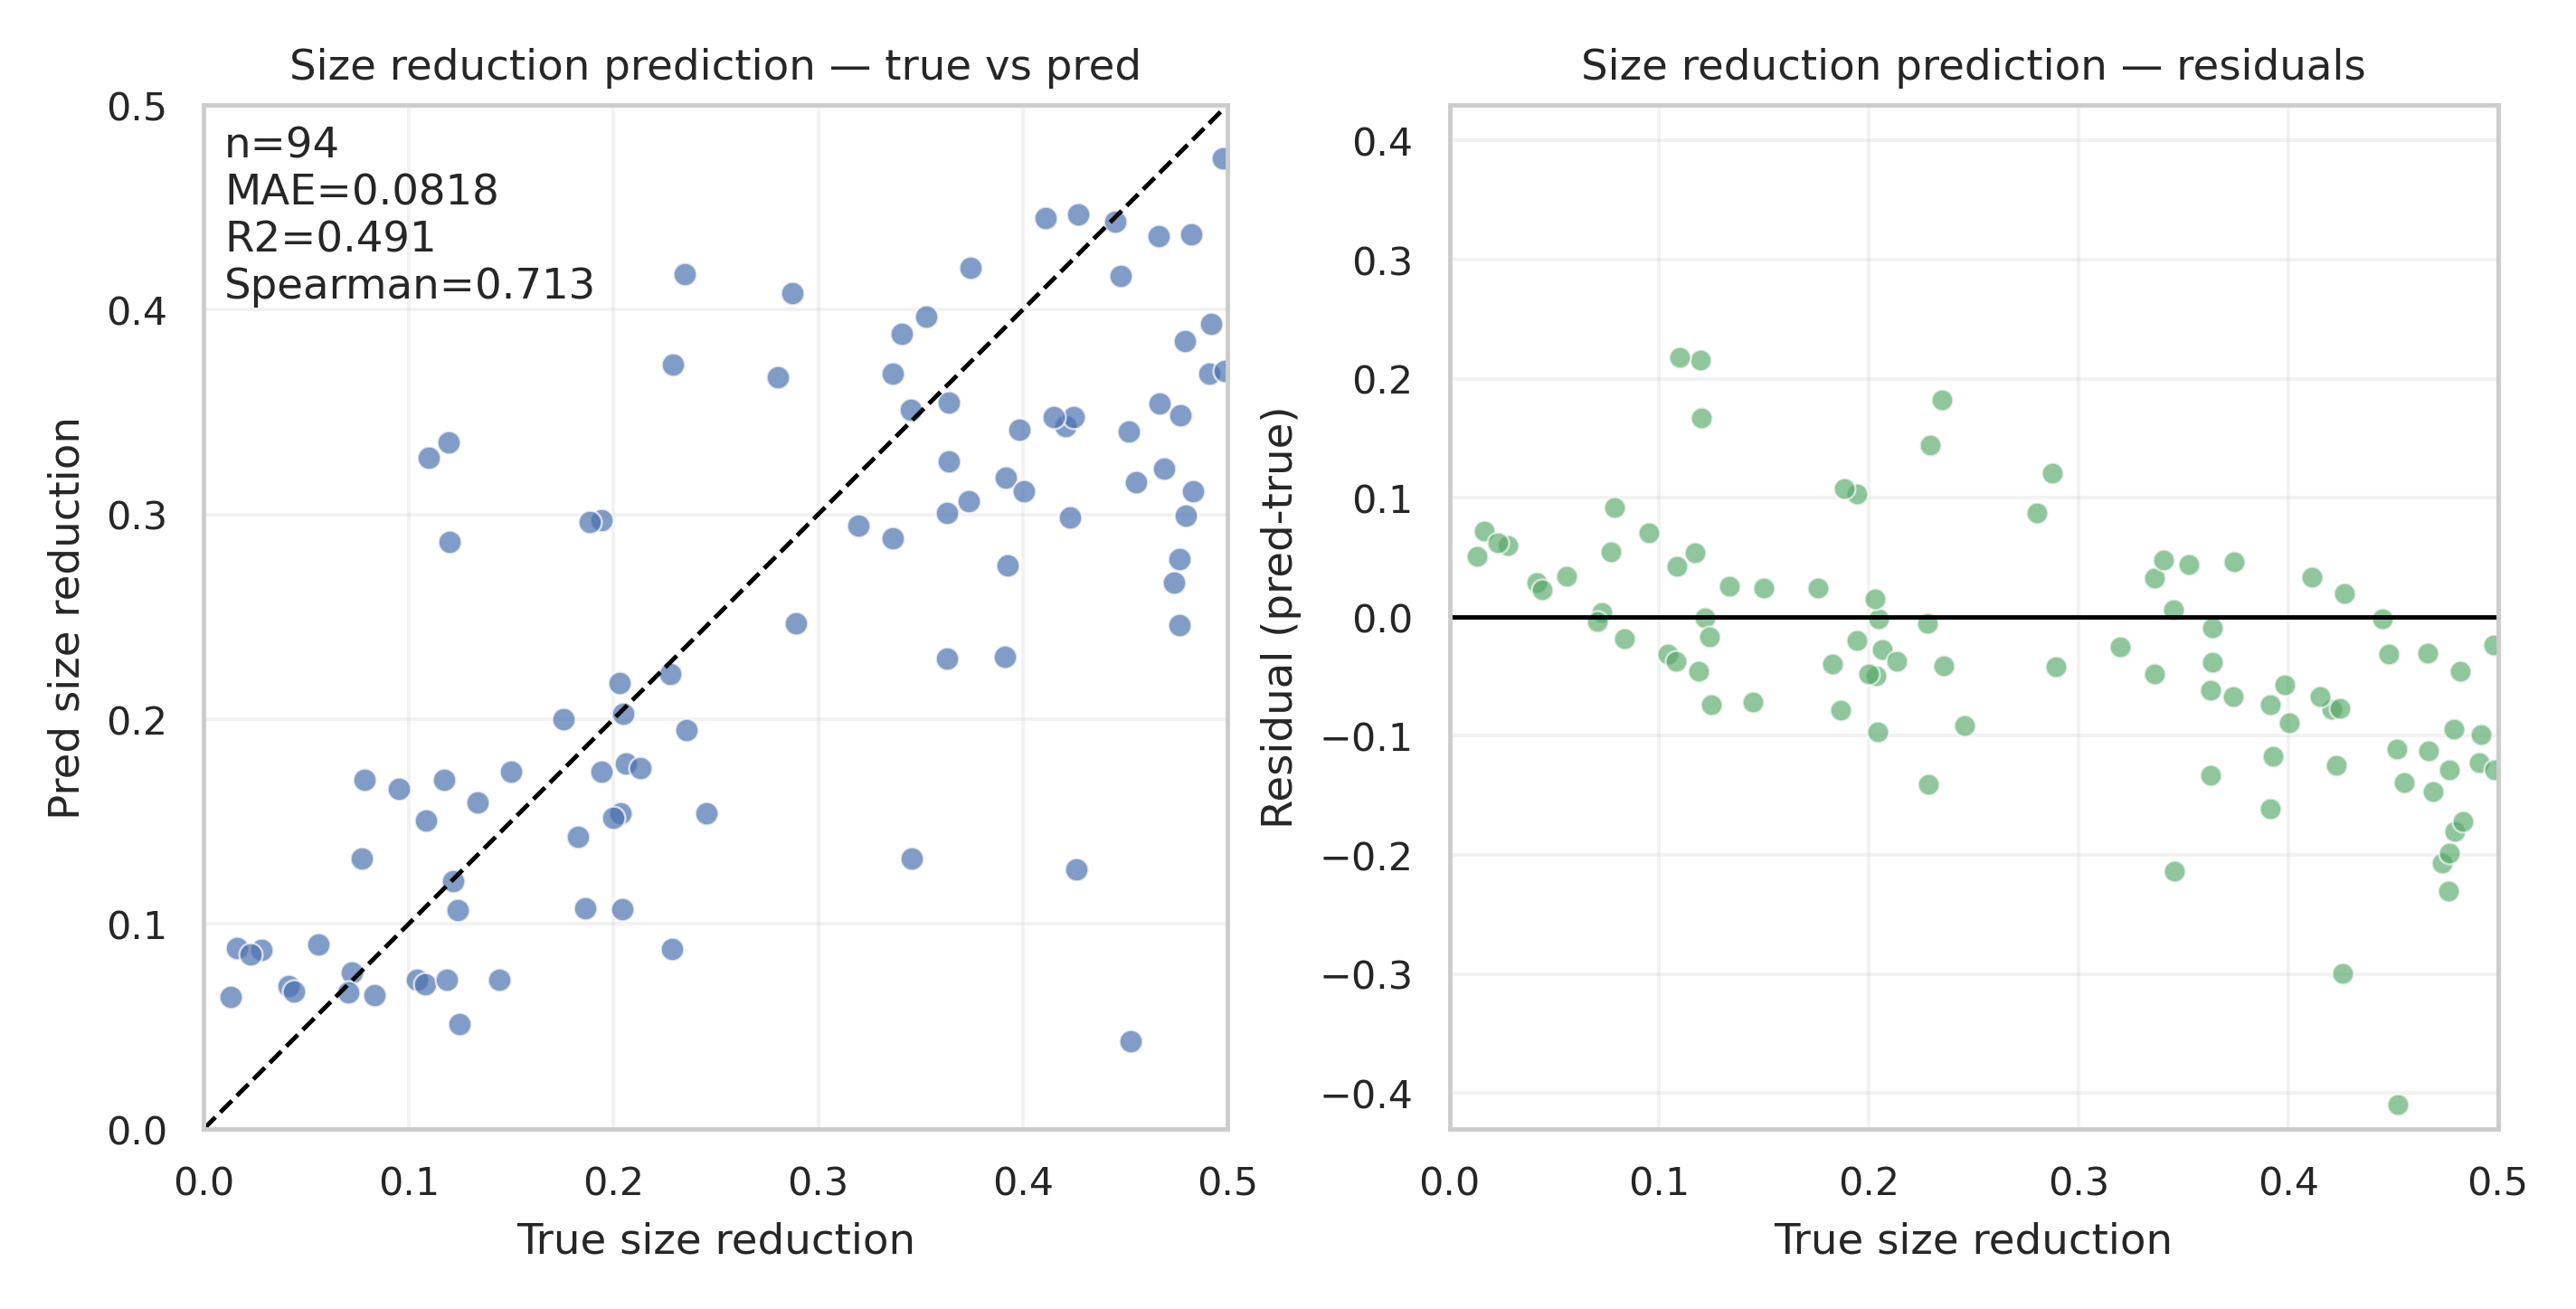

In [19]:
# 21) Regression evaluation figures (true vs pred + residuals)
from sklearn.metrics import mean_absolute_error, r2_score

# Clean up legacy figure outputs to avoid confusion (older versions saved separate figures)
try:
    _legacy_stems = [
        "model_reg_radius_nm_true_vs_pred",
        "model_reg_radius_nm_residuals",
        "model_reg_size_reduction_true_vs_pred",
        "model_reg_size_reduction_residuals",
    ]
    for _s in _legacy_stems:
        for _ext in ["png", "pdf", "svg"]:
            _p = Path(fig_dir) / f"{_s}.{_ext}"
            if _p.exists():
                _p.unlink()
except Exception:
    pass


y_radius_eval = globals().get("y_radius_eval", y_reg.get("radius_nm"))
y_sr_eval = globals().get("y_sr_eval", y_reg.get("size_reduction"))



def reg_diagnostics(y_true, y_pred, stem: str, title: str, xlab: str):
    yt = np.asarray(y_true, dtype=float)
    yp = np.asarray(y_pred, dtype=float)
    m = ~np.isnan(yt) & ~np.isnan(yp)
    if int(m.sum()) < 5:
        return

    yt = yt[m]
    yp = yp[m]
    mae = mean_absolute_error(yt, yp)
    r2 = r2_score(yt, yp)

    spearman = np.nan
    try:
        from scipy.stats import spearmanr

        spearman = float(spearmanr(yt, yp).correlation)
    except Exception:
        pass

    lim0 = float(min(yt.min(), yp.min()))
    lim1 = float(max(yt.max(), yp.max()))

    # Use consistent axes across reruns (and between the two panels)
    fixed = False
    if stem == "model_reg_radius_nm":
        qc_r = CFG.get("qc", {}).get("radius_nm", {})
        if qc_r.get("min") is not None and qc_r.get("max") is not None:
            lim0 = float(qc_r["min"])
            lim1 = float(qc_r["max"])
            fixed = True
    elif stem == "model_reg_size_reduction":
        lim0 = 0.0
        lim1 = float(max(0.5, lim1))
        lim1 = float(min(lim1, 1.0))
        fixed = True

    pad = 0.0 if fixed else (0.02 * (lim1 - lim0) if lim1 > lim0 else 1.0)
    lim0 -= pad
    lim1 += pad

    fig, axes = plt.subplots(1, 2, figsize=(9.4, 4.2), sharex=True)

    ax = axes[0]
    ax.scatter(yt, yp, s=28, alpha=0.7, color="#4C72B0", edgecolor="white", linewidth=0.5)
    ax.plot([lim0, lim1], [lim0, lim1], "--", color="black", linewidth=1)
    ax.set_title(f"{title} — true vs pred")
    ax.set_xlabel(f"True {xlab}")
    ax.set_ylabel(f"Pred {xlab}")
    ax.set_xlim(lim0, lim1)
    ax.set_ylim(lim0, lim1)
    ax.set_aspect("equal", adjustable="box")

    txt = f"n={int(yt.size)}\nMAE={mae:.3g}\nR2={r2:.3f}"
    if np.isfinite(spearman):
        txt += f"\nSpearman={spearman:.3f}"
    ax.text(0.02, 0.98, txt, transform=ax.transAxes, va="top")

    ax = axes[1]
    resid = yp - yt
    ax.scatter(yt, resid, s=24, alpha=0.65, color="#55A868", edgecolor="white", linewidth=0.5)
    ax.axhline(0, color="black", linewidth=1)
    ax.set_title(f"{title} — residuals")
    ax.set_xlabel(f"True {xlab}")
    ax.set_ylabel("Residual (pred-true)")
    ax.set_xlim(lim0, lim1)

    rmax = float(np.nanmax(np.abs(resid))) if resid.size else 1.0
    if rmax > 0:
        ax.set_ylim(-1.05 * rmax, 1.05 * rmax)

    savefig(fig, f"{stem}_diagnostics")



reg_diagnostics(y_radius_eval, pred_radius, "model_reg_radius_nm", "Radius prediction", "radius (nm)")
reg_diagnostics(y_sr_eval, pred_sr, "model_reg_size_reduction", "Size reduction prediction", "size reduction")


In [20]:
# 11) Explain (global + local) + persist explanation artifacts
expl_dir = Path(CFG["paths"]["global_explanations_dir"])
expl_dir.mkdir(parents=True, exist_ok=True)

split_all = {"train_idx": list(range(len(pairs))), "test_idx": []}

ebm_full = None
if ebm_models:
    try:
        ebm_full = cap.train_ebm(
            X,
            y_cls,
            y_reg,
            split_all,
            feature_names=feature_names,
            random_seed=int(CFG["random_seed"]),
            train_cfg=CFG.get("training", {}),
        )
        X_full = ebm_full["imputer"].transform(X)
        g, l = cap.explain_ebm(ebm_full["cls_model"], X_full)
        cap.safe_write_json(g, str(expl_dir / "ebm_cls_global.json"))
        if isinstance(l, dict) and "scores" in l and isinstance(l["scores"], list):
            l = {**l, "scores": l["scores"][:200]}
        cap.safe_write_json(l, str(expl_dir / "ebm_cls_local_sample.json"))
        pickle.dump(ebm_full, open(Path(CFG["paths"]["models_dir"]) / "ebm_full.pkl", "wb"))
    except Exception as e:
        print("EBM explain skipped:", repr(e))

gbdt_full = None
if gbdt_models:
    try:
        gbdt_full = cap.train_gbdt(
            X,
            y_cls,
            y_reg,
            split_all,
            feature_names=feature_names,
            backend=str(CFG["models"]["gbdt"].get("backend", "auto")),
            random_seed=int(CFG["random_seed"]),
            train_cfg=CFG.get("training", {}),
        )
        pickle.dump(gbdt_full, open(Path(CFG["paths"]["models_dir"]) / "gbdt_full.pkl", "wb"))
        try:
            X_full = gbdt_full["imputer"].transform(X)
            shap_summary = cap.explain_shap(gbdt_full["cls_model"], X_full[:500], feature_names)
            cap.safe_write_json(shap_summary, str(expl_dir / "gbdt_cls_shap_meanabs.json"))
        except Exception as e:
            print("SHAP skipped:", repr(e))
    except Exception as e:
        print("GBDT explain skipped:", repr(e))

sorted([p.name for p in expl_dir.glob("*.json")])


['ebm_cls_global.json',
 'ebm_cls_local_sample.json',
 'gbdt_cls_shap_meanabs.json']

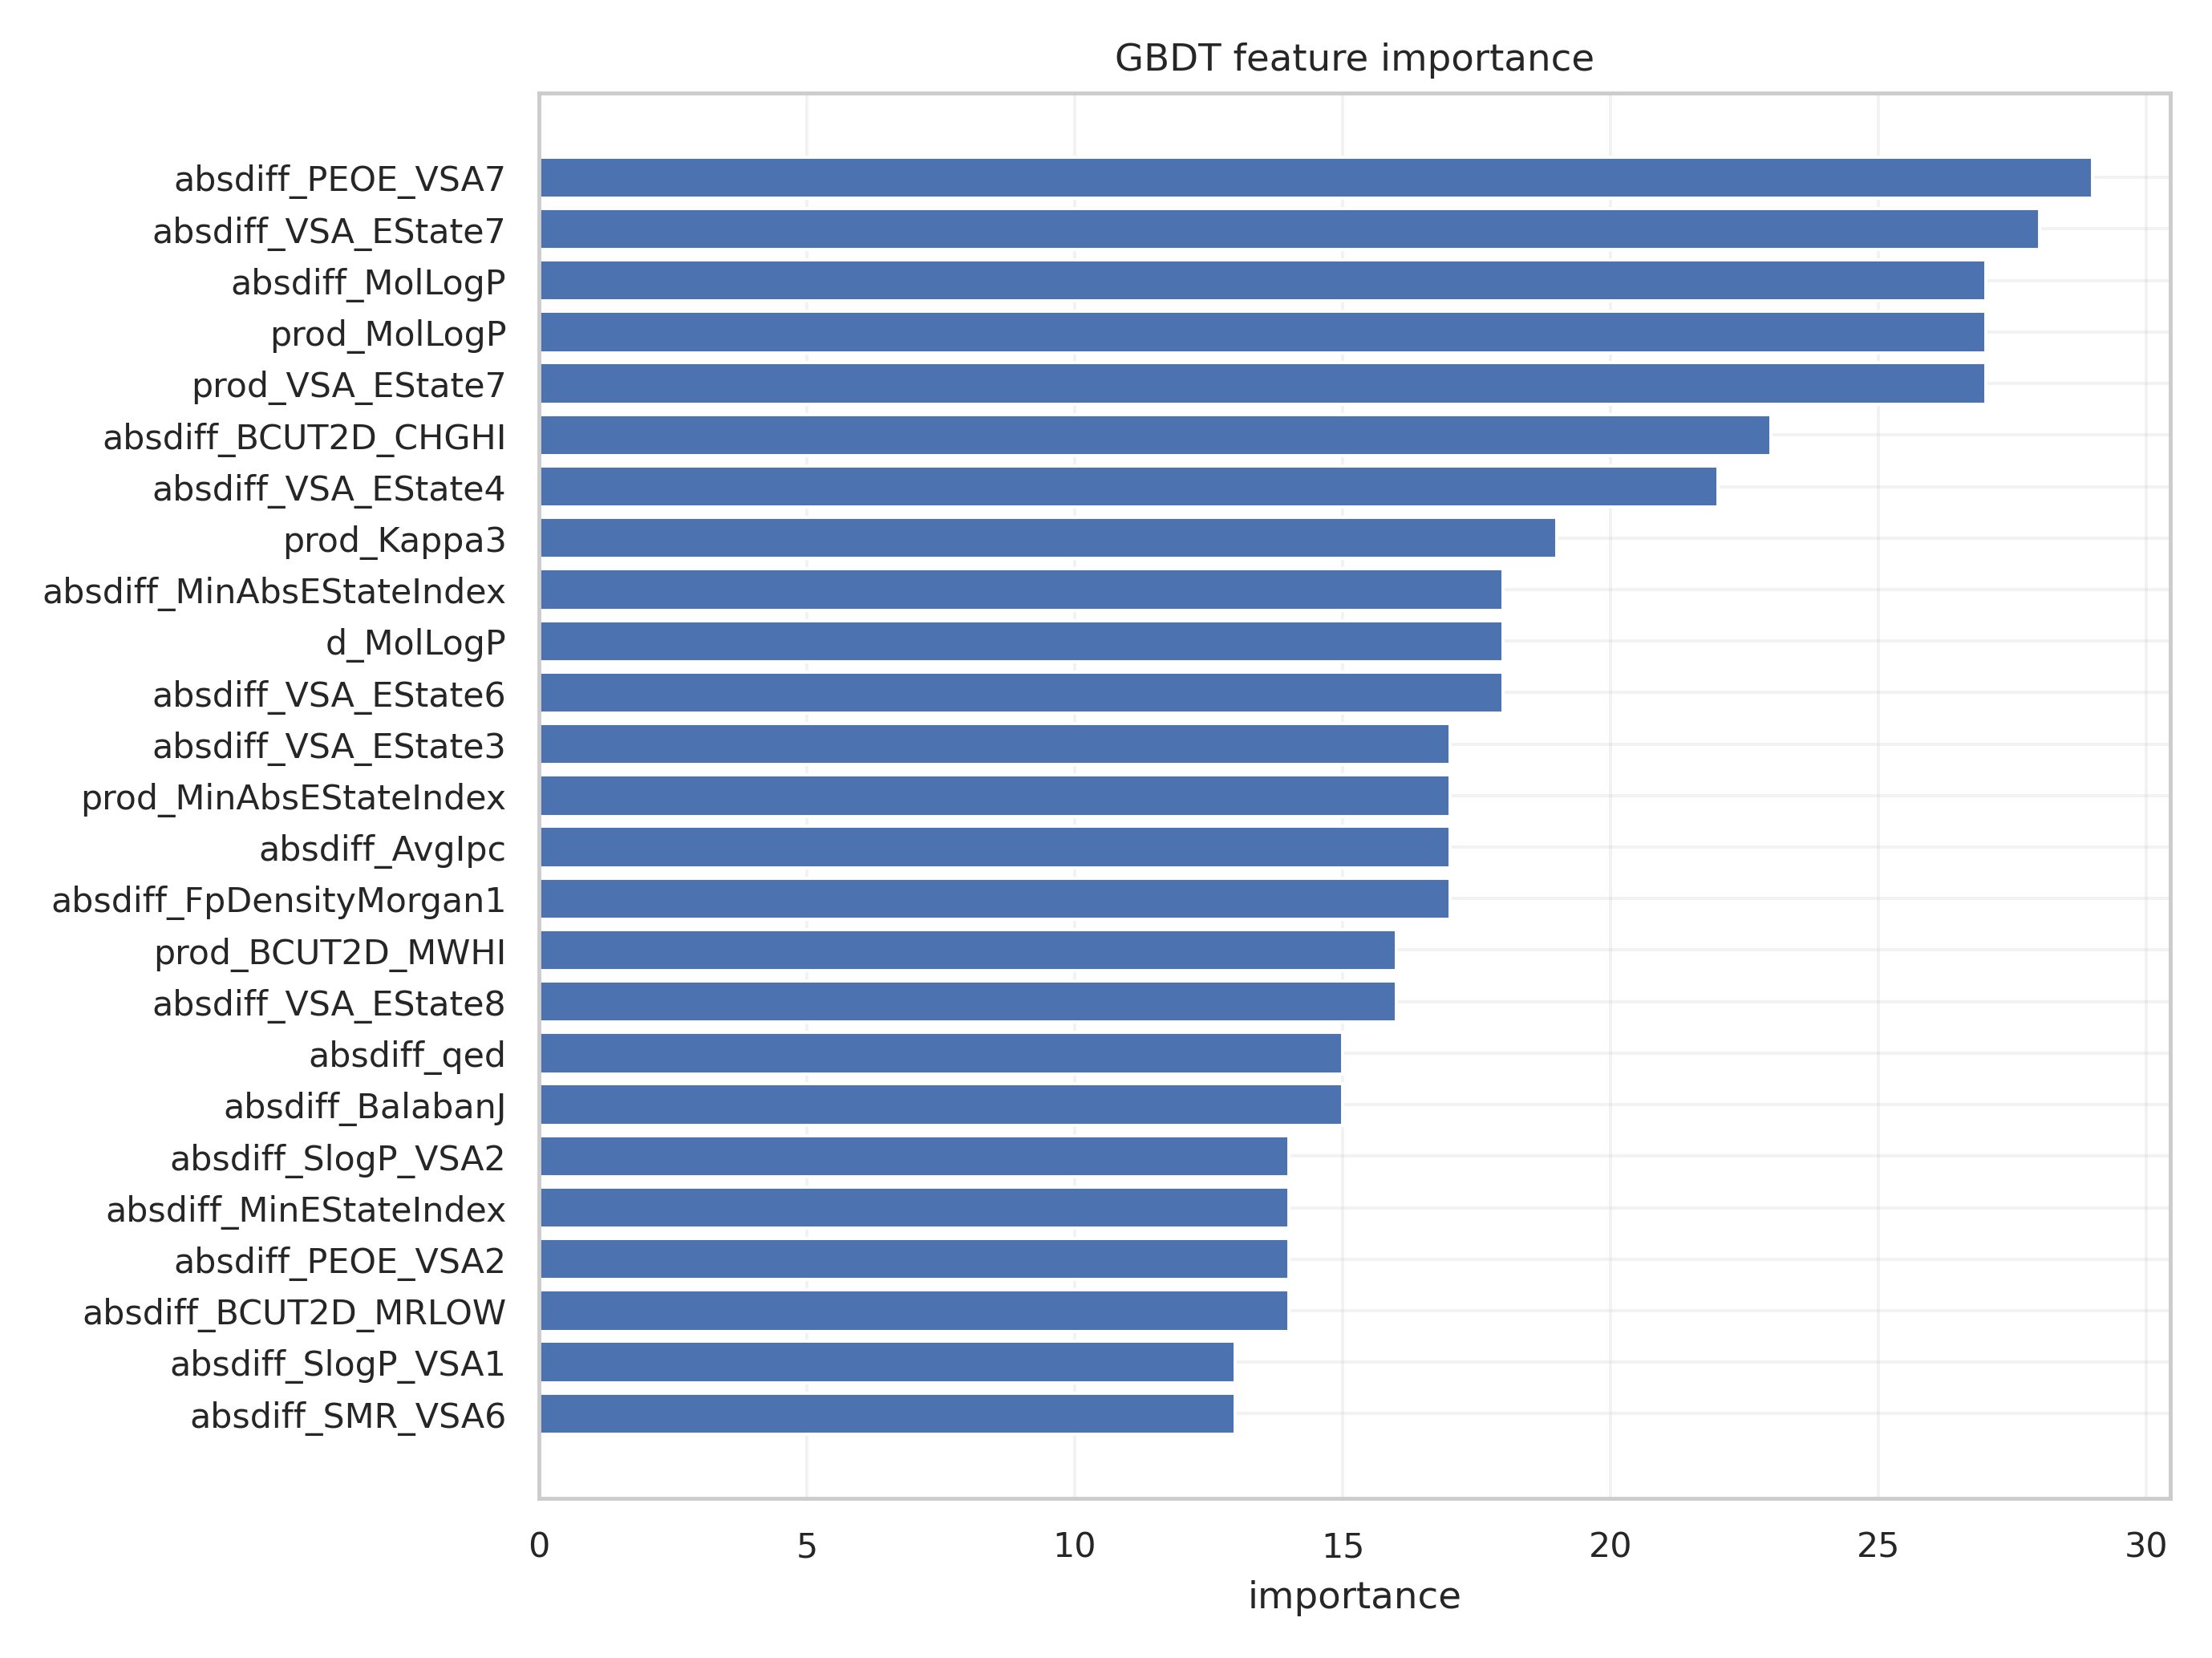

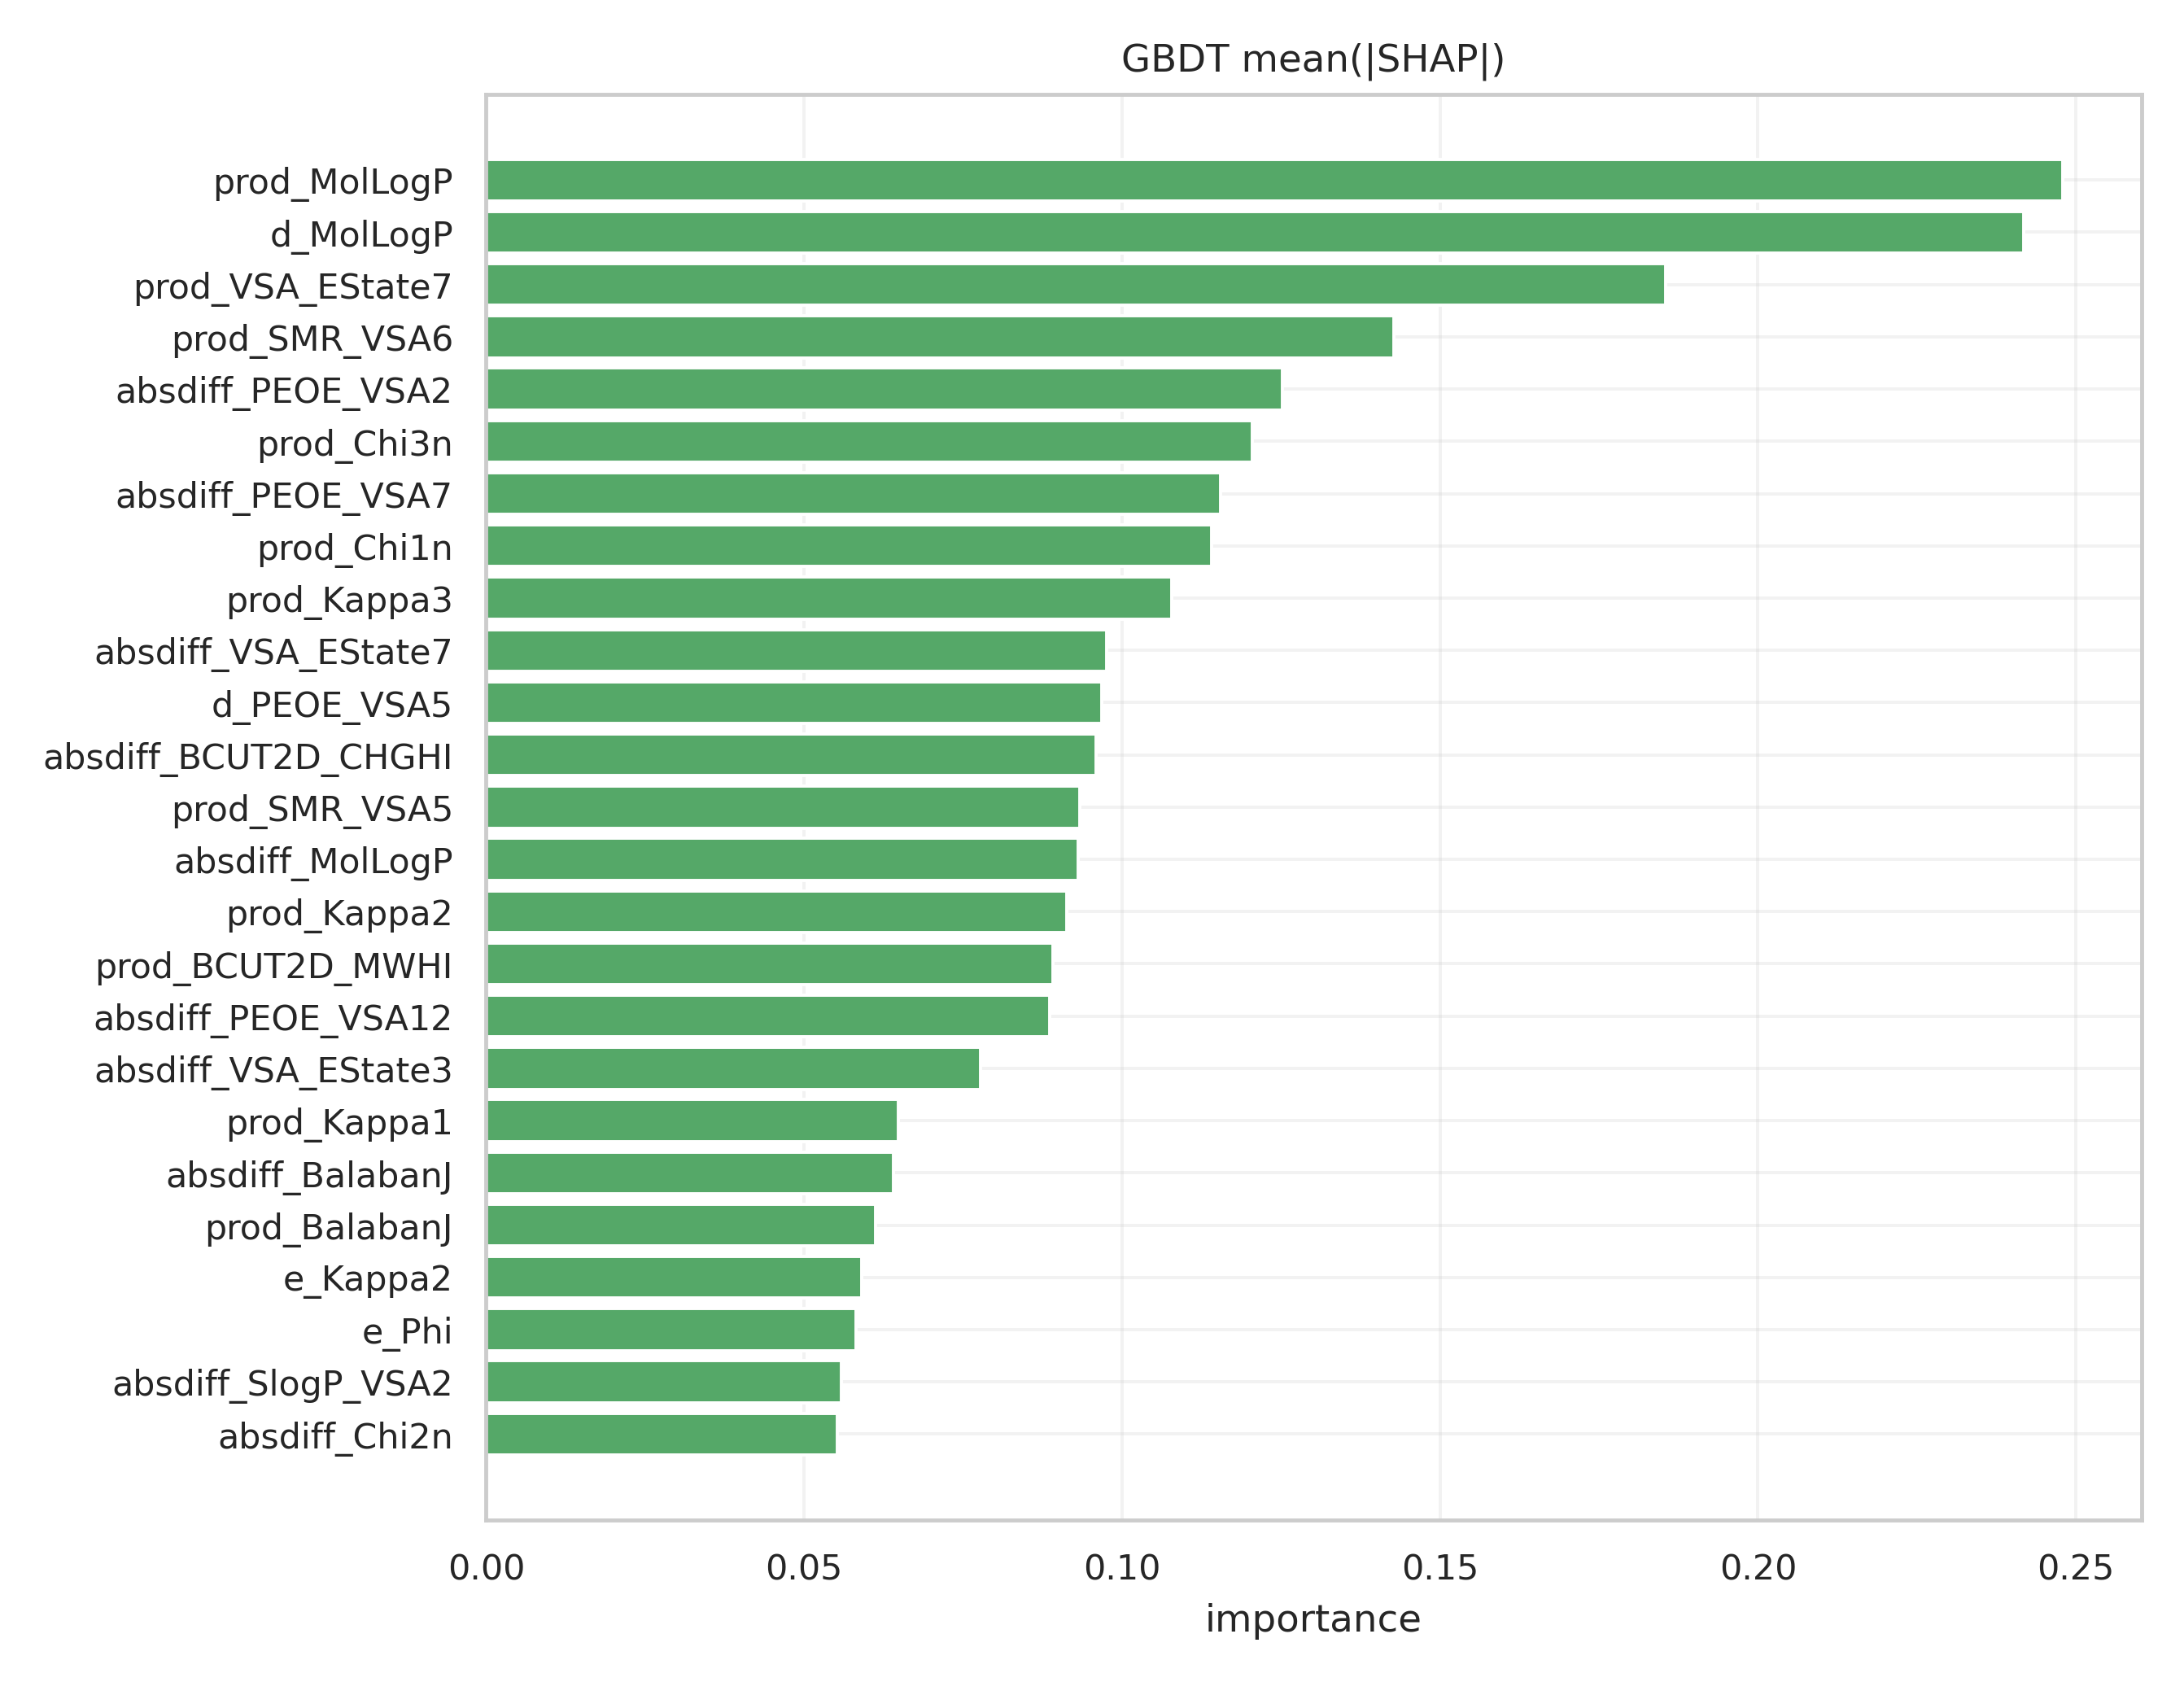

In [21]:
# 22) Feature importance / explanations (EBM + GBDT)

def _topk_bar(names, scores, k=25, title="", color="#4C72B0", stem="feat_importance"):
    names = list(names)
    scores = np.asarray(scores, dtype=float)
    order = np.argsort(-scores)[:k]
    xs = scores[order][::-1]
    ys = [names[i] for i in order][::-1]
    fig, ax = plt.subplots(figsize=(7.5, 6.5))
    ax.barh(ys, xs, color=color)
    ax.set_title(title)
    ax.set_xlabel("importance")
    savefig(fig, stem)


if ebm_full is not None:
    try:
        m = ebm_full["cls_model"]
        term_names = list(getattr(m, "term_names_", []))
        importances = np.asarray(m.term_importances(), dtype=float)
        if term_names and importances.size:
            _topk_bar(term_names, importances, k=25, title="EBM global term importance", stem="explain_ebm_term_importance")
    except Exception as e:
        print("EBM importance plot skipped:", repr(e))

if gbdt_full is not None:
    try:
        m = gbdt_full["cls_model"]
        if hasattr(m, "feature_importances_"):
            _topk_bar(feature_names, m.feature_importances_, k=25, title="GBDT feature importance", stem="explain_gbdt_feature_importance")
    except Exception as e:
        print("GBDT importance plot skipped:", repr(e))

# SHAP summary (mean|SHAP|) if available
shap_json = expl_dir / "gbdt_cls_shap_meanabs.json"
if shap_json.exists():
    try:
        d = json.loads(shap_json.read_text(encoding="utf-8"))
        _topk_bar(d["feature_names"], d["mean_abs_shap"], k=25, title="GBDT mean(|SHAP|)", stem="explain_gbdt_shap_meanabs", color="#55A868")
    except Exception as e:
        print("SHAP plot skipped:", repr(e))


In [22]:
# 12) External screening: query drugs x excipient pool -> ranked candidates
if not (ebm_models or gbdt_models):
    raise RuntimeError("No trained models available. Install interpret (EBM) and/or lightgbm/xgboost.")

query_path = DATA / "query_drugs.tsv"
query = None
if query_path.exists():
    query_raw = cap.read_tsv_auto(str(query_path))
    if query_raw.shape[0] > 0:
        query = pd.DataFrame({"name": query_raw.iloc[:, 0], "smiles": query_raw.iloc[:, 1]})
if query is None:
    query = drugs[["name", "smiles"]].copy()

query["mol_id"] = [f"Q{i:04d}" for i in range(query.shape[0])]
query = cap.standardize_smiles_table(query, dataset="query_drugs", results_dir=results_dir)
query = query.dropna(subset=["smiles_std"]).copy()

pool = gras.dropna(subset=["smiles"]).copy()
pool["mol_id"] = [f"X{i:04d}" for i in range(pool.shape[0])]
pool = cap.standardize_smiles_table(pool, dataset="excipient_pool", results_dir=results_dir)
pool = pool.dropna(subset=["smiles_std"]).copy()

cand = cap.generate_candidates(
    query[["name", "smiles_std"]],
    pool[["name", "smiles_std"]],
    mode=str(CFG["screening"]["candidate_mode"]),
    K=int(CFG["screening"]["K"]),
    fp_radius=int(CFG["features"]["morgan_radius"]),
    fp_nbits=int(CFG["features"]["morgan_nbits"]),
)

# Attach mol_id for descriptor lookup
q_key = query[["mol_id", "name", "smiles_std"]].rename(
    columns={"mol_id": "drug_mol_id", "name": "drug_name", "smiles_std": "drug_smiles_std"}
)
p_key = pool[["mol_id", "name", "smiles_std"]].rename(
    columns={"mol_id": "excipient_mol_id", "name": "excipient_name", "smiles_std": "excipient_smiles_std"}
)
cand = cand.merge(q_key, on=["drug_name", "drug_smiles_std"], how="left")
cand = cand.merge(p_key, on=["excipient_name", "excipient_smiles_std"], how="left")
cand = cand.dropna(subset=["drug_mol_id", "excipient_mol_id"]).copy()

# Compute descriptors for query/pool and align to training feature set

desc_query = cap.compute_mordred(
    query[["mol_id", "smiles_std"]],
    use_mordred_if_available=use_mordred,
)
desc_pool = cap.compute_mordred(
    pool[["mol_id", "smiles_std"]],
    use_mordred_if_available=use_mordred,
)

# Optional: Morgan fingerprints for query/pool (used by fp-based meta-models)
fp_query = None
fp_pool = None
try:
    nbits = int(CFG.get("features", {}).get("morgan_nbits", 2048))
    radius = int(CFG.get("features", {}).get("morgan_radius", 2))

    def _fp_table_from_smiles(df):
        rows = []
        idx = []
        for mol_id, smi in df[["mol_id", "smiles_std"]].dropna().itertuples(index=False):
            try:
                fp = cap.make_morgan_fp(str(smi), radius=radius, nbits=nbits)
            except Exception:
                fp = np.full((nbits,), np.nan, dtype=float)
            rows.append(fp)
            idx.append(str(mol_id))
        if not rows:
            return None
        return pd.DataFrame(np.asarray(rows), index=idx)

    fp_query = _fp_table_from_smiles(query)
    fp_pool = _fp_table_from_smiles(pool)
except Exception:
    fp_query = None
    fp_pool = None

# Ensure annotation features (if enabled during training) are present for external compounds too.
if ("add_ann_features" in globals()) and ("ANN_FEATURES" in globals()):
    try:
        _q_sm = query.set_index("mol_id")["smiles_std"]
        _p_sm = pool.set_index("mol_id")["smiles_std"]
        desc_query = add_ann_features(desc_query, _q_sm)
        desc_pool = add_ann_features(desc_pool, _p_sm)
    except Exception:
        pass

desc_query = desc_query.reindex(columns=base_features)
desc_pool = desc_pool.reindex(columns=base_features)

ensemble_fold_models = list(ebm_models) + list(gbdt_models)

# Apply per-model calibration consistently for external screening.
calib_by_kind = {}
if ("calib_ebm" in globals()) and (calib_ebm is not None):
    calib_by_kind["ebm"] = calib_ebm
if ("calib_gbdt" in globals()) and (calib_gbdt is not None):
    calib_by_kind["gbdt"] = calib_gbdt

# Optional: use the same ensemble weights learned on OOF predictions.
ensemble_fold_weights = None
if ebm_models and gbdt_models:
    w_ebm = float(ensemble_weight_ebm) if ("ensemble_weight_ebm" in globals()) else 0.5
    w_gbdt = float(ensemble_weight_gbdt) if ("ensemble_weight_gbdt" in globals()) else 0.5
    ensemble_fold_weights = [w_ebm / len(ebm_models)] * len(ebm_models) + [w_gbdt / len(gbdt_models)] * len(gbdt_models)
reg_conf = {"radius_nm": conf_radius, "size_reduction": conf_sr}

ranked = cap.screen_candidates(
    cand,
    ensemble_fold_models,
    desc_query,
    desc_pool,
    base_features,
    calib_model=None,
    calib_by_kind=calib_by_kind if calib_by_kind else None,
    model_weights=ensemble_fold_weights,
    reg_conformal=reg_conf,
    prob_quantiles=tuple(CFG["uncertainty"]["prob_quantiles"]),
)

if calib_final is not None:
    ranked["p_np_final"] = cap.apply_calibrator(calib_final, ranked["p_np_final"].to_numpy())

# Ensure mol-id columns are present for optional refinement steps.
if "drug_mol_id" not in ranked.columns or "excipient_mol_id" not in ranked.columns:
    try:
        drug_map = dict(zip(drugs["name"].astype(str), drugs["mol_id"].astype(str)))
        exc_map = dict(zip(excs["name"].astype(str), excs["mol_id"].astype(str)))
        ranked["drug_mol_id"] = ranked["drug_name"].astype(str).map(drug_map)
        ranked["excipient_mol_id"] = ranked["excipient_name"].astype(str).map(exc_map)
    except Exception:
        pass

# Optional: Multi-task NN refinement for regression heads (keeps p_np_final from calibrated ensemble)
if ("multitask_nn_bundle" in globals()) and (multitask_nn_bundle is not None):
    try:
        import formulens_multitask as fmt


        Xd_ext = desc_query.loc[ranked["drug_mol_id"].astype(str).tolist(), base_features].to_numpy()
        Xe_ext = desc_pool.loc[ranked["excipient_mol_id"].astype(str).tolist(), base_features].to_numpy()
        X_pair = cap.make_pair_features(Xd_ext, Xe_ext)

        X_nn_parts = [X_pair]

        if ("fp" in str(getattr(multitask_nn_bundle, "feature_set", ""))) and ("fp_query" in globals()) and ("fp_pool" in globals()) and (fp_query is not None) and (fp_pool is not None):
            fp_d = fp_query.loc[ranked["drug_mol_id"].astype(str).tolist()].to_numpy(dtype=float)
            fp_e = fp_pool.loc[ranked["excipient_mol_id"].astype(str).tolist()].to_numpy(dtype=float)
            fp_d = np.nan_to_num(fp_d)
            fp_e = np.nan_to_num(fp_e)
            fp_pair_ext = np.column_stack([fp_d, fp_e])
            inter = np.sum((fp_d > 0) & (fp_e > 0), axis=1)
            union = np.sum((fp_d > 0) | (fp_e > 0), axis=1)
            tanimoto = inter / np.maximum(union, 1)
            fp_stats_ext = np.column_stack([inter, union, tanimoto])
            X_nn_parts.extend([fp_pair_ext, fp_stats_ext])

        if "sim" in str(getattr(multitask_nn_bundle, "feature_set", "")):
            sim_path = DATA / "simulation_results.tsv"
            if sim_path.exists():
                sim_raw = cap.read_tsv_auto(str(sim_path))
                sim_df = sim_raw.rename(columns={"drug": "drug_name", "excipient": "excipient_name"}).copy()
                sim_cols = [c for c in sim_df.columns if c not in {"drug_name", "excipient_name"}]
                for c in sim_cols:
                    sim_df[c] = pd.to_numeric(sim_df[c], errors="coerce")

                X_sim_ext = ranked[["drug_name", "excipient_name"]].merge(
                    sim_df[["drug_name", "excipient_name"] + sim_cols],
                    on=["drug_name", "excipient_name"],
                    how="left",
                )[sim_cols].to_numpy(dtype=float)
                X_nn_parts.append(X_sim_ext)

        X_nn_ext = np.column_stack(X_nn_parts)
        _, rad_nn, sr_nn = fmt.predict_multitask_nn(multitask_nn_bundle, X_nn_ext)

        if "pred_radius_nm" in ranked.columns:
            ranked["pred_radius_nm"] = np.nanmean(
                np.vstack([ranked["pred_radius_nm"].to_numpy(dtype=float), rad_nn]), axis=0
            )
        if "pred_size_reduction" in ranked.columns:
            ranked["pred_size_reduction"] = np.nanmean(
                np.vstack([ranked["pred_size_reduction"].to_numpy(dtype=float), sr_nn]), axis=0
            )

        # refresh conformal-style intervals (if available)
        if ("conf_radius" in globals()) and ("pred_radius_nm" in ranked.columns):
            q = float(conf_radius.get("q", float("nan")))
            ranked["radius_nm_ci_low"] = ranked["pred_radius_nm"] - q
            ranked["radius_nm_ci_high"] = ranked["pred_radius_nm"] + q
        if ("conf_sr" in globals()) and ("pred_size_reduction" in ranked.columns):
            q = float(conf_sr.get("q", float("nan")))
            ranked["size_reduction_ci_low"] = ranked["pred_size_reduction"] - q
            ranked["size_reduction_ci_high"] = ranked["pred_size_reduction"] + q

    except Exception as e:
        print("[multitask_nn] external refinement skipped:", repr(e))

# Optional: target-encoding radius baseline (drug/exc identity), blended into pred_radius_nm
if ("te_radius_stats" in globals()) and ("te_radius_model" in globals()) and (te_radius_stats is not None):
    try:
        te_pred = _predict_te_model(ranked[["drug_name", "excipient_name"]], te_radius_stats, te_radius_model)
        if "pred_radius_nm" in ranked.columns:
            ranked["pred_radius_nm"] = np.nanmean(
                np.vstack([ranked["pred_radius_nm"].to_numpy(dtype=float), te_pred]), axis=0
            )
    except Exception as e:
        print("[te_radius] external blend skipped:", repr(e))
    ranked["p_np_interval_low"] = cap.apply_calibrator(calib_final, ranked["p_np_interval_low"].to_numpy())
    ranked["p_np_interval_high"] = cap.apply_calibrator(calib_final, ranked["p_np_interval_high"].to_numpy())

# Rename regression interval columns to match requested schema
if "radius_nm_ci_low" in ranked.columns:
    ranked = ranked.rename(columns={"radius_nm_ci_low": "radius_ci_low", "radius_nm_ci_high": "radius_ci_high"})
if "size_reduction_ci_low" in ranked.columns:
    ranked = ranked.rename(columns={"size_reduction_ci_low": "sr_ci_low", "size_reduction_ci_high": "sr_ci_high"})



# Optional: apply size-reduction meta-model (feature_set-dependent)
if ("size_reduction_meta_model" in globals()) and (size_reduction_meta_model is not None):
    needed = {
        "drug_name",
        "excipient_name",
        "drug_mol_id",
        "excipient_mol_id",
        "pred_radius_nm",
        "pred_size_reduction",
        "p_np_final",
    }
    if needed.issubset(ranked.columns) and ("desc_query" in globals()) and ("desc_pool" in globals()):
        meta_fs = ""
        if ("size_reduction_meta_info" in globals()) and isinstance(size_reduction_meta_info, dict):
            meta_fs = str(size_reduction_meta_info.get("feature_set") or "")

        def _inv_logit(z):
            return 1.0 / (1.0 + np.exp(-np.asarray(z, dtype=float)))

        inv_fn = globals().get("_expit", _inv_logit)
        sr_min_val = float(globals().get("sr_min", 0.0))
        sr_max_val = float(globals().get("sr_max", 1.0))
        q = float(conf_sr.get("q", float("nan")))

        if meta_fs in {"fp+preds", "pair+fp+preds"}:
            if ("fp_query" not in globals()) or ("fp_pool" not in globals()) or (fp_query is None) or (fp_pool is None):
                print("Size-reduction meta-model uses fingerprint features, but fp_query/fp_pool are missing; skip refinement.")
            else:
                fp_d = fp_query.loc[ranked["drug_mol_id"].astype(str).tolist()].to_numpy(dtype=float)
                fp_e = fp_pool.loc[ranked["excipient_mol_id"].astype(str).tolist()].to_numpy(dtype=float)
                fp_d = np.nan_to_num(fp_d)
                fp_e = np.nan_to_num(fp_e)
                fp_pair = np.column_stack([fp_d, fp_e])
                inter = np.sum((fp_d > 0) & (fp_e > 0), axis=1)
                union = np.sum((fp_d > 0) | (fp_e > 0), axis=1)
                tanimoto = inter / np.maximum(union, 1)
                fp_stats = np.column_stack([inter, union, tanimoto])

                sr0_ext = ranked["pred_size_reduction"].to_numpy(dtype=float).reshape(-1, 1)
                p_ext = ranked["p_np_final"].to_numpy(dtype=float).reshape(-1, 1)
                r0_ext = ranked["pred_radius_nm"].to_numpy(dtype=float).reshape(-1, 1)

                if meta_fs == "pair+fp+preds":
                    Xd_ext = desc_query.loc[ranked["drug_mol_id"].astype(str).tolist(), base_features].to_numpy()
                    Xe_ext = desc_pool.loc[ranked["excipient_mol_id"].astype(str).tolist(), base_features].to_numpy()
                    X_pair = cap.make_pair_features(Xd_ext, Xe_ext)
                    X_meta = np.column_stack([X_pair, fp_pair, fp_stats, sr0_ext, p_ext, r0_ext])
                else:
                    X_meta = np.column_stack([fp_pair, fp_stats, sr0_ext, p_ext, r0_ext])

                ranked["pred_size_reduction"] = np.clip(inv_fn(size_reduction_meta_model.predict(X_meta)), sr_min_val, sr_max_val)
                ranked["sr_ci_low"] = ranked["pred_size_reduction"] - q
                ranked["sr_ci_high"] = ranked["pred_size_reduction"] + q
        elif meta_fs == "pair+preds":
            Xd_ext = desc_query.loc[ranked["drug_mol_id"].astype(str).tolist(), base_features].to_numpy()
            Xe_ext = desc_pool.loc[ranked["excipient_mol_id"].astype(str).tolist(), base_features].to_numpy()
            X_pair = cap.make_pair_features(Xd_ext, Xe_ext)

            sr0_ext = ranked["pred_size_reduction"].to_numpy(dtype=float).reshape(-1, 1)
            p_ext = ranked["p_np_final"].to_numpy(dtype=float).reshape(-1, 1)
            r0_ext = ranked["pred_radius_nm"].to_numpy(dtype=float).reshape(-1, 1)

            X_meta = np.column_stack([X_pair, sr0_ext, p_ext, r0_ext])
            ranked["pred_size_reduction"] = np.clip(inv_fn(size_reduction_meta_model.predict(X_meta)), sr_min_val, sr_max_val)
            ranked["sr_ci_low"] = ranked["pred_size_reduction"] - q
            ranked["sr_ci_high"] = ranked["pred_size_reduction"] + q
        elif meta_fs == "desc+preds":
            Xd_ext = desc_query.loc[ranked["drug_mol_id"].astype(str).tolist(), base_features].to_numpy()
            Xe_ext = desc_pool.loc[ranked["excipient_mol_id"].astype(str).tolist(), base_features].to_numpy()

            sr0_ext = ranked["pred_size_reduction"].to_numpy(dtype=float).reshape(-1, 1)
            p_ext = ranked["p_np_final"].to_numpy(dtype=float).reshape(-1, 1)
            r0_ext = ranked["pred_radius_nm"].to_numpy(dtype=float).reshape(-1, 1)

            X_meta = np.column_stack([Xd_ext, Xe_ext, sr0_ext, p_ext, r0_ext])
            ranked["pred_size_reduction"] = np.clip(inv_fn(size_reduction_meta_model.predict(X_meta)), sr_min_val, sr_max_val)
            ranked["sr_ci_low"] = ranked["pred_size_reduction"] - q
            ranked["sr_ci_high"] = ranked["pred_size_reduction"] + q
        else:
            sim_path = DATA / "simulation_results.tsv"
            if sim_path.exists() and ("sim_cols" in globals()) and sim_cols:
                sim_raw = cap.read_tsv_auto(str(sim_path))
                sim_df = sim_raw.rename(columns={"drug": "drug_name", "excipient": "excipient_name"}).copy()
                for c in sim_cols:
                    if c in sim_df.columns:
                        sim_df[c] = pd.to_numeric(sim_df[c], errors="coerce")
                    else:
                        sim_df[c] = np.nan

                sim_join = ranked[["drug_name", "excipient_name"]].merge(
                    sim_df[["drug_name", "excipient_name"] + list(sim_cols)],
                    on=["drug_name", "excipient_name"],
                    how="left",
                )
                Xsim_ext = sim_join[list(sim_cols)].to_numpy(dtype=float)
                sim_ok = np.isfinite(Xsim_ext).all(axis=1)

                if int(sim_ok.sum()) > 0:
                    Xd_ext = desc_query.loc[ranked.loc[sim_ok, "drug_mol_id"].astype(str).tolist(), base_features].to_numpy()
                    Xe_ext = desc_pool.loc[ranked.loc[sim_ok, "excipient_mol_id"].astype(str).tolist(), base_features].to_numpy()

                    sr0_ext = ranked.loc[sim_ok, "pred_size_reduction"].to_numpy(dtype=float).reshape(-1, 1)
                    p_ext = ranked.loc[sim_ok, "p_np_final"].to_numpy(dtype=float).reshape(-1, 1)
                    r0_ext = ranked.loc[sim_ok, "pred_radius_nm"].to_numpy(dtype=float).reshape(-1, 1)

                    X_meta = np.column_stack([Xd_ext, Xe_ext, Xsim_ext[sim_ok], sr0_ext, p_ext, r0_ext])
                    ranked.loc[sim_ok, "pred_size_reduction"] = np.clip(inv_fn(size_reduction_meta_model.predict(X_meta)), sr_min_val, sr_max_val)
                    ranked.loc[sim_ok, "sr_ci_low"] = ranked.loc[sim_ok, "pred_size_reduction"] - q
                    ranked.loc[sim_ok, "sr_ci_high"] = ranked.loc[sim_ok, "pred_size_reduction"] + q
                else:
                    print("Size-reduction meta-model available, but simulation features are missing for external candidates; skip refinement.")
            else:
                print("Size-reduction meta-model available, but simulation_results.tsv / sim_cols not available; skip refinement.")



# Optional: apply radius meta-model (feature_set-dependent)
if ("radius_meta_model" in globals()) and (radius_meta_model is not None):
    needed = {
        "drug_name",
        "excipient_name",
        "drug_mol_id",
        "excipient_mol_id",
        "pred_radius_nm",
        "pred_size_reduction",
        "p_np_final",
    }
    if needed.issubset(ranked.columns) and ("desc_query" in globals()) and ("desc_pool" in globals()):
        meta_fs = ""
        if ("radius_meta_info" in globals()) and isinstance(radius_meta_info, dict):
            meta_fs = str(radius_meta_info.get("feature_set") or "")

        if meta_fs in {"fp+preds", "pair+fp+preds"}:
            if ("fp_query" not in globals()) or ("fp_pool" not in globals()) or (fp_query is None) or (fp_pool is None):
                print("Radius meta-model uses fingerprint features, but fp_query/fp_pool are missing; skip refinement.")
            else:
                fp_d = fp_query.loc[ranked["drug_mol_id"].astype(str).tolist()].to_numpy(dtype=float)
                fp_e = fp_pool.loc[ranked["excipient_mol_id"].astype(str).tolist()].to_numpy(dtype=float)
                fp_d = np.nan_to_num(fp_d)
                fp_e = np.nan_to_num(fp_e)
                fp_pair = np.column_stack([fp_d, fp_e])
                inter = np.sum((fp_d > 0) & (fp_e > 0), axis=1)
                union = np.sum((fp_d > 0) | (fp_e > 0), axis=1)
                tanimoto = inter / np.maximum(union, 1)
                fp_stats = np.column_stack([inter, union, tanimoto])

                sr_ext = ranked["pred_size_reduction"].to_numpy(dtype=float).reshape(-1, 1)
                p_ext = ranked["p_np_final"].to_numpy(dtype=float).reshape(-1, 1)
                r0_ext = ranked["pred_radius_nm"].to_numpy(dtype=float).reshape(-1, 1)

                if meta_fs == "pair+fp+preds":
                    Xd_ext = desc_query.loc[ranked["drug_mol_id"].astype(str).tolist(), base_features].to_numpy()
                    Xe_ext = desc_pool.loc[ranked["excipient_mol_id"].astype(str).tolist(), base_features].to_numpy()
                    X_pair = cap.make_pair_features(Xd_ext, Xe_ext)
                    X_meta = np.column_stack([X_pair, fp_pair, fp_stats, sr_ext, p_ext, r0_ext])
                else:
                    X_meta = np.column_stack([fp_pair, fp_stats, sr_ext, p_ext, r0_ext])

                ranked["pred_radius_nm"] = np.expm1(radius_meta_model.predict(X_meta))

                q = float(conf_radius.get("q", float("nan")))
                ranked["radius_ci_low"] = ranked["pred_radius_nm"] - q
                ranked["radius_ci_high"] = ranked["pred_radius_nm"] + q
        elif meta_fs == "pair+preds":
            Xd_ext = desc_query.loc[ranked["drug_mol_id"].astype(str).tolist(), base_features].to_numpy()
            Xe_ext = desc_pool.loc[ranked["excipient_mol_id"].astype(str).tolist(), base_features].to_numpy()
            X_pair = cap.make_pair_features(Xd_ext, Xe_ext)

            sr_ext = ranked["pred_size_reduction"].to_numpy(dtype=float).reshape(-1, 1)
            p_ext = ranked["p_np_final"].to_numpy(dtype=float).reshape(-1, 1)
            r0_ext = ranked["pred_radius_nm"].to_numpy(dtype=float).reshape(-1, 1)

            X_meta = np.column_stack([X_pair, sr_ext, p_ext, r0_ext])
            ranked["pred_radius_nm"] = np.expm1(radius_meta_model.predict(X_meta))

            q = float(conf_radius.get("q", float("nan")))
            ranked["radius_ci_low"] = ranked["pred_radius_nm"] - q
            ranked["radius_ci_high"] = ranked["pred_radius_nm"] + q
        elif meta_fs == "desc+preds":
            # No simulation features required: apply to all candidates.
            Xd_ext = desc_query.loc[ranked["drug_mol_id"].astype(str).tolist(), base_features].to_numpy()
            Xe_ext = desc_pool.loc[ranked["excipient_mol_id"].astype(str).tolist(), base_features].to_numpy()

            sr_ext = ranked["pred_size_reduction"].to_numpy(dtype=float).reshape(-1, 1)
            p_ext = ranked["p_np_final"].to_numpy(dtype=float).reshape(-1, 1)
            r0_ext = ranked["pred_radius_nm"].to_numpy(dtype=float).reshape(-1, 1)

            X_meta = np.column_stack([Xd_ext, Xe_ext, sr_ext, p_ext, r0_ext])
            ranked["pred_radius_nm"] = np.expm1(radius_meta_model.predict(X_meta))

            q = float(conf_radius.get("q", float("nan")))
            ranked["radius_ci_low"] = ranked["pred_radius_nm"] - q
            ranked["radius_ci_high"] = ranked["pred_radius_nm"] + q
        else:
            sim_path = DATA / "simulation_results.tsv"
            if sim_path.exists() and ("sim_cols" in globals()) and sim_cols:
                sim_raw = cap.read_tsv_auto(str(sim_path))
                sim_df = sim_raw.rename(columns={"drug": "drug_name", "excipient": "excipient_name"}).copy()
                for c in sim_cols:
                    if c in sim_df.columns:
                        sim_df[c] = pd.to_numeric(sim_df[c], errors="coerce")
                    else:
                        sim_df[c] = np.nan

                sim_join = ranked[["drug_name", "excipient_name"]].merge(
                    sim_df[["drug_name", "excipient_name"] + list(sim_cols)],
                    on=["drug_name", "excipient_name"],
                    how="left",
                )
                Xsim_ext = sim_join[list(sim_cols)].to_numpy(dtype=float)
                sim_ok = np.isfinite(Xsim_ext).all(axis=1)

                if int(sim_ok.sum()) > 0:
                    Xd_ext = desc_query.loc[ranked.loc[sim_ok, "drug_mol_id"].astype(str).tolist(), base_features].to_numpy()
                    Xe_ext = desc_pool.loc[ranked.loc[sim_ok, "excipient_mol_id"].astype(str).tolist(), base_features].to_numpy()

                    sr_ext = ranked.loc[sim_ok, "pred_size_reduction"].to_numpy(dtype=float).reshape(-1, 1)
                    p_ext = ranked.loc[sim_ok, "p_np_final"].to_numpy(dtype=float).reshape(-1, 1)
                    r0_ext = ranked.loc[sim_ok, "pred_radius_nm"].to_numpy(dtype=float).reshape(-1, 1)

                    X_meta = np.column_stack([Xd_ext, Xe_ext, Xsim_ext[sim_ok], sr_ext, p_ext, r0_ext])
                    ranked.loc[sim_ok, "pred_radius_nm"] = np.expm1(radius_meta_model.predict(X_meta))

                    q = float(conf_radius.get("q", float("nan")))
                    ranked.loc[sim_ok, "radius_ci_low"] = ranked.loc[sim_ok, "pred_radius_nm"] - q
                    ranked.loc[sim_ok, "radius_ci_high"] = ranked.loc[sim_ok, "pred_radius_nm"] + q
                else:
                    print("Radius meta-model available, but simulation features are missing for external candidates; skip refinement.")
            else:
                print("Radius meta-model available, but simulation_results.tsv / sim_cols not available; skip refinement.")


# Apply chosen classification threshold to label candidates (used by DOE/Pareto downstream)
thr_sel = float(globals().get("cls_threshold_selected", cls_threshold))
if "p_np_final" in ranked.columns:
    ranked["pred_np_pass_threshold"] = ranked["p_np_final"] >= thr_sel
    ranked["pred_np_label"] = np.where(ranked["pred_np_pass_threshold"], NP_LABELS[1], NP_LABELS[0])
# Cell-entry size-range flags (based on config qc.radius_nm)
qc_r = CFG.get("qc", {}).get("radius_nm", {})
R_MIN = float(qc_r.get("min", 20.0))
R_MAX = float(qc_r.get("max", 250.0))

if "pred_radius_nm" in ranked.columns:
    ranked["pred_radius_in_cell_range"] = ranked["pred_radius_nm"].between(R_MIN, R_MAX)

if {"radius_ci_low", "radius_ci_high"}.issubset(ranked.columns):
    ranked["radius_ci_in_cell_range_strict"] = (ranked["radius_ci_low"] >= R_MIN) & (ranked["radius_ci_high"] <= R_MAX)
    ranked["radius_ci_overlaps_cell_range"] = (ranked["radius_ci_low"] <= R_MAX) & (ranked["radius_ci_high"] >= R_MIN)

# Explanation placeholder (JSON string) to keep output schema stable
ranked["explanation_top_features"] = [json.dumps({}, ensure_ascii=False)] * ranked.shape[0]

cap.safe_write_parquet(ranked, str(Path(results_dir) / "screening_ranked_candidates.parquet"))
ranked.head()


Size-reduction meta-model available, but simulation features are missing for external candidates; skip refinement.
Radius meta-model available, but simulation features are missing for external candidates; skip refinement.


drug_name        excipient_name drug_mol_id excipient_mol_id  p_np_final  \
0  Fulvestrant      Glycocholic_acid       Q0005            X0364    0.675702   
1  Fulvestrant   Vitamin_A_palmitate       Q0005            X0211    0.658775   
2  Fulvestrant           Cholic_acid       Q0005            X0368    0.652190   
3  Fulvestrant  SODIUM_DESOXYCHOLATE       Q0005            X0369    0.640878   
4  Fulvestrant     Desoxycholic_acid       Q0005            X0366    0.640878   

   p_np_interval_low  p_np_interval_high  pred_radius_nm  radius_ci_low  \
0           0.251080                 1.0      107.219670      55.945423   
1           0.295455                 1.0      108.822252      59.150589   
2           0.325286                 1.0      109.268283      60.042649   
3           0.325286                 1.0      104.604996      50.716075   
4           0.325286                 1.0      104.604996      50.716075   

   radius_ci_high  pred_size_reduction  sr_ci_low  sr_ci_high  \
0      158.145556             0.348856   0.171181    0.526532   
1      161.350722             0.363678   0.186002    0.541353   
2      162.242783             0.369196   0.191521    0.546872   
3      152.916209             0.323134   0.145459    0.500810   
4      152.916209             0.323134   0.145459    0.500810   

   pred_np_pass_threshold pred_np_label  pred_radius_in_cell_range  \
0                    True            NP                       True   
1                    True            NP                       True   
2                    True            NP                       True   
3                    True            NP                       True   
4                    True            NP                       True   

   radius_ci_in_cell_range_strict  radius_ci_overlaps_cell_range  \
0                            True                           True   
1                            True                           True   
2                            True                           True   
3                            True                           True   
4                            True                           True   

  explanation_top_features  
0                       {}  
1                       {}  
2                       {}  
3                       {}  
4                       {}

In [23]:
# 13) Ratio DOE plan (Top-N pairs x fixed ratio grid)
top_n = int(CFG["doe"]["top_n_pairs"])
ratios = CFG["doe"]["ratios"]
conditions = CFG["doe"]["conditions"]

qc_r = CFG.get("qc", {}).get("radius_nm", {})
R_MIN = float(qc_r.get("min", 20.0))
R_MAX = float(qc_r.get("max", 200.0))

ranked_doe = ranked.copy()

# Optional: filter by user-chosen NP threshold (so DOE focuses on likely NP-forming pairs)
thr_sel = float(globals().get("cls_threshold_selected", cls_threshold))
if "p_np_final" in ranked_doe.columns:
    ok_np = ranked_doe["p_np_final"] >= thr_sel
    if int(ok_np.sum()) > 0:
        ranked_doe = ranked_doe.loc[ok_np].copy()
        print(f"[cls] DOE pool filtered by p_np_final >= {thr_sel:.2f}: {int(ok_np.sum())}/{ranked.shape[0]}")
    else:
        print(f"[cls] No candidates above p_np_final >= {thr_sel:.2f}; DOE uses unfiltered ranked list.")
if "pred_radius_nm" in ranked_doe.columns:
    ok = ranked_doe["pred_radius_nm"].between(R_MIN, R_MAX)
    if int(ok.sum()) > 0:
        ranked_doe = ranked_doe.loc[ok].copy()
        print(f"[qc] DOE uses candidates with pred_radius_nm in [{R_MIN:.0f}, {R_MAX:.0f}] nm: {int(ok.sum())}/{ranked.shape[0]}")
    else:
        print("[qc] No candidates within radius range; DOE uses unfiltered ranked list.")

top_pairs = ranked_doe.head(top_n)[["drug_name", "excipient_name"]].copy()
doe = cap.make_ratio_doe(top_pairs, ratios=ratios, conditions=conditions)
doe_path = Path(CFG["paths"]["runs_dir"]) / "doe_plan.csv"
doe.to_csv(doe_path, index=False)
doe.head()

[cls] DOE pool filtered by p_np_final >= 0.10: 826/3200
[qc] DOE uses candidates with pred_radius_nm in [50, 200] nm: 826/3200


drug         excipient  ratio_a total_conc solvent  temp
0  Fulvestrant  Glycocholic_acid      0.1       None    None  None
1  Fulvestrant  Glycocholic_acid      0.3       None    None  None
2  Fulvestrant  Glycocholic_acid      0.5       None    None  None
3  Fulvestrant  Glycocholic_acid      0.7       None    None  None
4  Fulvestrant  Glycocholic_acid      0.9       None    None  None

In [24]:
# 14) Fit ratio surfaces (optional): if you add data/ratio_data.tsv later
ratio_path = DATA / "ratio_data.tsv"
surfaces = []

if ratio_path.exists():
    ratio_raw = cap.read_tsv_auto(str(ratio_path))
    ratio_raw = ratio_raw.rename(columns={"DRUG": "drug", "EXCIPIENT": "excipient"})
    for (d, e), g in ratio_raw.groupby(["drug", "excipient"]):
        surf = cap.fit_ratio_surface(g)
        best = cap.suggest_next_ratios(surf, method="bo")
        surfaces.append(
            {
                "drug": d,
                "excipient": e,
                "status": surf.get("status"),
                "suggested_next_ratio_a": best[0] if best else None,
            }
        )
else:
    print("No ratio dataset found at data/ratio_data.tsv; writing placeholder.")

ratio_out = pd.DataFrame(surfaces)
cap.safe_write_parquet(ratio_out, str(Path(results_dir) / "ratio_surfaces.parquet"))
ratio_out.head()


No ratio dataset found at data/ratio_data.tsv; writing placeholder.


Empty DataFrame
Columns: []
Index: []

In [25]:
# 15) Pareto front + simple active-learning next-round plan
ranked2 = ranked.copy()
ranked2["p_np_interval_width"] = ranked2["p_np_interval_high"] - ranked2["p_np_interval_low"]

qc_r = CFG.get("qc", {}).get("radius_nm", {})
R_MIN = float(qc_r.get("min", 20.0))
R_MAX = float(qc_r.get("max", 200.0))

# Focus on candidates that are predicted to be within the cell-entry size range.
ranked_focus = ranked2.copy()

# Optional: filter by user-chosen NP threshold (so Pareto/AL focuses on likely NP-forming pairs)
thr_sel = float(globals().get("cls_threshold_selected", cls_threshold))
if "p_np_final" in ranked_focus.columns:
    ok_np = ranked_focus["p_np_final"] >= thr_sel
    if int(ok_np.sum()) > 0:
        ranked_focus = ranked_focus.loc[ok_np].copy()
        print(f"[cls] Active-learning pool filtered by p_np_final >= {thr_sel:.2f}: {int(ok_np.sum())}/{ranked2.shape[0]}")
    else:
        print(f"[cls] No candidates above p_np_final >= {thr_sel:.2f}; keep unfiltered pool.")
if "pred_radius_nm" in ranked_focus.columns:
    ok = ranked_focus["pred_radius_nm"].between(R_MIN, R_MAX)
    if int(ok.sum()) > 0:
        ranked_focus = ranked_focus.loc[ok].copy()
        print(f"[qc] Active-learning pool filtered by pred_radius_nm in [{R_MIN:.0f}, {R_MAX:.0f}] nm: {int(ok.sum())}/{ranked2.shape[0]}")

pareto = cap.compute_pareto(
    ranked_focus,
    objectives={"p_np_final": "max", "p_np_interval_width": "min"},
)
cap.safe_write_parquet(pareto, str(Path(results_dir) / "pareto_front.parquet"))

# Acquisition score: high p(NP) * high uncertainty (explore where the model is unsure)
pool = ranked_focus.copy()
pool["acq"] = pool["p_np_final"] * pool["p_np_interval_width"]
pool = pool.sort_values("acq", ascending=False)


def diversity_select(df: pd.DataFrame, n: int, *, max_per_drug: int = 8, max_per_excipient: int = 8) -> pd.DataFrame:
    rows = []
    c_drug = {}
    c_exc = {}
    for _, r in df.iterrows():
        d = str(r.get("drug_name"))
        e = str(r.get("excipient_name"))
        if c_drug.get(d, 0) >= max_per_drug:
            continue
        if c_exc.get(e, 0) >= max_per_excipient:
            continue
        rows.append(r)
        c_drug[d] = c_drug.get(d, 0) + 1
        c_exc[e] = c_exc.get(e, 0) + 1
        if len(rows) >= int(n):
            break
    return pd.DataFrame(rows)

# Suggested next-round labeling batch (tunable)
label_plan = diversity_select(pool, n=60, max_per_drug=10, max_per_excipient=10)
label_plan.to_csv(Path(results_dir) / "labeling_plan.csv", index=False)

# Minimal TSV template for manual annotation.
# Fill CLASS as 0/1 or "NP"/"No NP"; optional SIZE_REDUCTION and RADIUS for NP=1.
template = label_plan[["drug_name", "excipient_name"]].rename(
    columns={"drug_name": "DRUG", "excipient_name": "EXCIPIENT"}
)
template.insert(2, "CLASS", "")
template["SIZE_REDUCTION"] = ""
template["RADIUS"] = ""
template.to_csv(Path(results_dir) / "labeling_template.tsv", sep="	", index=False)

print("Wrote:")
print(" -", Path(results_dir) / "pareto_front.parquet")
print(" -", Path(results_dir) / "labeling_plan.csv")
print(" -", Path(results_dir) / "labeling_template.tsv")

display(label_plan.head())

[cls] Active-learning pool filtered by p_np_final >= 0.10: 826/3200
[qc] Active-learning pool filtered by pred_radius_nm in [50, 200] nm: 826/3200
Wrote:
 - /media/xuchengjie/E7562A2674DB25F7/SRRSH/Sirt7/12.27/results/pareto_front.parquet
 - /media/xuchengjie/E7562A2674DB25F7/SRRSH/Sirt7/12.27/results/labeling_plan.csv
 - /media/xuchengjie/E7562A2674DB25F7/SRRSH/Sirt7/12.27/results/labeling_template.tsv


drug_name                           excipient_name drug_mol_id  \
5      Sorafenib  Tannic_acid_(hydrolyzable_gallotannins)       Q0000   
14     Rapamycin                      Vitamin_A_palmitate       Q0006   
9     Nelfinavir                                   CAPTAN       Q0003   
8   Lumefantrine                      Vitamin_A_palmitate       Q0001   
0    Fulvestrant                         Glycocholic_acid       Q0005   

   excipient_mol_id  p_np_final  p_np_interval_low  p_np_interval_high  \
5             X0551    0.625186           0.112894                 1.0   
14            X0211    0.552151           0.046715                 1.0   
9             X0613    0.587227           0.106631                 1.0   
8             X0211    0.599108           0.147541                 1.0   
0             X0364    0.675702           0.251080                 1.0   

    pred_radius_nm  radius_ci_low  radius_ci_high  ...  sr_ci_low  sr_ci_high  \
5        94.513687      42.527068      144.727201  ...   0.278446    0.633797   
14       98.015488      27.204766      129.404899  ...   0.029011    0.384362   
9       107.077990      34.724958      136.925091  ...  -0.071489    0.283862   
8       111.629933      61.995684      164.195817  ...   0.219770    0.575121   
0       107.219670      55.945423      158.145556  ...   0.171181    0.526532   

    pred_np_pass_threshold  pred_np_label pred_radius_in_cell_range  \
5                     True             NP                      True   
14                    True             NP                      True   
9                     True             NP                      True   
8                     True             NP                      True   
0                     True             NP                      True   

    radius_ci_in_cell_range_strict  radius_ci_overlaps_cell_range  \
5                            False                           True   
14                           False                           True   
9                            False                           True   
8                             True                           True   
0                             True                           True   

    explanation_top_features p_np_interval_width       acq  
5                         {}            0.887106  0.554606  
14                        {}            0.953285  0.526357  
9                         {}            0.893369  0.524611  
8                         {}            0.852459  0.510715  
0                         {}            0.748920  0.506047  

[5 rows x 21 columns]

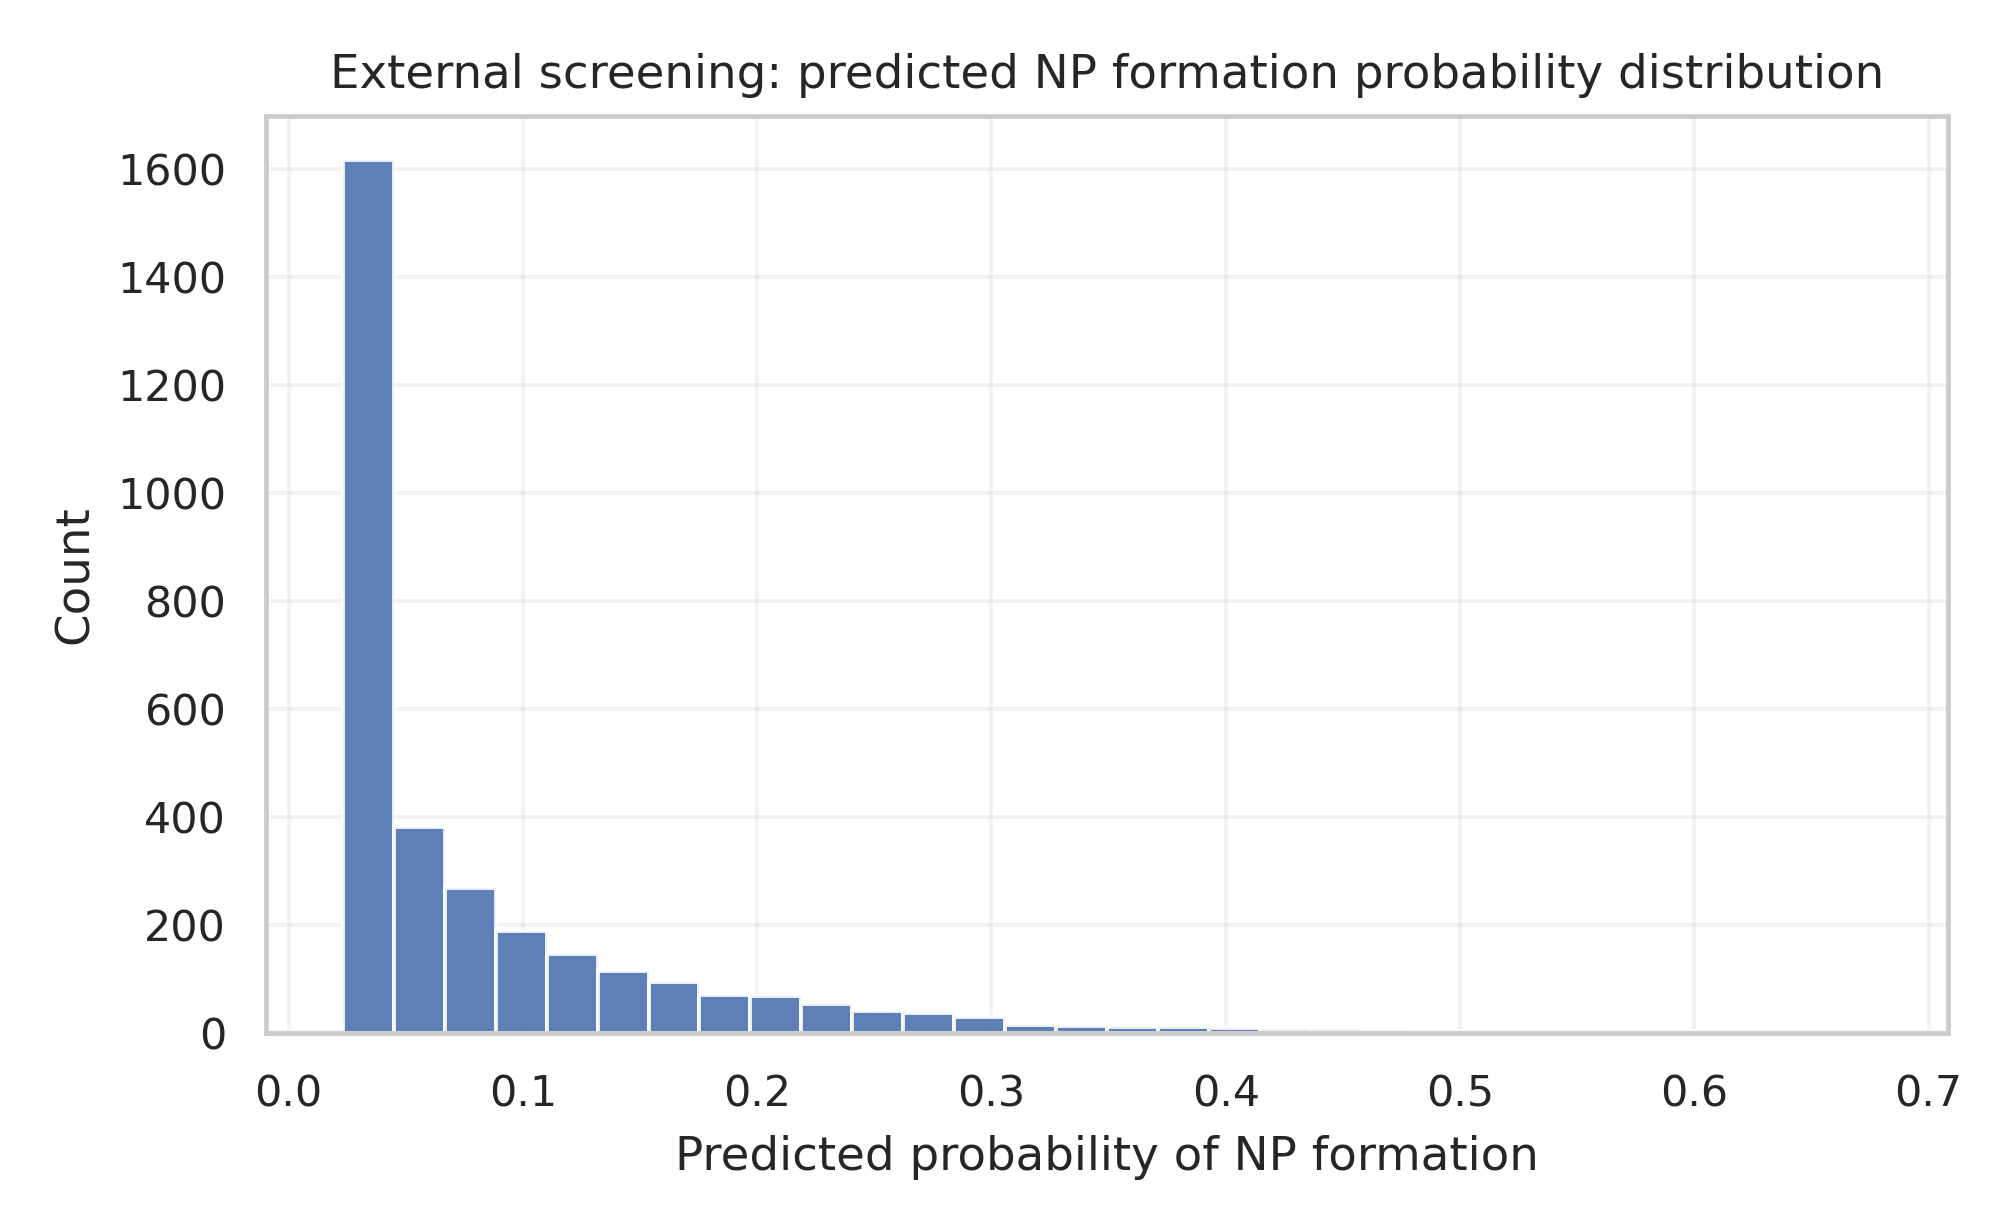

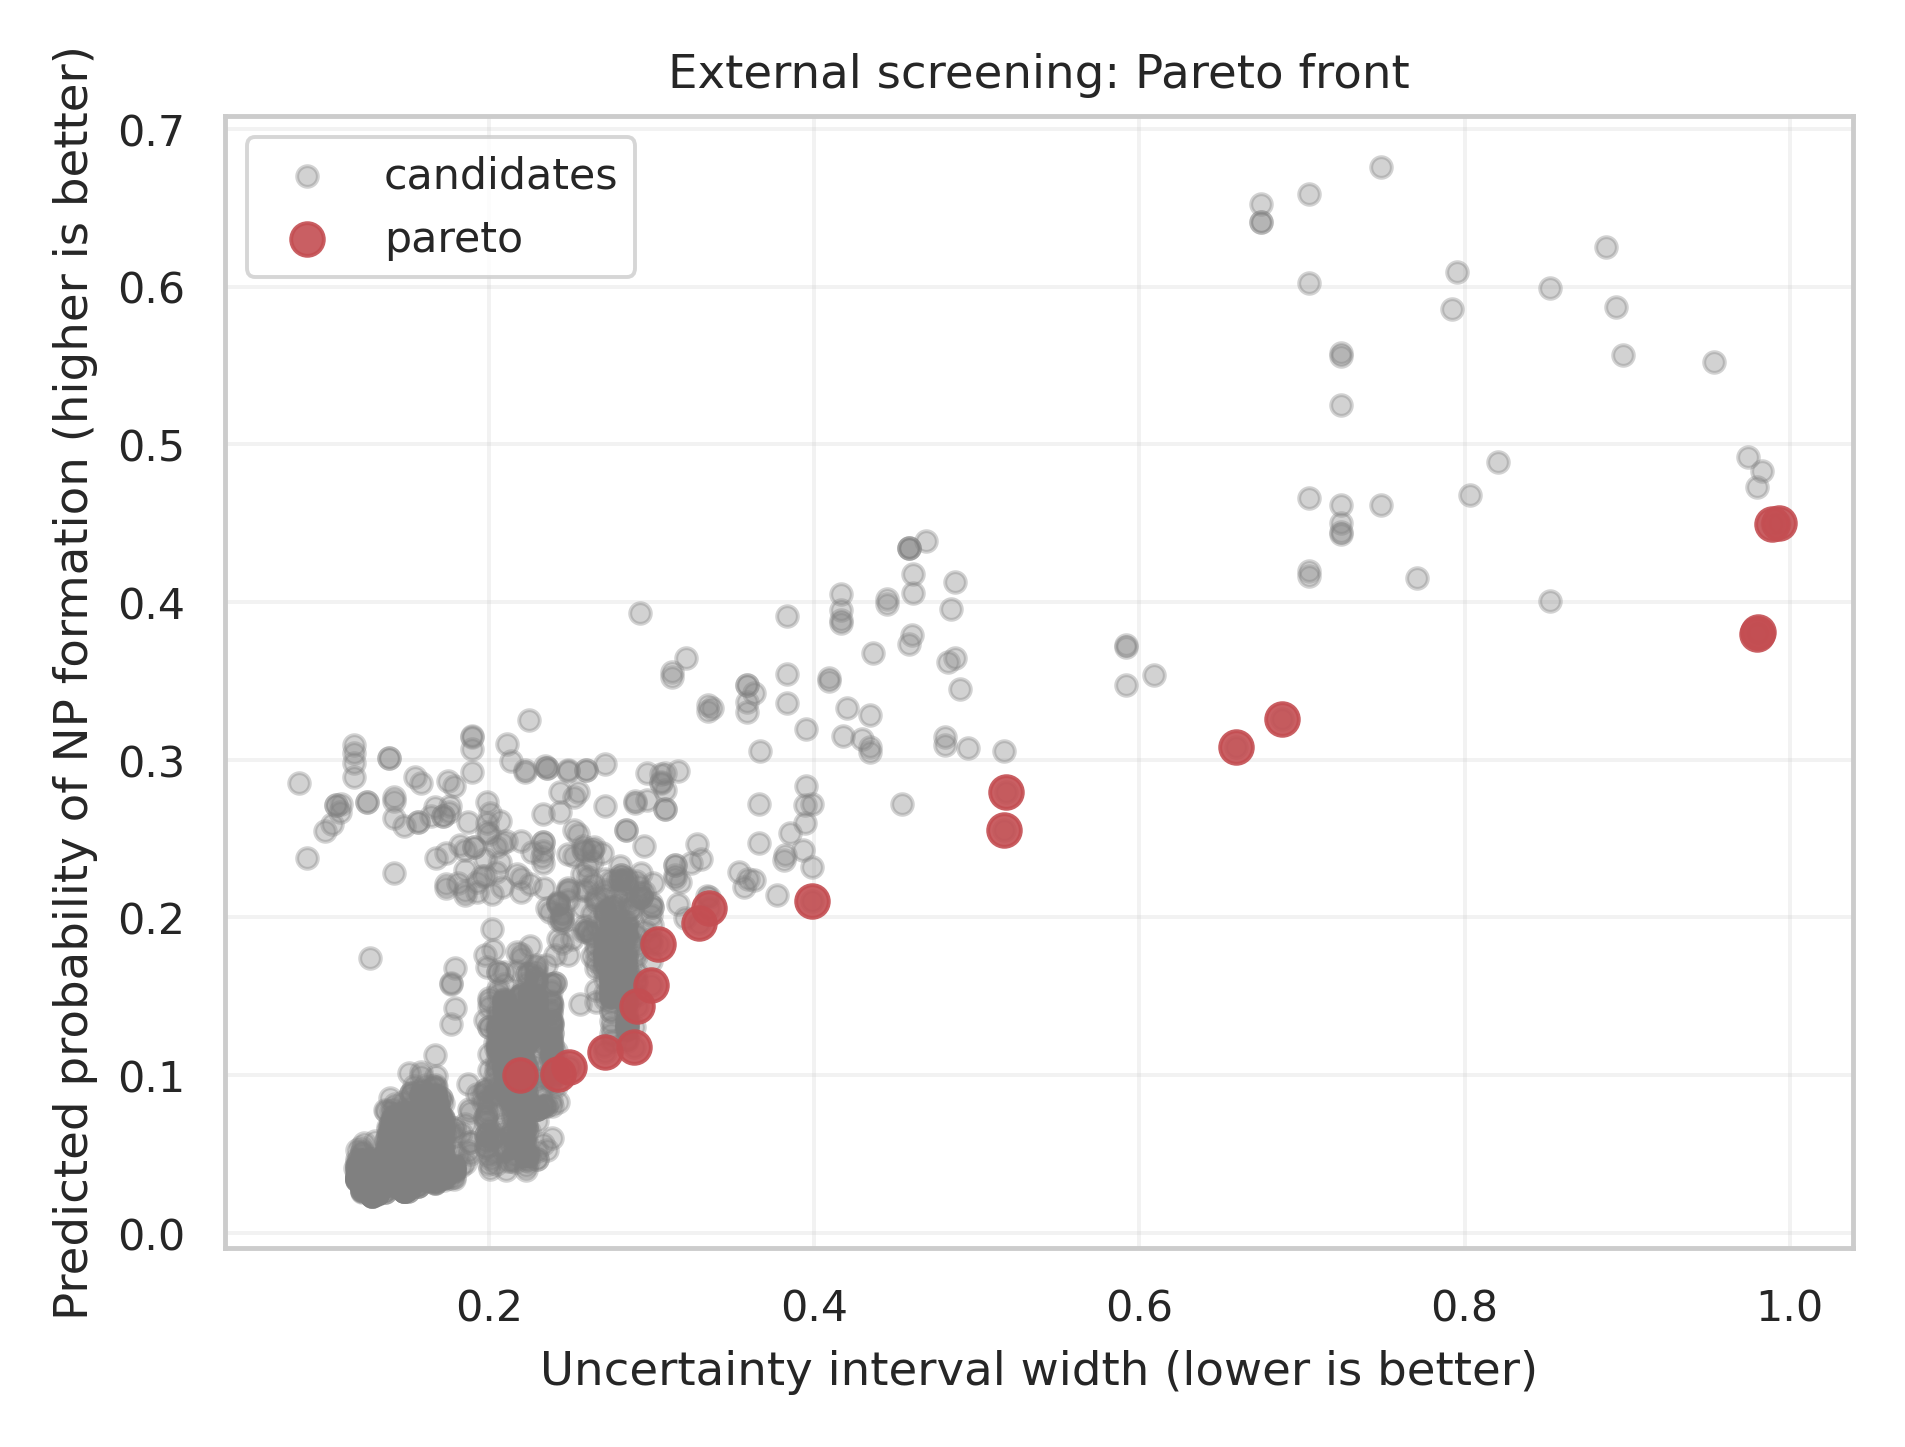

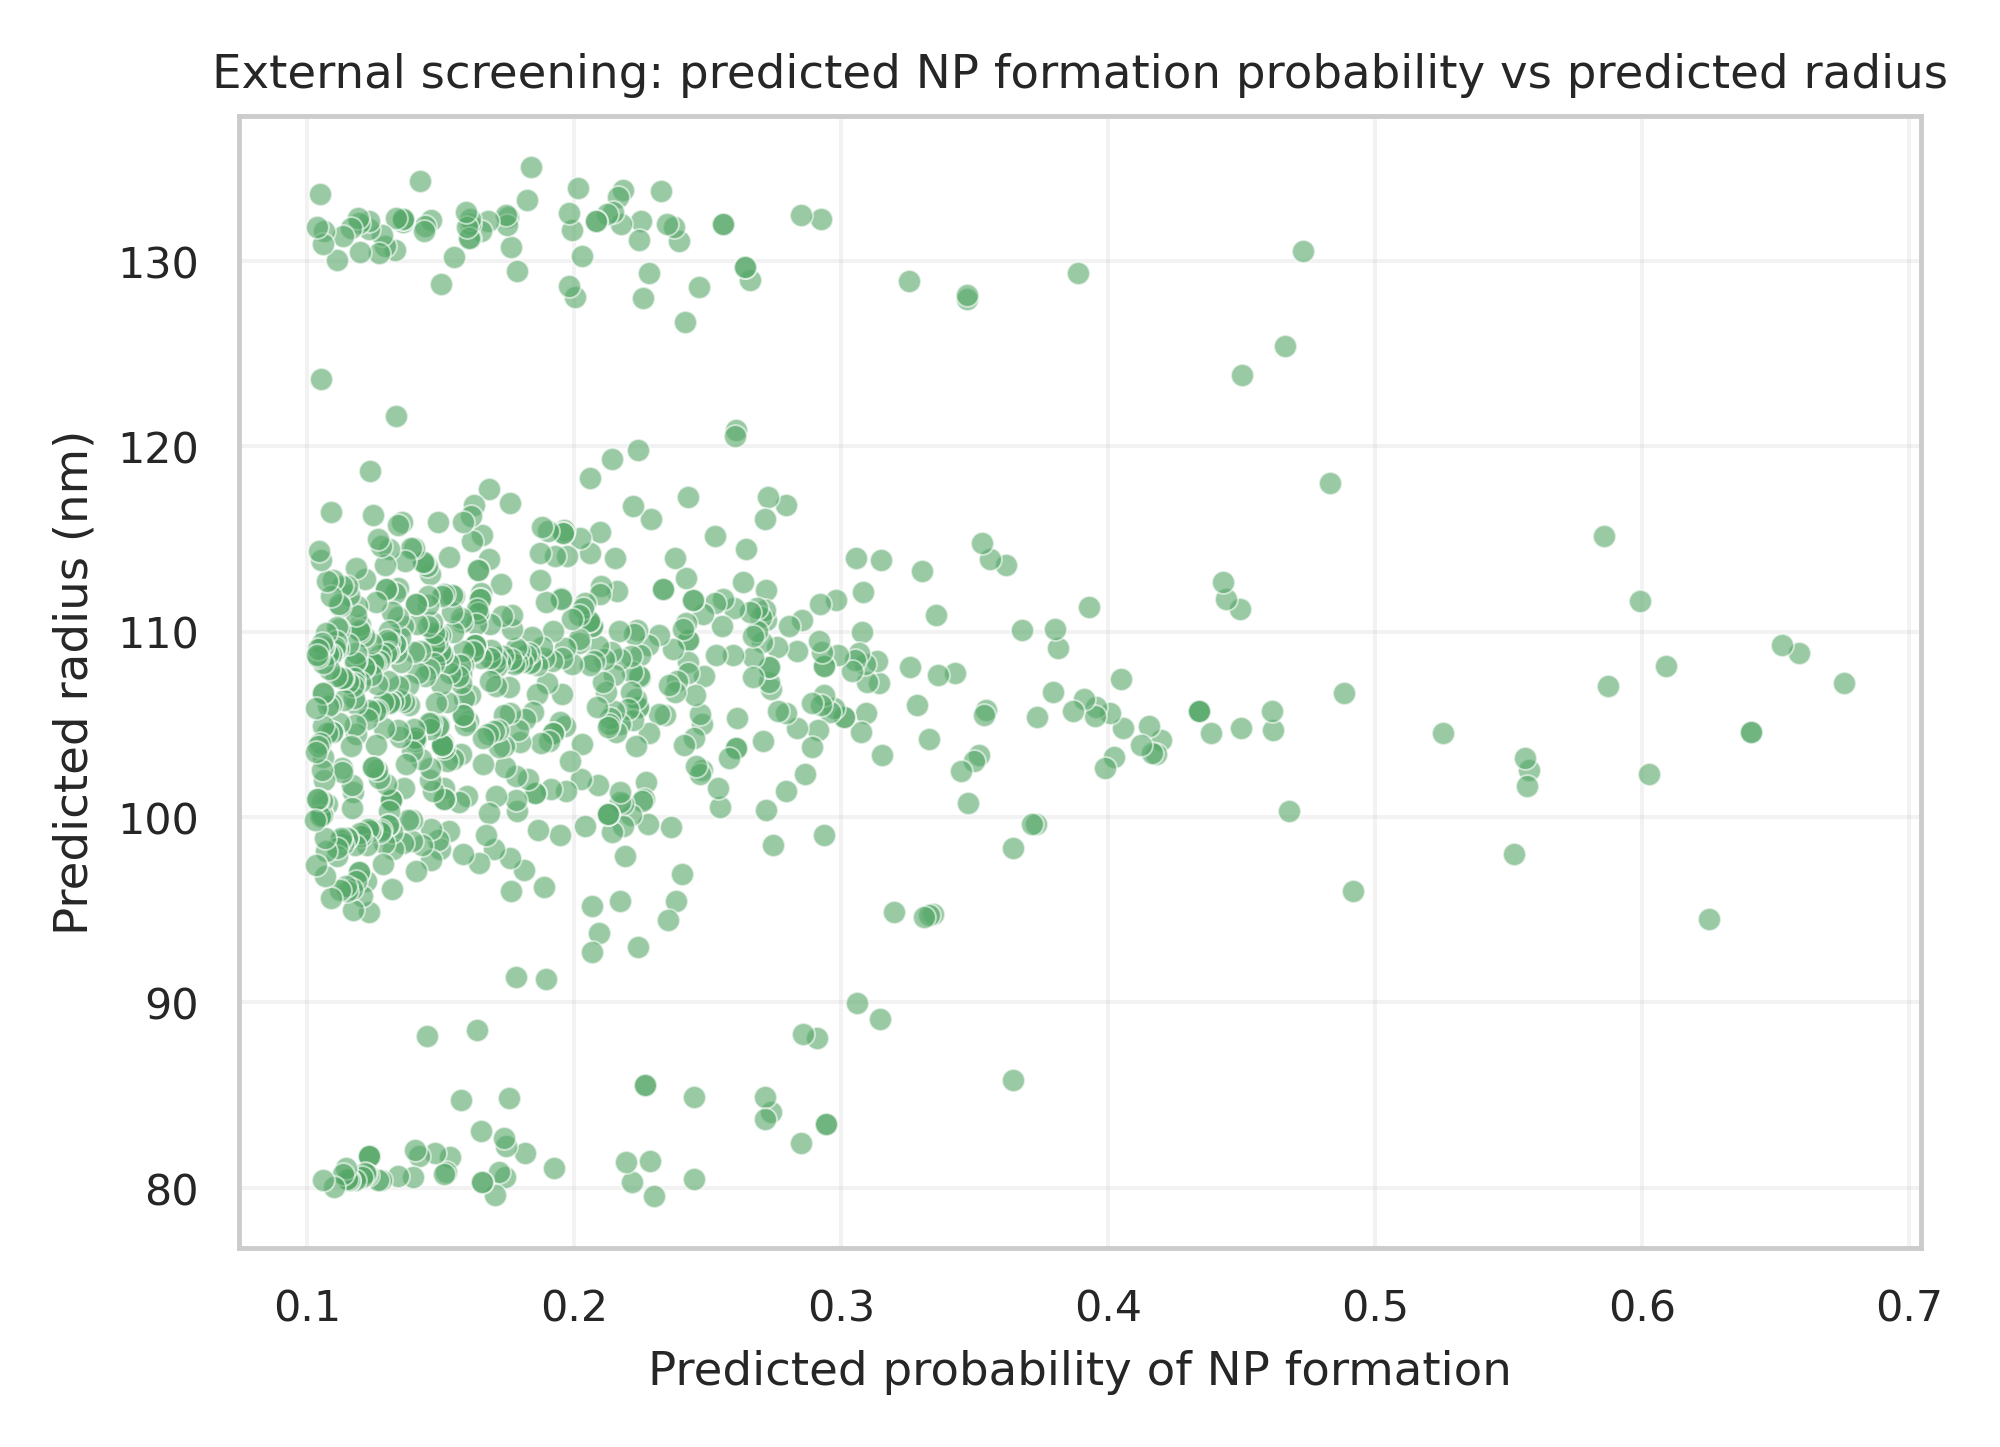

In [26]:
# 23) External screening report (figures + highlight tables)
if "ranked" not in globals():
    raise RuntimeError("Run the external screening cell first (step 12).")

ranked2 = ranked.copy()
ranked2["p_np_interval_width"] = ranked2["p_np_interval_high"] - ranked2["p_np_interval_low"]

export_table(ranked2.head(500), "external_ranked_candidates_top500")
export_table(pareto, "external_pareto_front")
export_table(doe, "ratio_doe_plan")

try:
    import jinja2  # noqa: F401

    _HAS_JINJA2 = True
except Exception:
    _HAS_JINJA2 = False
    print("Jinja2 not installed; skipping pandas Styler preview table.")

if _HAS_JINJA2:
    display(
        ranked2.head(25)
        .style.set_caption("Top-25 ranked candidates")
        .format(
            {
                "p_np_final": "{:.3f}",
                "p_np_interval_low": "{:.3f}",
                "p_np_interval_high": "{:.3f}",
                "p_np_interval_width": "{:.3f}",
            }
        )
        .background_gradient(subset=["p_np_final"], cmap="viridis")
        .background_gradient(subset=["p_np_interval_width"], cmap="magma_r")
    )
else:
    display(ranked2.head(25))

# Distribution of final probabilities
fig, ax = plt.subplots(figsize=(6.2, 3.4))
ax.hist(ranked2["p_np_final"].astype(float), bins=30, color="#4C72B0", alpha=0.9)
ax.set_title("External screening: predicted NP formation probability distribution")
ax.set_xlabel("Predicted probability of NP formation")
ax.set_ylabel("Count")
savefig(fig, "external_pnp_distribution")

# Pareto scatter: score vs uncertainty width
fig, ax = plt.subplots(figsize=(6.0, 4.2))
ax.scatter(
    ranked2["p_np_interval_width"],
    ranked2["p_np_final"],
    s=18,
    alpha=0.35,
    color="gray",
    label="candidates",
)
if pareto is not None and not pareto.empty:
    p2 = pareto.copy()
    p2["p_np_interval_width"] = p2["p_np_interval_high"] - p2["p_np_interval_low"]
    ax.scatter(p2["p_np_interval_width"], p2["p_np_final"], s=45, alpha=0.9, color="#C44E52", label="pareto")
ax.set_title("External screening: Pareto front")
ax.set_xlabel("Uncertainty interval width (lower is better)")
ax.set_ylabel("Predicted probability of NP formation (higher is better)")
ax.legend()
savefig(fig, "external_pareto_scatter")

# Predicted NP formation probability vs predicted radius (if available)
if "pred_radius_nm" in ranked2.columns:
    fig, ax = plt.subplots(figsize=(6.2, 4.2))
    sub = ranked2.head(800).copy()
    yv = pd.to_numeric(sub["pred_radius_nm"], errors="coerce")
    xv = pd.to_numeric(sub["p_np_final"], errors="coerce")
    ax.scatter(xv, yv, s=22, alpha=0.6, color="#55A868", edgecolor="white", linewidth=0.4)
    ax.set_title("External screening: predicted NP formation probability vs predicted radius")
    ax.set_xlabel("Predicted probability of NP formation")
    ax.set_ylabel("Predicted radius (nm)")
    savefig(fig, "external_pnp_vs_pred_radius")
